<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1429]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import patsy
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV,ElasticNetCV
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

## Load the file and overview the data

In [1430]:
# Load the data
house = pd.read_csv('./housing.csv')

In [1431]:
# A:
house.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities    ...     PoolArea PoolQC Fence MiscFeature MiscVal  \
0         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
1         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
2         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
3         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
4         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   

  MoSold YrSold  SaleType  SaleCondition  SalePrice  
0      2   2008        WD         Normal     208500  
1      5   2007        WD         Normal     181500  
2      9   2008        WD         Normal     223500  
3      2   2006        WD        Abnorml     140000  
4     12   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [1432]:
house.shape

(1460, 81)

In [1433]:
house.rename(columns={'1stFlrSF':'FirstFlrSF',
                      '2ndFlrSF':'SecondFlrSF', 
                      '3SsnPorch': 'ThreeSsnPorch'}, inplace=True)

In [1434]:
house.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'FirstFlrSF', 'SecondFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'Paved

In [1435]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

/Users/nandar/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


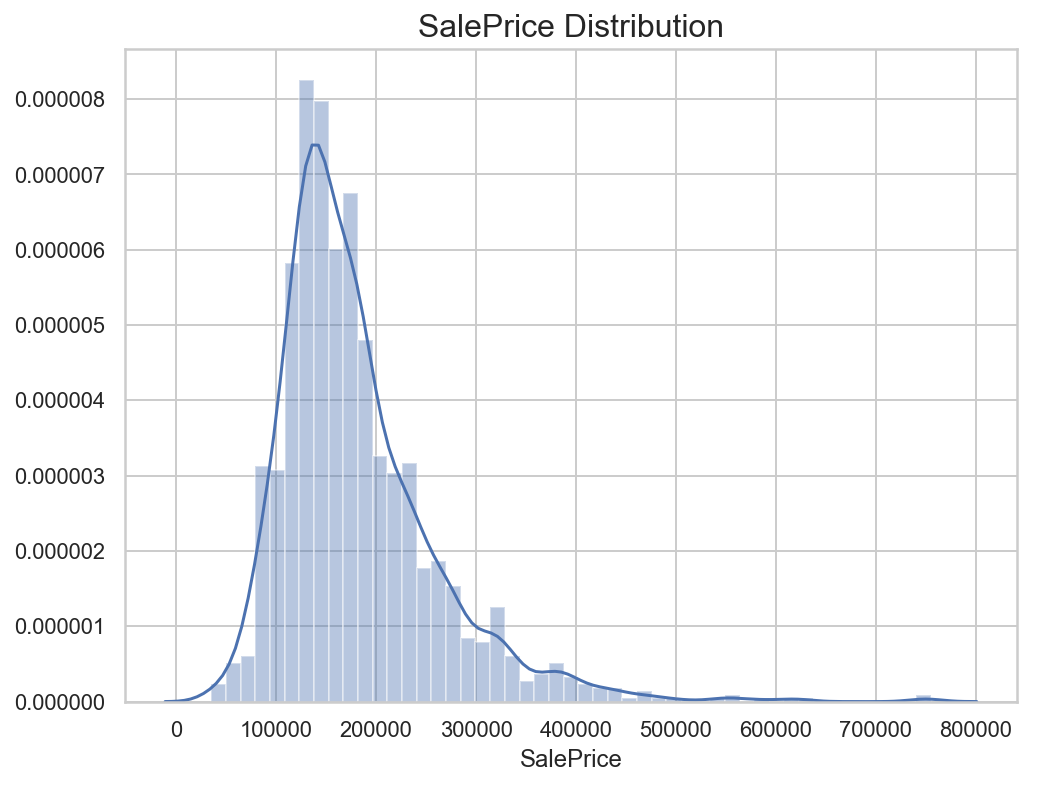

In [1436]:
plt.figure(figsize=(8,6))
plt.title('SalePrice Distribution',size=16)
sns.distplot(house['SalePrice'], kde=True)
plt.show();

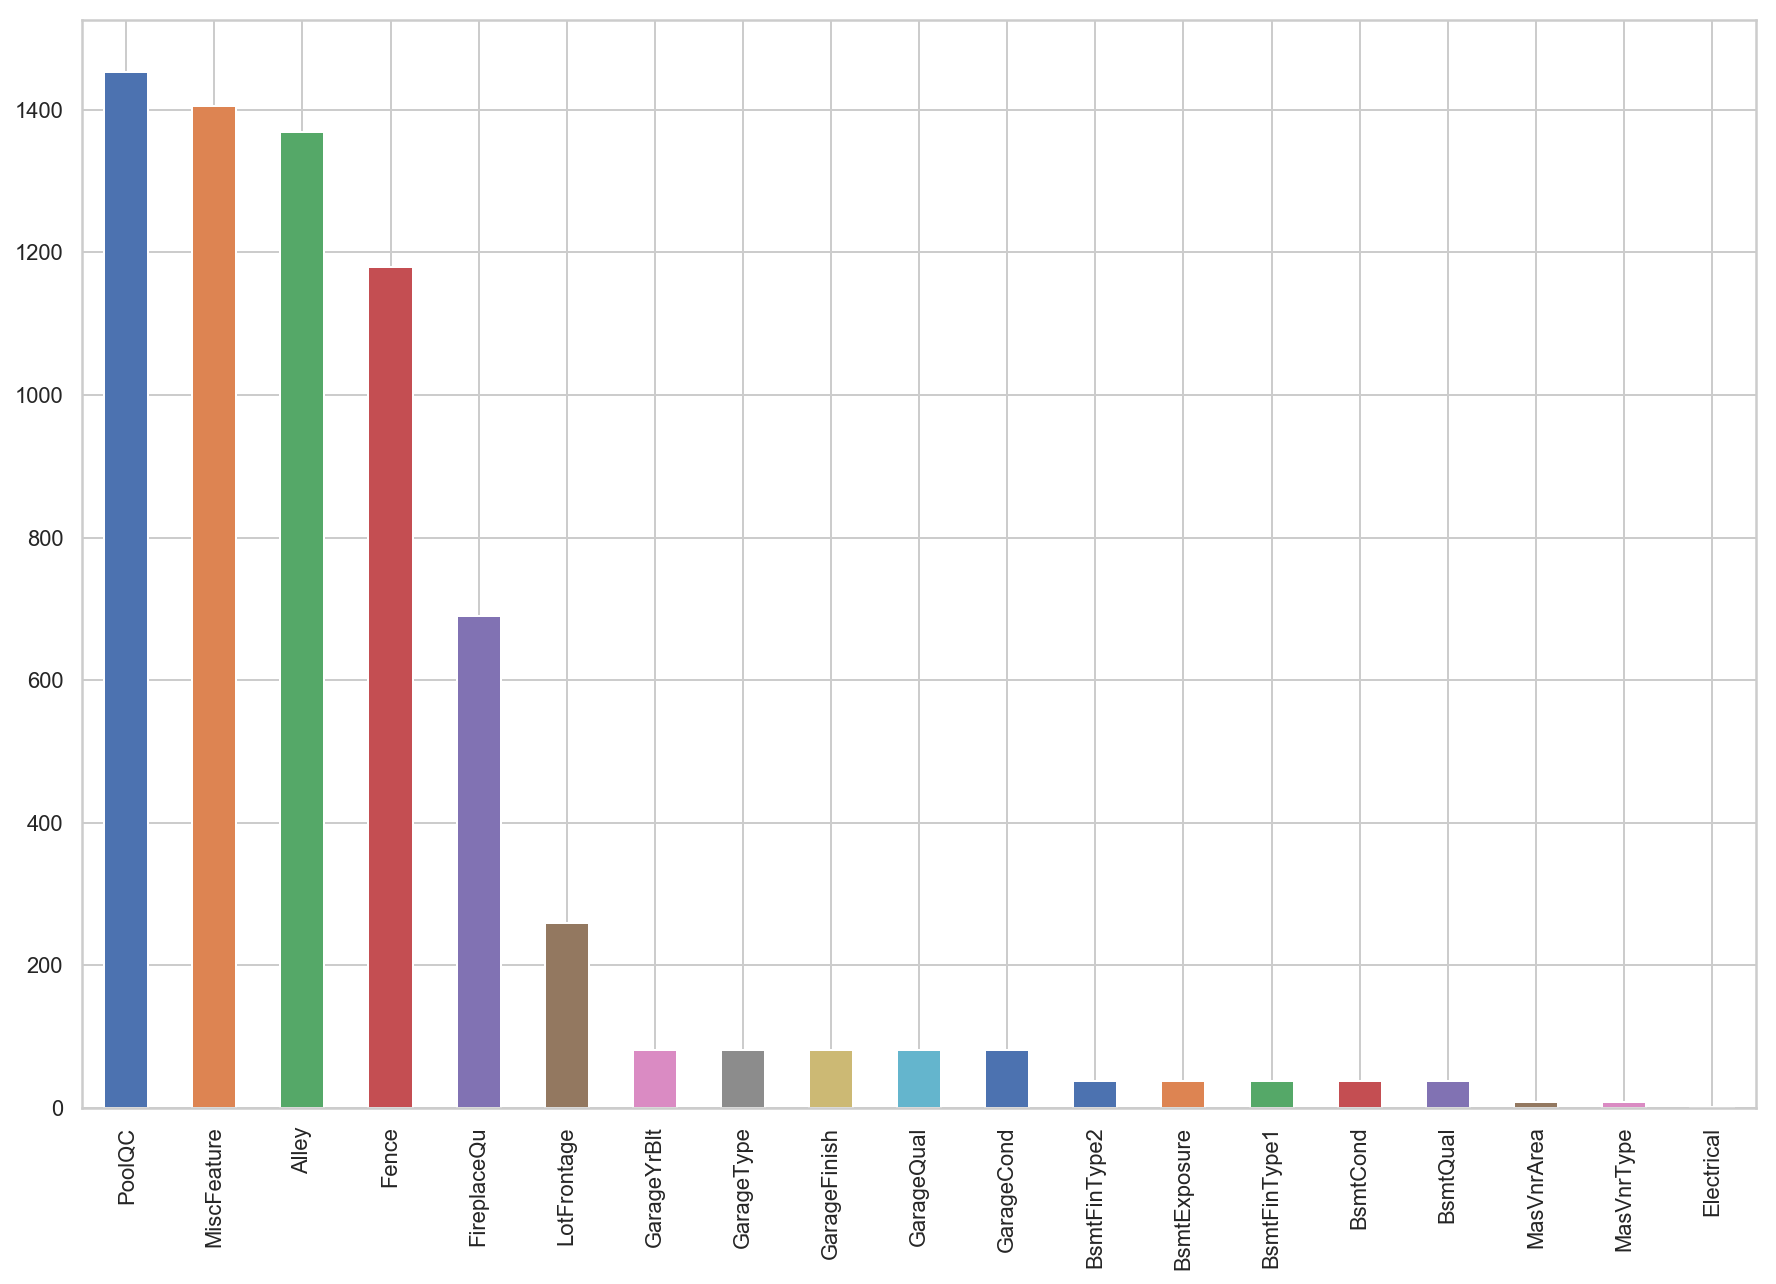

In [1437]:
house_na = house.isnull().sum()

# get rid of all the values with 0 missing values
house_na = house_na.drop(house_na[house_na == 0].index).sort_values(ascending=False)
plt.subplots(figsize =(15, 10))
house_na.plot(kind='bar');

#### Observation : 
- SalePrice is skewed to right (positive skewness), therefore, these outliers will be removed during the EDA process.
- Missing Values need to be handled.

## Filtering only residential houses or zone only

In [1438]:
house['MSZoning'].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [1439]:
Residential_house = house[house['MSZoning'].isin(['RH','RL','RP','RM','FV'])]

In [1440]:
Residential_house['MSZoning'].value_counts()

RL    1151
RM     218
FV      65
RH      16
Name: MSZoning, dtype: int64

In [1441]:
Residential_house.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities    ...     PoolArea PoolQC Fence MiscFeature MiscVal  \
0         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
1         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
2         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
3         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
4         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   

  MoSold YrSold  SaleType  SaleCondition  SalePrice  
0      2   2008        WD         Normal     208500  
1      5   2007        WD         Normal     181500  
2      9   2008        WD         Normal     223500  
3      2   2006        WD        Abnorml     140000  
4     12   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [1442]:
Residential_house.shape

(1450, 81)

In [1443]:
Residential_house.SaleType.value_counts()

WD       1261
New       122
COD        41
ConLD       7
ConLI       5
ConLw       5
CWD         4
Oth         3
Con         2
Name: SaleType, dtype: int64

## EDA - Cleaning Null

In [1444]:
# Checking the null counts and percentage
check_null = list(zip(Residential_house.columns,
                      Residential_house.isnull().sum(),
                      np.round(Residential_house.isnull().sum()/Residential_house.shape[0],3)))
[x for x in check_null if x[1] !=0]

[('LotFrontage', 259, 0.179),
 ('Alley', 1361, 0.939),
 ('MasVnrType', 8, 0.006),
 ('MasVnrArea', 8, 0.006),
 ('BsmtQual', 37, 0.026),
 ('BsmtCond', 37, 0.026),
 ('BsmtExposure', 38, 0.026),
 ('BsmtFinType1', 37, 0.026),
 ('BsmtFinType2', 38, 0.026),
 ('Electrical', 1, 0.001),
 ('FireplaceQu', 681, 0.47),
 ('GarageType', 79, 0.054),
 ('GarageYrBlt', 79, 0.054),
 ('GarageFinish', 79, 0.054),
 ('GarageQual', 79, 0.054),
 ('GarageCond', 79, 0.054),
 ('PoolQC', 1443, 0.995),
 ('Fence', 1172, 0.808),
 ('MiscFeature', 1398, 0.964)]

#### Handling NAN for 'Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature' columns

In [1445]:
def fillna_func(column,replace_word):
    #print(Residential_house[column].value_counts(dropna=False))
    Residential_house[column].fillna(replace_word, axis=0, inplace=True)
    #print(Residential_house[column].value_counts(dropna=False))

In [1446]:
# Replace nan value with NA for Alley column
fillna_func('Alley','NA')

In [1447]:
Columns_NA = ['Alley','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',
              'BsmtFinType2','FireplaceQu','GarageType','GarageFinish','GarageQual',
              'GarageCond','PoolQC','Fence','MiscFeature']

for x in Columns_NA:
    fillna_func(x,'NA')

In [1448]:
# Replace nan value with None for MasVnrType column
Columns_None = ['MasVnrType']
for x in Columns_None:
    fillna_func(x,'None')

In [1449]:
Columns_Other = ['Exterior1st','Exterior2nd','MiscFeature','SaleType']

#### <b> Handling NAN for Electrical column </b>

In [1450]:
Residential_house['Electrical'].value_counts(dropna=False)

SBrkr    1328
FuseA      90
FuseF      27
FuseP       3
Mix         1
NaN         1
Name: Electrical, dtype: int64

In [1451]:
Residential_house[Residential_house['Electrical'].isnull()==True].index

Int64Index([1379], dtype='int64')

In [1452]:
# Drop the nan value from Electrical column since the ratio is 0.001
Residential_house.drop(Residential_house[Residential_house['Electrical'].isnull()==True].index,
                       axis=0, inplace=True)

#### <B>Replacing NAN value with Mean/Median values</b>

In [1453]:
np.mean(Residential_house['LotFrontage'])

70.05042016806723

In [1454]:
Residential_house.groupby('Neighborhood')['LotFrontage'].apply(lambda x: x.median())

Neighborhood
Blmngtn    43.0
Blueste    24.0
BrDale     21.0
BrkSide    52.0
ClearCr    80.0
CollgCr    70.0
Crawfor    74.0
Edwards    65.5
Gilbert    65.0
IDOTRR     60.0
MeadowV    21.0
Mitchel    73.0
NAmes      73.0
NPkVill    24.0
NWAmes     80.0
NoRidge    91.0
NridgHt    88.5
OldTown    60.0
SWISU      60.0
Sawyer     71.0
SawyerW    66.5
Somerst    73.5
StoneBr    61.5
Timber     85.0
Veenker    68.0
Name: LotFrontage, dtype: float64

In [1455]:
Residential_house.loc[:,'LotFrontage'] = Residential_house.groupby('Neighborhood')['LotFrontage'].apply(lambda x: x.fillna(x.median()))

In [1456]:
### Test code
#Residential_house['LotFrontage_new'] = Residential_house.groupby('Neighborhood')['LotFrontage'].apply(lambda x: x.fillna(x.median()))
## Checking if all the null column is filled up
#(Residential_house['LotFrontage_new'] != Residential_house['LotFrontage']).sum()

In [1457]:
def fillmean_func(column):
    Residential_house[column].fillna(np.mean(Residential_house[column]), 
                                     axis=0, inplace=True)

In [1458]:
Columns_Mean = ['MasVnrArea','GarageYrBlt']

for x in Columns_Mean:
    fillmean_func(x)

In [1459]:
# Checking again to confirm there is no null anymore
check_null = list(zip(Residential_house.columns,
                      Residential_house.isnull().sum(),
                      np.round(Residential_house.isnull().sum()/Residential_house.shape[0],3)))
[x for x in check_null if x[1] !=0]

[]

## EDA - Aggreating columns and Checking redundant columns

In [1460]:
## Combining FullBath of the whole house
Residential_house['TotalFullBath'] = Residential_house['BsmtFullBath'] + Residential_house['FullBath']

In [1461]:
## Combining HalfBath of the whole house
Residential_house['TotalHalfBath'] = Residential_house['BsmtHalfBath'] + Residential_house['HalfBath']

In [1462]:
## Drop the unnecessary columns after aggreating
Residential_house.drop(['Id','BsmtFullBath','FullBath','BsmtHalfBath','HalfBath'],axis=1,inplace=True)

In [1463]:
Residential_house.head()

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave    NA      Reg   
1          20       RL         80.0     9600   Pave    NA      Reg   
2          60       RL         68.0    11250   Pave    NA      IR1   
3          70       RL         60.0     9550   Pave    NA      IR1   
4          60       RL         84.0    14260   Pave    NA      IR1   

  LandContour Utilities LotConfig      ...       Fence MiscFeature MiscVal  \
0         Lvl    AllPub    Inside      ...          NA          NA       0   
1         Lvl    AllPub       FR2      ...          NA          NA       0   
2         Lvl    AllPub    Inside      ...          NA          NA       0   
3         Lvl    AllPub    Corner      ...          NA          NA       0   
4         Lvl    AllPub       FR2      ...          NA          NA       0   

  MoSold YrSold SaleType  SaleCondition  SalePrice  TotalFullBath  \
0      2   2008       WD         Normal     208500              3   
1      5   2007       WD         Normal     181500              2   
2      9   2008       WD         Normal     223500              3   
3      2   2006       WD        Abnorml     140000              2   
4     12   2008       WD         Normal     250000              3   

   TotalHalfBath  
0              1  
1              1  
2              1  
3              0  
4              1  

[5 rows x 78 columns]

In [1464]:
## Creating House Age by substracting YearBuilt and YearSold 
Residential_house['HouseAge'] = Residential_house['YearBuilt']-Residential_house['YrSold']

In [1465]:
## Creating Renovating Years by substracting YearRemodAdd and YearSold 
Residential_house['RenovationAge'] = Residential_house['YearRemodAdd']-Residential_house['YrSold']

In [1466]:
## Creating Renovating Years by substracting YearRemodAdd and YearSold 
Residential_house['GarageAge'] = Residential_house['GarageYrBlt']-Residential_house['YrSold']

In [1467]:
## Checking if total basement area is same as sum of all 3 columns related to basement area
Residential_house['TotalBsmtSF_temp'] = Residential_house['BsmtFinSF1'] + Residential_house['BsmtFinSF2']\
                                        + Residential_house['BsmtUnfSF']

(Residential_house['TotalBsmtSF'] != Residential_house['TotalBsmtSF_temp']).sum()

0

In [1468]:
## After checking is done as above and found out they are same features, these redundant columns will be dropped.
Residential_house.drop(['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF_temp'],axis=1,inplace=True)

In [1469]:
Residential_house.groupby(['BsmtCond'])

In [1470]:
Residential_house[Residential_house['BsmtCond']=='NA']['TotalBsmtSF']

17      0
39      0
90      0
102     0
156     0
182     0
259     0
342     0
362     0
371     0
392     0
520     0
532     0
533     0
553     0
646     0
705     0
736     0
749     0
778     0
868     0
894     0
897     0
984     0
1000    0
1011    0
1035    0
1045    0
1048    0
1049    0
1090    0
1179    0
1216    0
1218    0
1232    0
1321    0
1412    0
Name: TotalBsmtSF, dtype: int64

In [1471]:
spike_cols = [col for col in Residential_house.columns if 'Bsmt' in col]
Residential_house[spike_cols]

BsmtQual BsmtCond BsmtExposure BsmtFinType1 BsmtFinType2  TotalBsmtSF
0          Gd       TA           No          GLQ          Unf          856
1          Gd       TA           Gd          ALQ          Unf         1262
2          Gd       TA           Mn          GLQ          Unf          920
3          TA       Gd           No          ALQ          Unf          756
4          Gd       TA           Av          GLQ          Unf         1145
5          Gd       TA           No          GLQ          Unf          796
6          Ex       TA           Av          GLQ          Unf         1686
7          Gd       TA           Mn          ALQ          BLQ         1107
8          TA       TA           No          Unf          Unf          952
9          TA       TA           No          GLQ          Unf          991
10         TA       TA           No          Rec          Unf         1040
11         Ex       TA           No          GLQ          Unf         1175
12         TA       TA           No          ALQ          Unf          912
13         Gd       TA           Av          Unf          Unf         1494
14         TA       TA           No          BLQ          Unf         1253
15         TA       TA           No          Unf          Unf          832
16         TA       TA           No          ALQ          Unf         1004
17         NA       NA           NA           NA           NA            0
18         TA       TA           No          GLQ          Unf         1114
19         TA       TA           No          LwQ          Unf         1029
20         Ex       TA           Av          Unf          Unf         1158
21         TA       TA           No          Unf          Unf          637
22         Gd       TA           No          Unf          Unf         1777
23         Gd       TA           No          GLQ          Unf         1040
24         TA       TA           Mn          Rec          ALQ         1060
25         Gd       TA           No          Unf          Unf         1566
26         TA       TA           Mn          BLQ          Rec          900
27         Ex       TA           No          GLQ          Unf         1704
28         TA       TA           Gd          BLQ          Unf         1484
29         TA       TA           No          Unf          Unf          520
...       ...      ...          ...          ...          ...          ...
1430       Gd       Gd           Av          Unf          Unf          732
1431       Gd       TA           No          LwQ          Unf          958
1432       TA       TA           No          Unf          Unf          656
1433       Gd       TA           No          Unf          Unf          936
1434       TA       TA           No          ALQ          Unf         1126
1435       TA       TA           No          Unf          Unf         1319
1436       TA       TA           No          ALQ          Unf          864
1437       Ex       TA           Av          GLQ          Unf         1932
1438       TA       TA           No          GLQ          Unf          912
1439       TA       TA           No          GLQ          Rec          539
1440       Ex       TA           No          Unf          Unf          588
1441       Gd       TA           Av          GLQ          Unf          848
1442       Ex       TA           Av          GLQ          Unf         1017
1443       TA       TA           No          Unf          Unf          952
1444       Gd       TA           Av          Unf          Unf         1422
1445       TA       TA           Gd          LwQ          Rec          814
1446       TA       TA           No          Rec          Unf         1188
1447       Gd       TA           No          GLQ          Unf         1220
1448       Fa       TA           No          Unf          Unf          560
1449       Gd       TA           Av          GLQ          Unf          630
1450       Gd       TA           No          Unf          Unf          896
1451       Gd       TA        

## EDA - Replacing or Decoding the columns/features

#### Decoding MSSubClass

In [1472]:
## Digital no is presented as reference code for MSSubClass feature.
## If we leave the digital no as it is, it'll be treated as numerical data.
## Therefore, Decoding is done since it is supposed to be categorical data.

Residential_house.MSSubClass.value_counts()

20     534
60     299
50     140
120     87
30      67
160     63
70      59
80      57
90      52
190     29
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64

In [1473]:
def MSSubClass_convert(value):
    if value == 20:
        return '1-STORY 1946 & NEWER ALL STYLES'
    elif value == 30:
        return '1-STORY 1945 & OLDER'
    elif value == 40:
        return '1-STORY W/FINISHED ATTIC ALL AGES'
    elif value == 45:
        return '1-1/2 STORY - UNFINISHED ALL AGES'
    elif value == 50:
        return '1-1/2 STORY FINISHED ALL AGES'
    elif value == 60:
        return '2-STORY 1946 & NEWER'
    elif value == 70:
        return '2-STORY 1945 & OLDER'
    elif value == 75:
        return '2-1/2 STORY ALL AGES'
    elif value == 80:
        return 'SPLIT OR MULTI-LEVEL'
    elif value == 85:
        return 'SPLIT FOYER'
    elif value == 90:
        return 'DUPLEX - ALL STYLES AND AGES'
    elif value == 120:
        return '1-STORY PUD (Planned Unit Development) - 1946 & NEWER'
    elif value == 150:
        return '1-1/2 STORY PUD - ALL AGES'
    elif value == 160:
        return '2-STORY PUD - 1946 & NEWER'
    elif value == 180:
        return 'PUD - MULTILEVEL - INCL SPLIT LEV/FOYER'
    elif value == 190:
        return '2 FAMILY CONVERSION - ALL STYLES AND AGES'

In [1474]:
Residential_house['MSSubClass'] = Residential_house['MSSubClass'].apply(lambda x : MSSubClass_convert(x))

In [1475]:
Residential_house['MSSubClass'] = Residential_house['MSSubClass'].astype('object')

In [1476]:
Residential_house['MSSubClass'].dtype

dtype('O')

In [1477]:
## Confirming if replaced correctly or not
Residential_house['MSSubClass'].value_counts()

1-STORY 1946 & NEWER ALL STYLES                          534
2-STORY 1946 & NEWER                                     299
1-1/2 STORY FINISHED ALL AGES                            140
1-STORY PUD (Planned Unit Development) - 1946 & NEWER     87
1-STORY 1945 & OLDER                                      67
2-STORY PUD - 1946 & NEWER                                63
2-STORY 1945 & OLDER                                      59
SPLIT OR MULTI-LEVEL                                      57
DUPLEX - ALL STYLES AND AGES                              52
2 FAMILY CONVERSION - ALL STYLES AND AGES                 29
SPLIT FOYER                                               20
2-1/2 STORY ALL AGES                                      16
1-1/2 STORY - UNFINISHED ALL AGES                         12
PUD - MULTILEVEL - INCL SPLIT LEV/FOYER                   10
1-STORY W/FINISHED ATTIC ALL AGES                          4
Name: MSSubClass, dtype: int64

#### Decoding the quality and condition features

In [1478]:
Residential_house['BsmtCond'].value_counts()

TA    1302
Gd      65
Fa      43
NA      37
Po       2
Name: BsmtCond, dtype: int64

In [1479]:
def decode_evaluation(value):
    if value == 'GLQ':
        return 6
    elif value == 'Ex' or value == 'ALQ':
        return 5
    elif value == 'Gd' or value == 'GdPrv' or value == 'BLQ':
        return 4
    elif value == 'TA'or value == 'MnPrv' or value == 'Rec':
        return 3
    elif value == 'Fa'or value == 'GdWo' or value == 'LwQ':
        return 2
    elif value == 'Po'or value == 'MnWw' or value == 'Unf':
        return 1
    else:
        return 0

In [1480]:
[col for col in Residential_house.columns if 'Qual' in col or 'Cond' in col]

['Condition1',
 'Condition2',
 'OverallQual',
 'OverallCond',
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'LowQualFinSF',
 'KitchenQual',
 'GarageQual',
 'GarageCond',
 'SaleCondition']

In [1481]:
for col_name in ['ExterQual','ExterCond','BsmtQual','BsmtCond','KitchenQual','GarageQual','GarageCond',\
                 'BsmtFinType1','BsmtFinType2','Fence','FireplaceQu','HeatingQC','PoolQC']:
    Residential_house[col_name] = Residential_house[col_name].apply(lambda x : decode_evaluation(x))
    print(Residential_house[col_name].value_counts())

3    898
4    488
5     52
2     11
Name: ExterQual, dtype: int64
3    1274
4     145
2      26
5       3
1       1
Name: ExterCond, dtype: int64
3    639
4    617
5    121
0     37
2     35
Name: BsmtQual, dtype: int64
3    1302
4      65
2      43
0      37
1       2
Name: BsmtCond, dtype: int64
3    727
4    585
5    100
2     37
Name: KitchenQual, dtype: int64
3    1302
0      79
2      48
4      14
5       3
1       3
Name: GarageQual, dtype: int64
3    1318
0      79
2      34
4       9
1       7
5       2
Name: GarageCond, dtype: int64
1    423
6    418
5    220
4    147
3    130
2     74
0     37
Name: BsmtFinType1, dtype: int64
1    1245
3      54
2      46
0      38
4      33
5      19
6      14
Name: BsmtFinType2, dtype: int64
0    1171
3     155
4      59
2      53
1      11
Name: Fence, dtype: int64
0    680
4    379
3    313
2     33
5     24
1     20
Name: FireplaceQu, dtype: int64
5    740
3    421
4    238
2     49
1      1
Name: HeatingQC, dtype: int64
0    1442
4    

/Users/nandar/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


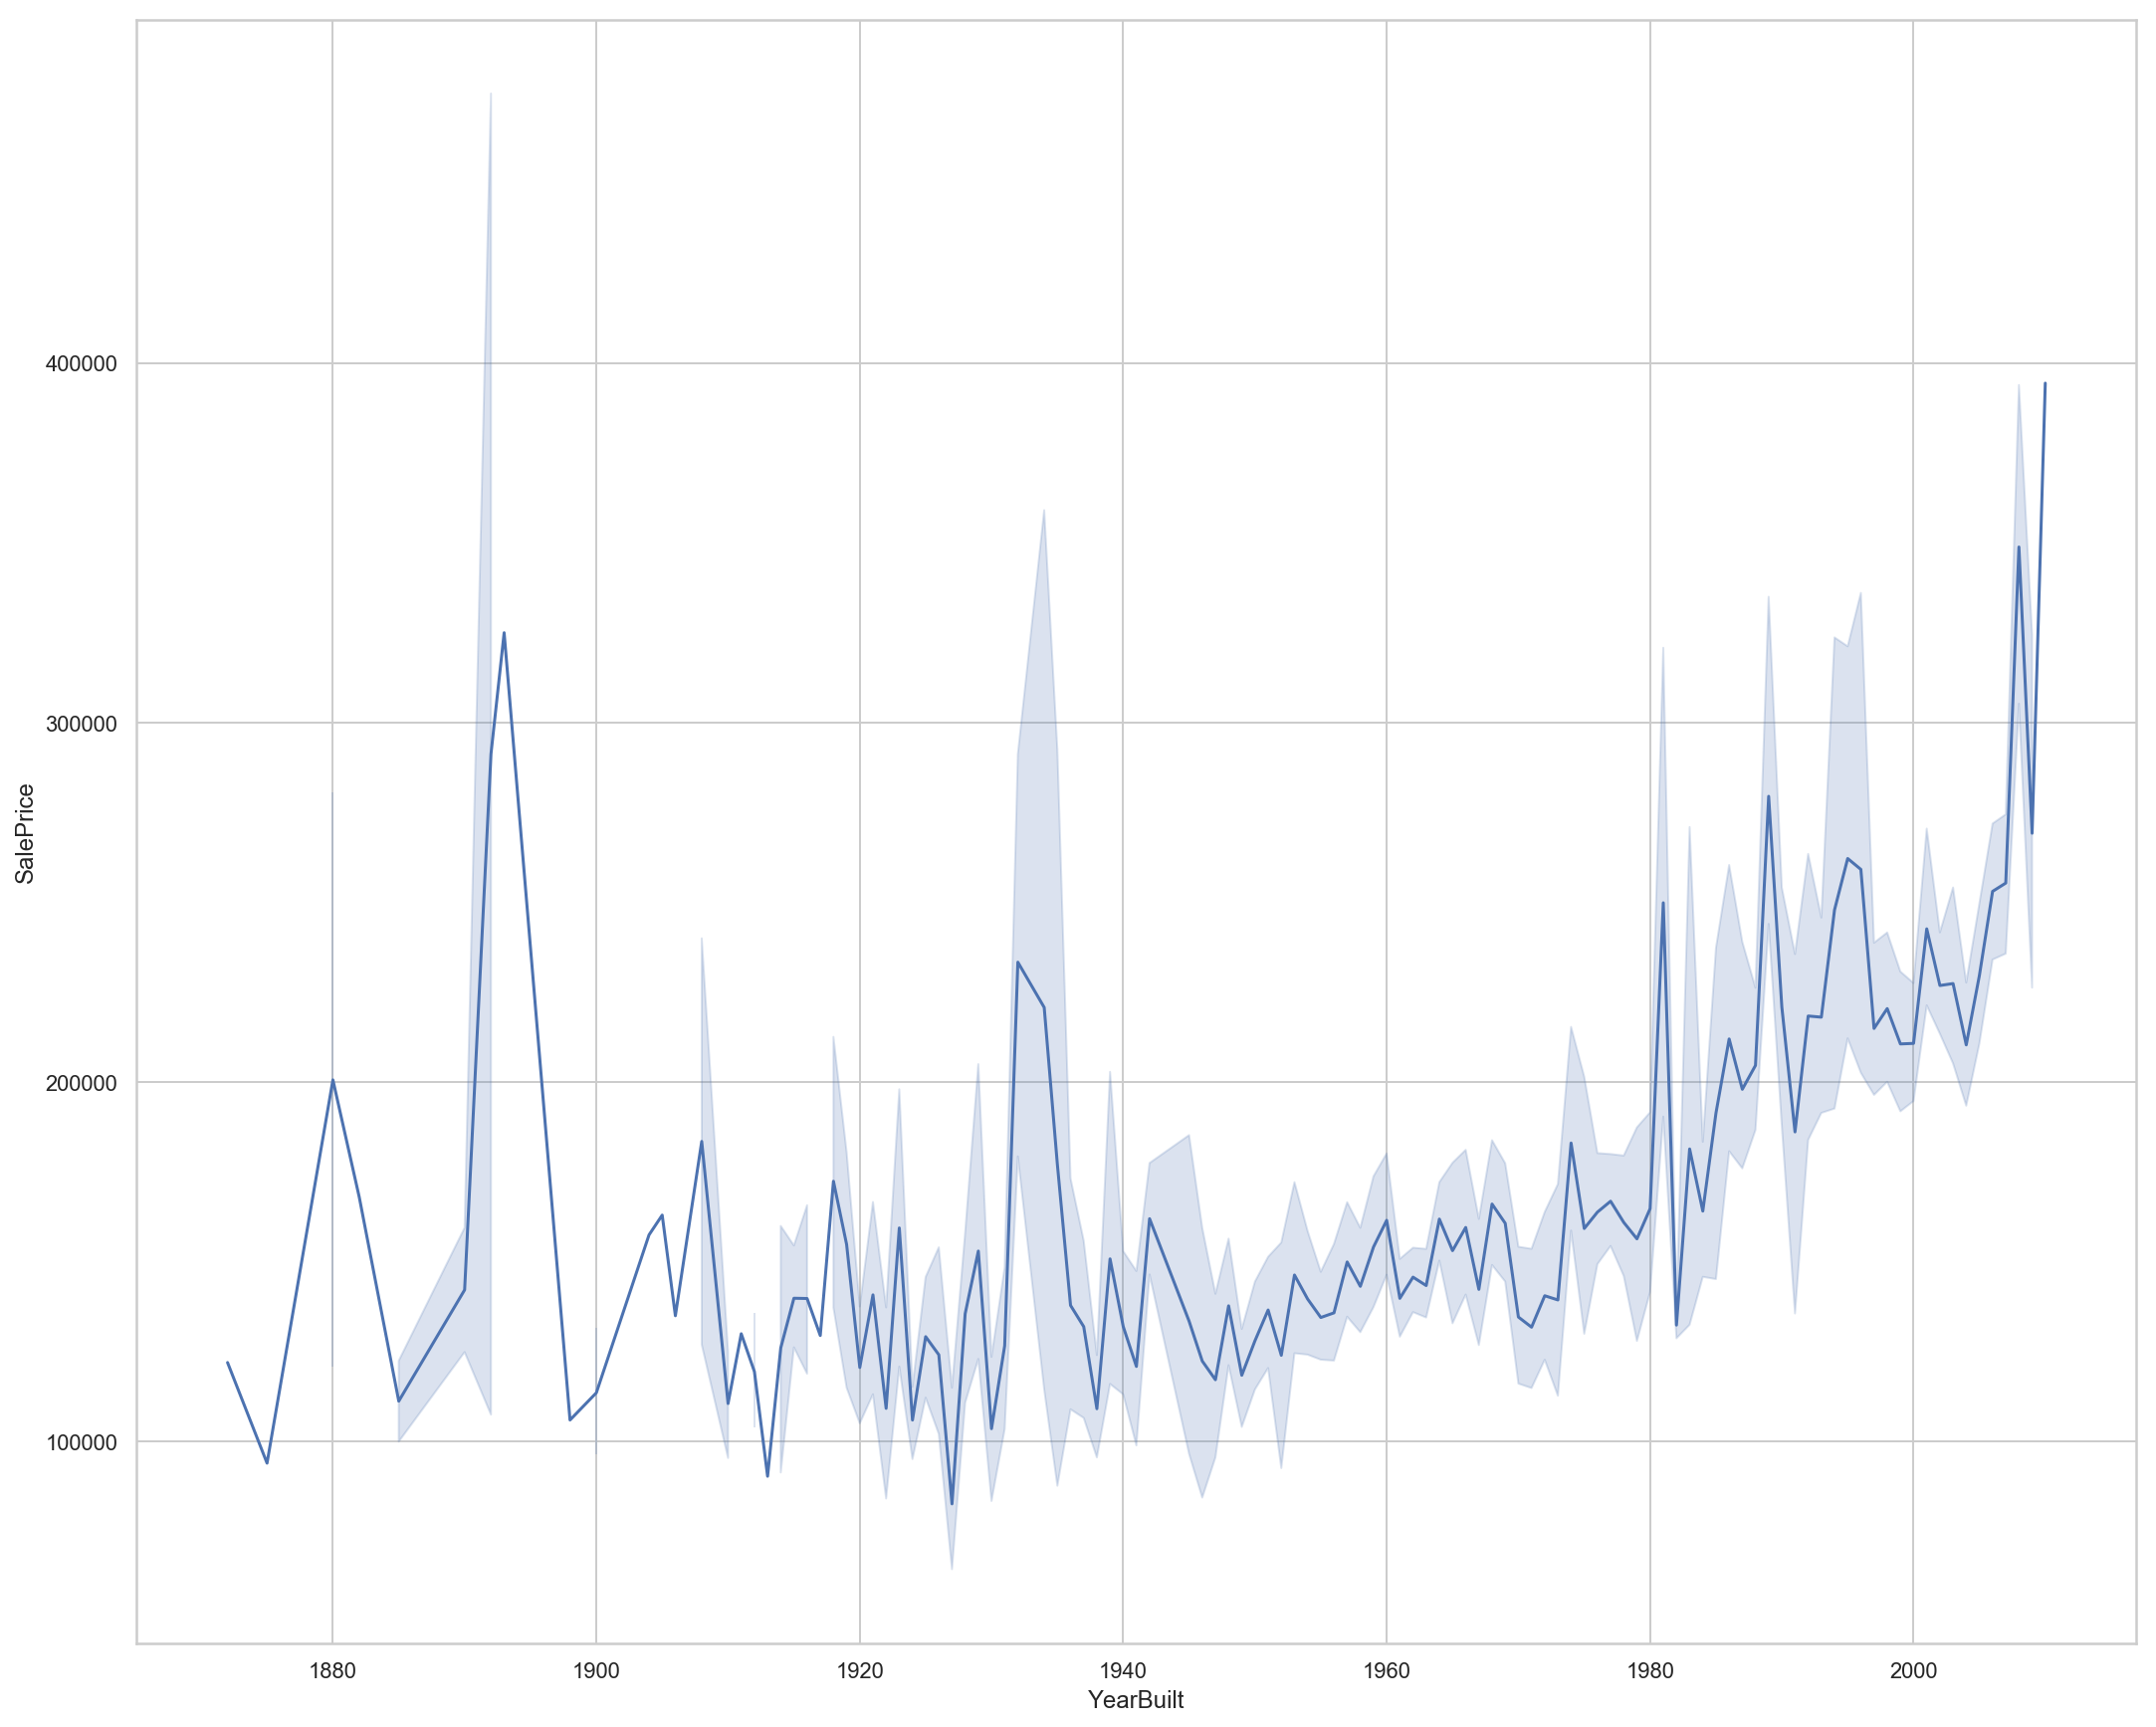

In [1482]:
plt.figure(figsize=(18,15))
ax = sns.lineplot(x="YearBuilt", y="SalePrice", dashes=False, data=Residential_house)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111]),
 <a list of 112 Text xticklabel objects>)

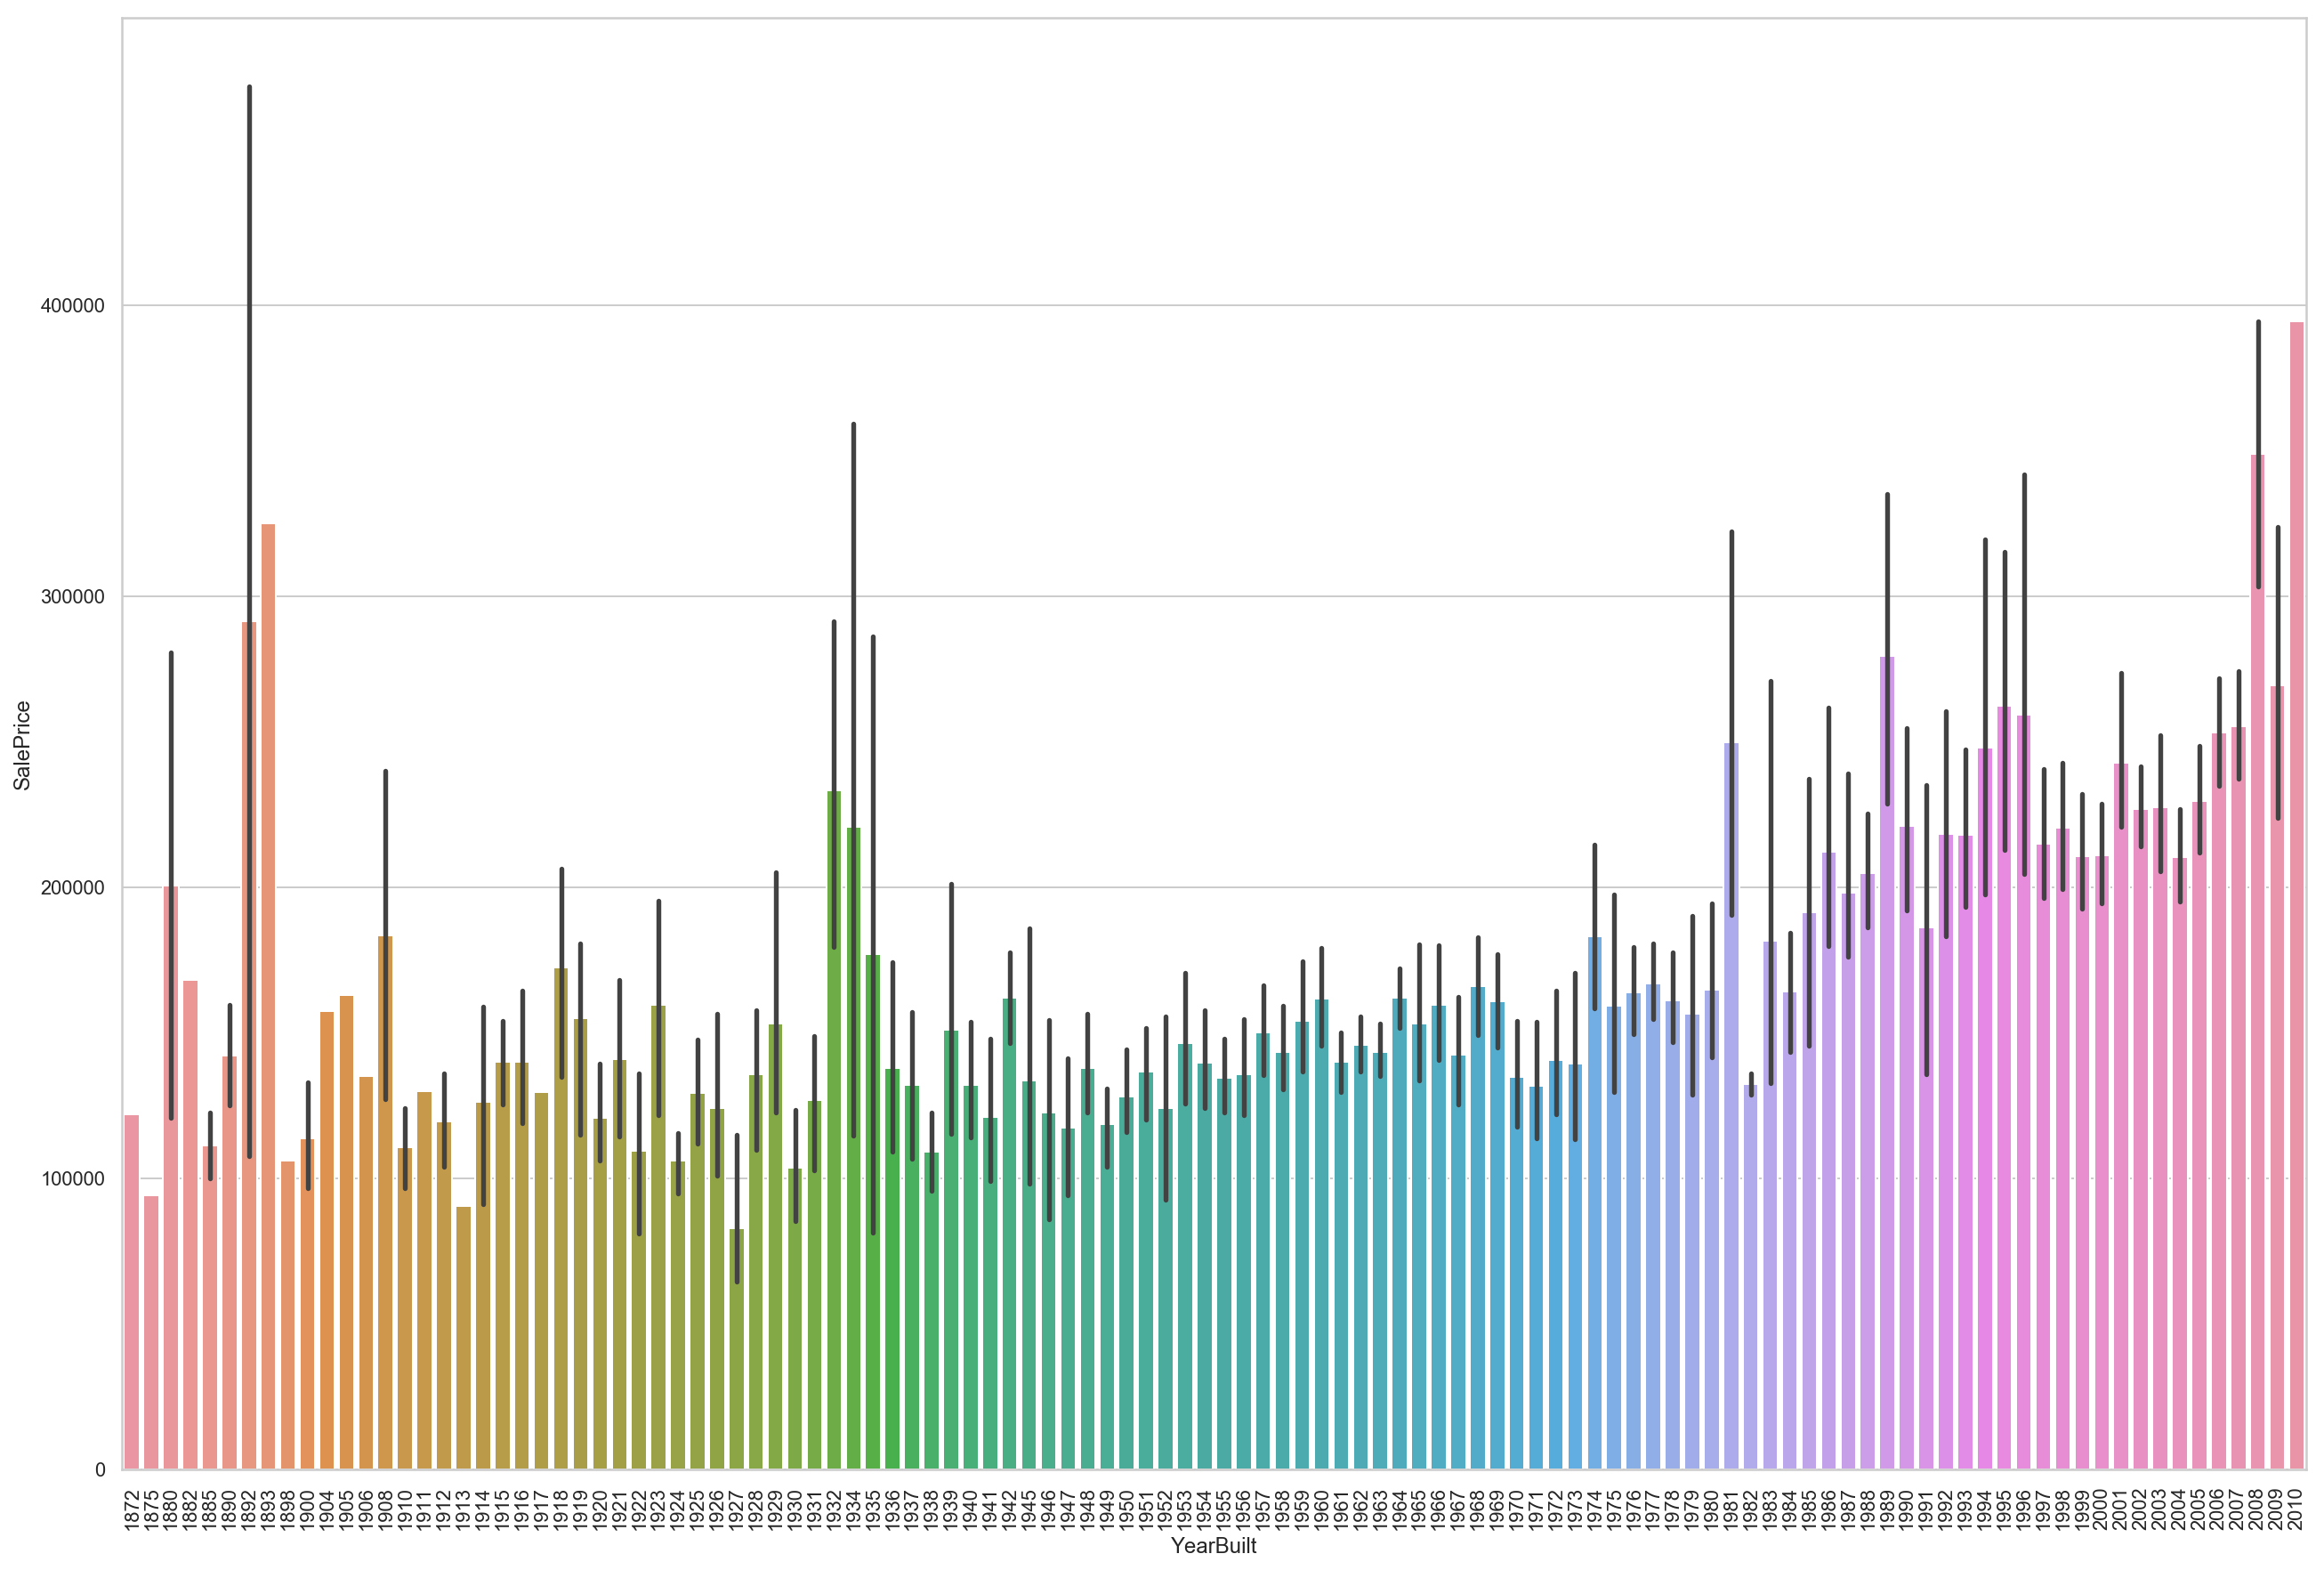

In [1483]:
plt.figure(figsize=(22,15))
sns.set(style="whitegrid")
ax = sns.barplot(x='YearBuilt', y='SalePrice', data=Residential_house)
plt.xticks(rotation=90)

In [1484]:
Residential_house['YrSold'].value_counts()

2009    336
2007    328
2006    312
2008    301
2010    172
Name: YrSold, dtype: int64

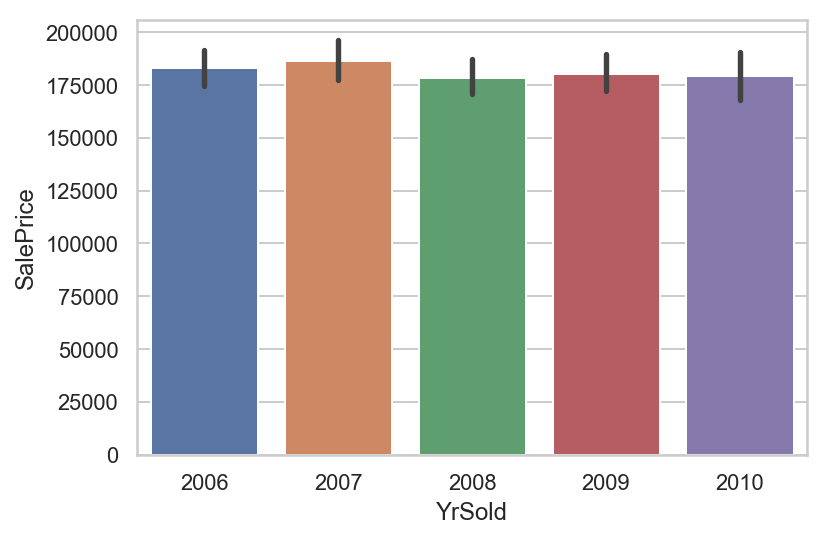

In [1485]:
sns.set(style="whitegrid")
ax = sns.barplot(x='YrSold', y='SalePrice', data=Residential_house)

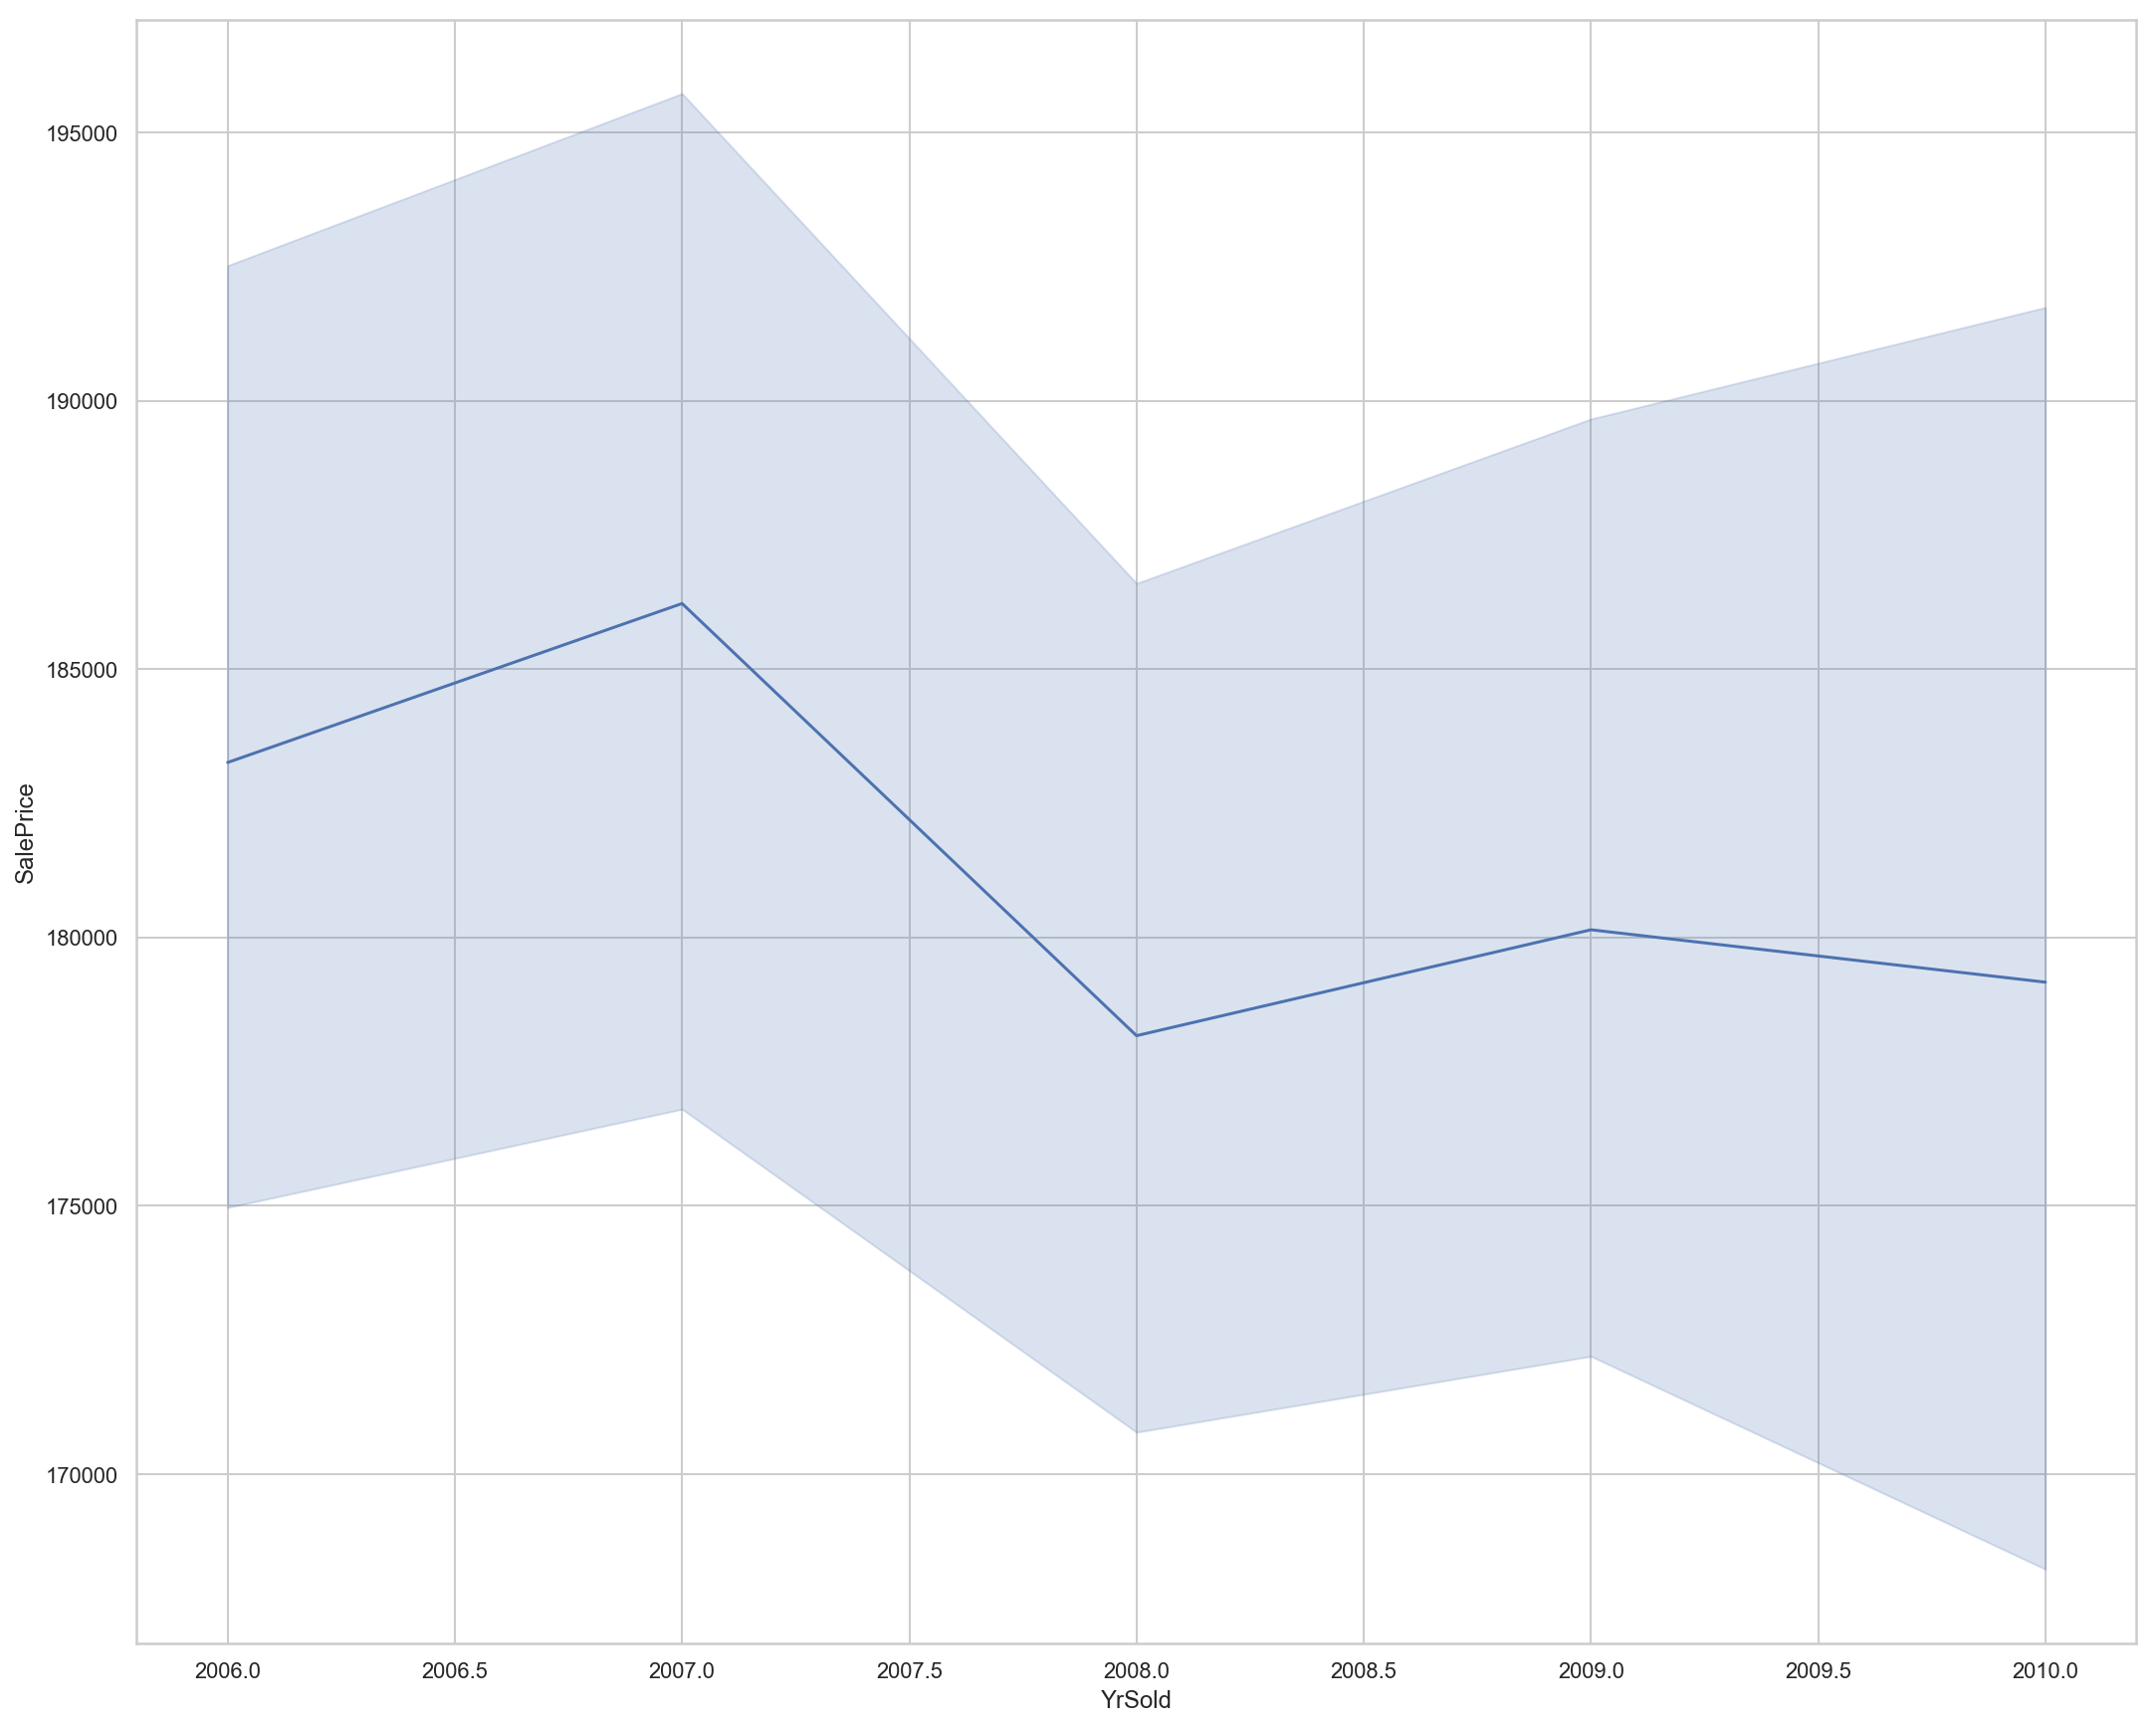

In [1486]:
plt.figure(figsize=(18,15))
ax = sns.lineplot(x="YrSold", y="SalePrice", data=Residential_house)

#### <b>General checking</b>

In [1487]:
Residential_house.filter(like='?', axis=0)

Empty DataFrame
Columns: [MSSubClass, MSZoning, LotFrontage, LotArea, Street, Alley, LotShape, LandContour, Utilities, LotConfig, LandSlope, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, TotalBsmtSF, Heating, HeatingQC, CentralAir, Electrical, FirstFlrSF, SecondFlrSF, LowQualFinSF, GrLivArea, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, PavedDrive, WoodDeckSF, OpenPorchSF, EnclosedPorch, ThreeSsnPorch, ScreenPorch, PoolArea, PoolQC, Fence, MiscFeature, MiscVal, MoSold, YrSold, SaleType, SaleCondition, SalePrice, TotalFullBath, TotalHalfBath, HouseAge, RenovationAge, GarageAge]
Index: []

[0 rows x 78 columns]

In [1488]:
Residential_house.filter(like='-', axis=0)

Empty DataFrame
Columns: [MSSubClass, MSZoning, LotFrontage, LotArea, Street, Alley, LotShape, LandContour, Utilities, LotConfig, LandSlope, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, TotalBsmtSF, Heating, HeatingQC, CentralAir, Electrical, FirstFlrSF, SecondFlrSF, LowQualFinSF, GrLivArea, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, PavedDrive, WoodDeckSF, OpenPorchSF, EnclosedPorch, ThreeSsnPorch, ScreenPorch, PoolArea, PoolQC, Fence, MiscFeature, MiscVal, MoSold, YrSold, SaleType, SaleCondition, SalePrice, TotalFullBath, TotalHalfBath, HouseAge, RenovationAge, GarageAge]
Index: []

[0 rows x 78 columns]

In [1489]:
Residential_house.filter(like='$', axis=0)

Empty DataFrame
Columns: [MSSubClass, MSZoning, LotFrontage, LotArea, Street, Alley, LotShape, LandContour, Utilities, LotConfig, LandSlope, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, TotalBsmtSF, Heating, HeatingQC, CentralAir, Electrical, FirstFlrSF, SecondFlrSF, LowQualFinSF, GrLivArea, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, PavedDrive, WoodDeckSF, OpenPorchSF, EnclosedPorch, ThreeSsnPorch, ScreenPorch, PoolArea, PoolQC, Fence, MiscFeature, MiscVal, MoSold, YrSold, SaleType, SaleCondition, SalePrice, TotalFullBath, TotalHalfBath, HouseAge, RenovationAge, GarageAge]
Index: []

[0 rows x 78 columns]

#### Checking correlation for numerical value columns

In [1490]:
quantitative = Residential_house[[f for f in Residential_house.columns if Residential_house.dtypes[f] != 'object']]

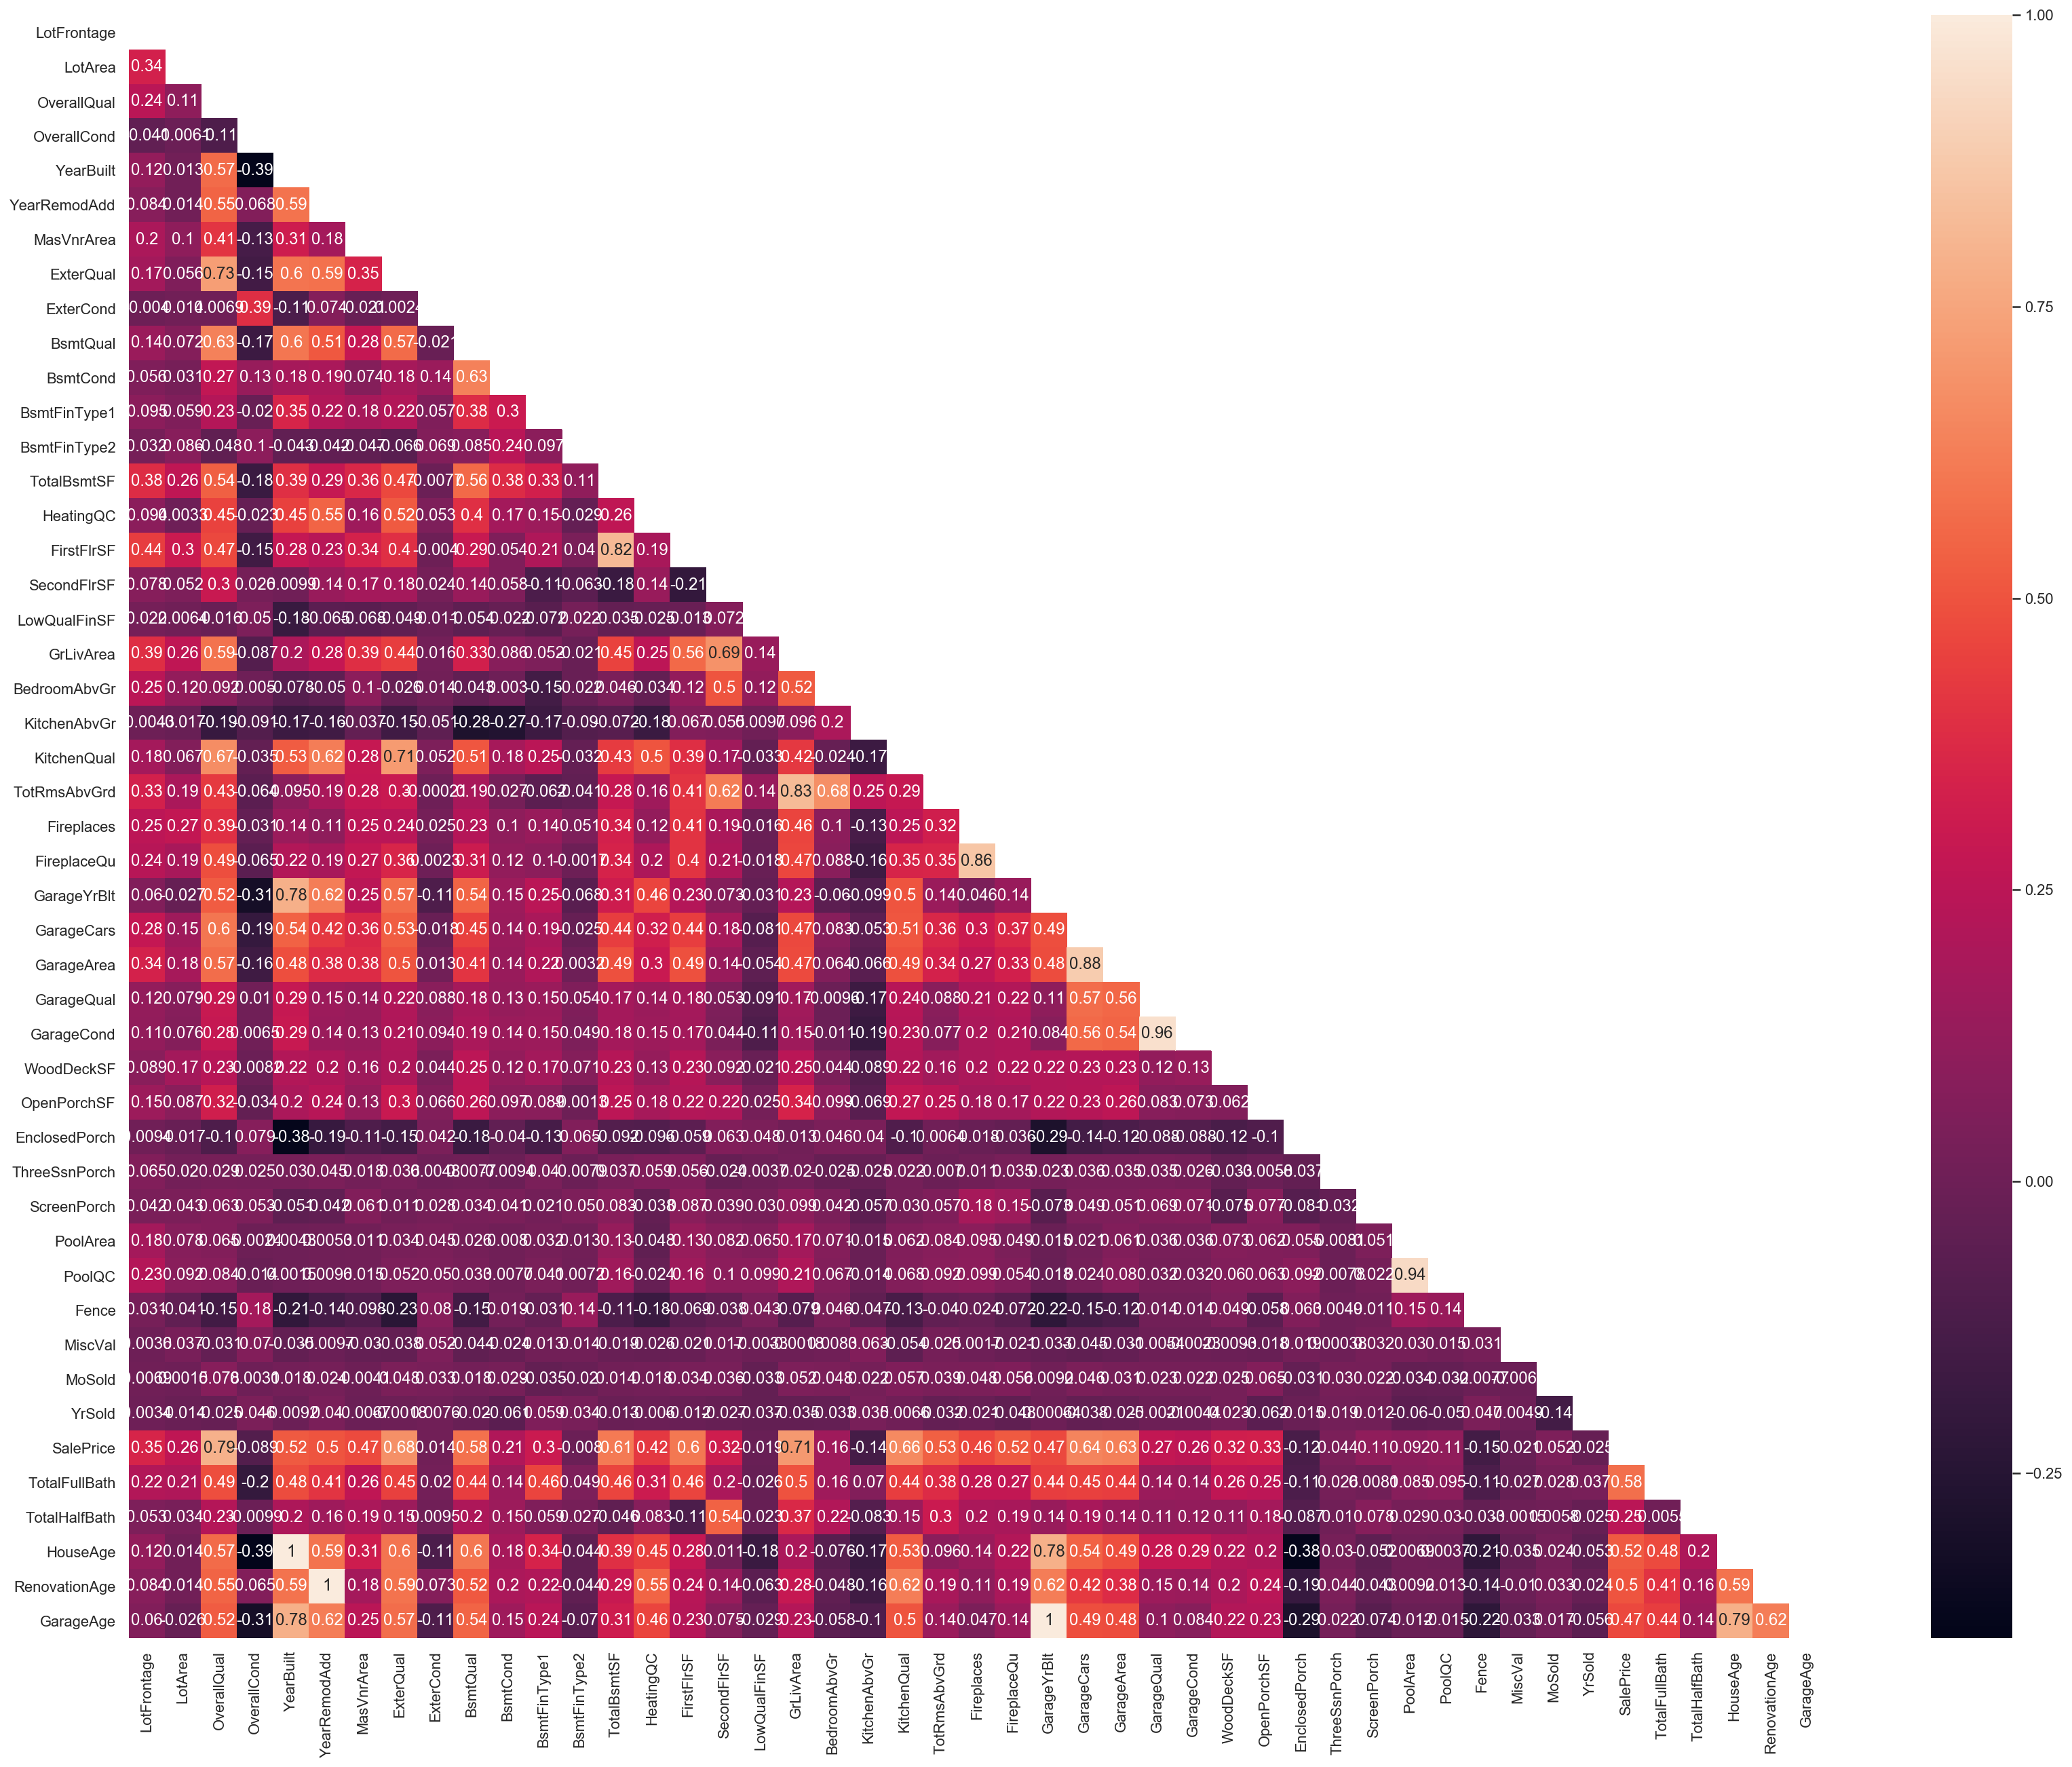

In [1491]:
#quantitative.drop(['Id','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath'],
#                 axis=1,inplace=True)
plt.figure(figsize=(28,22))
# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(quantitative.corr(), dtype = np.bool )
mask[np.triu_indices_from(mask)] = True
# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
sns.heatmap(quantitative.corr( ), mask=mask, annot=True )


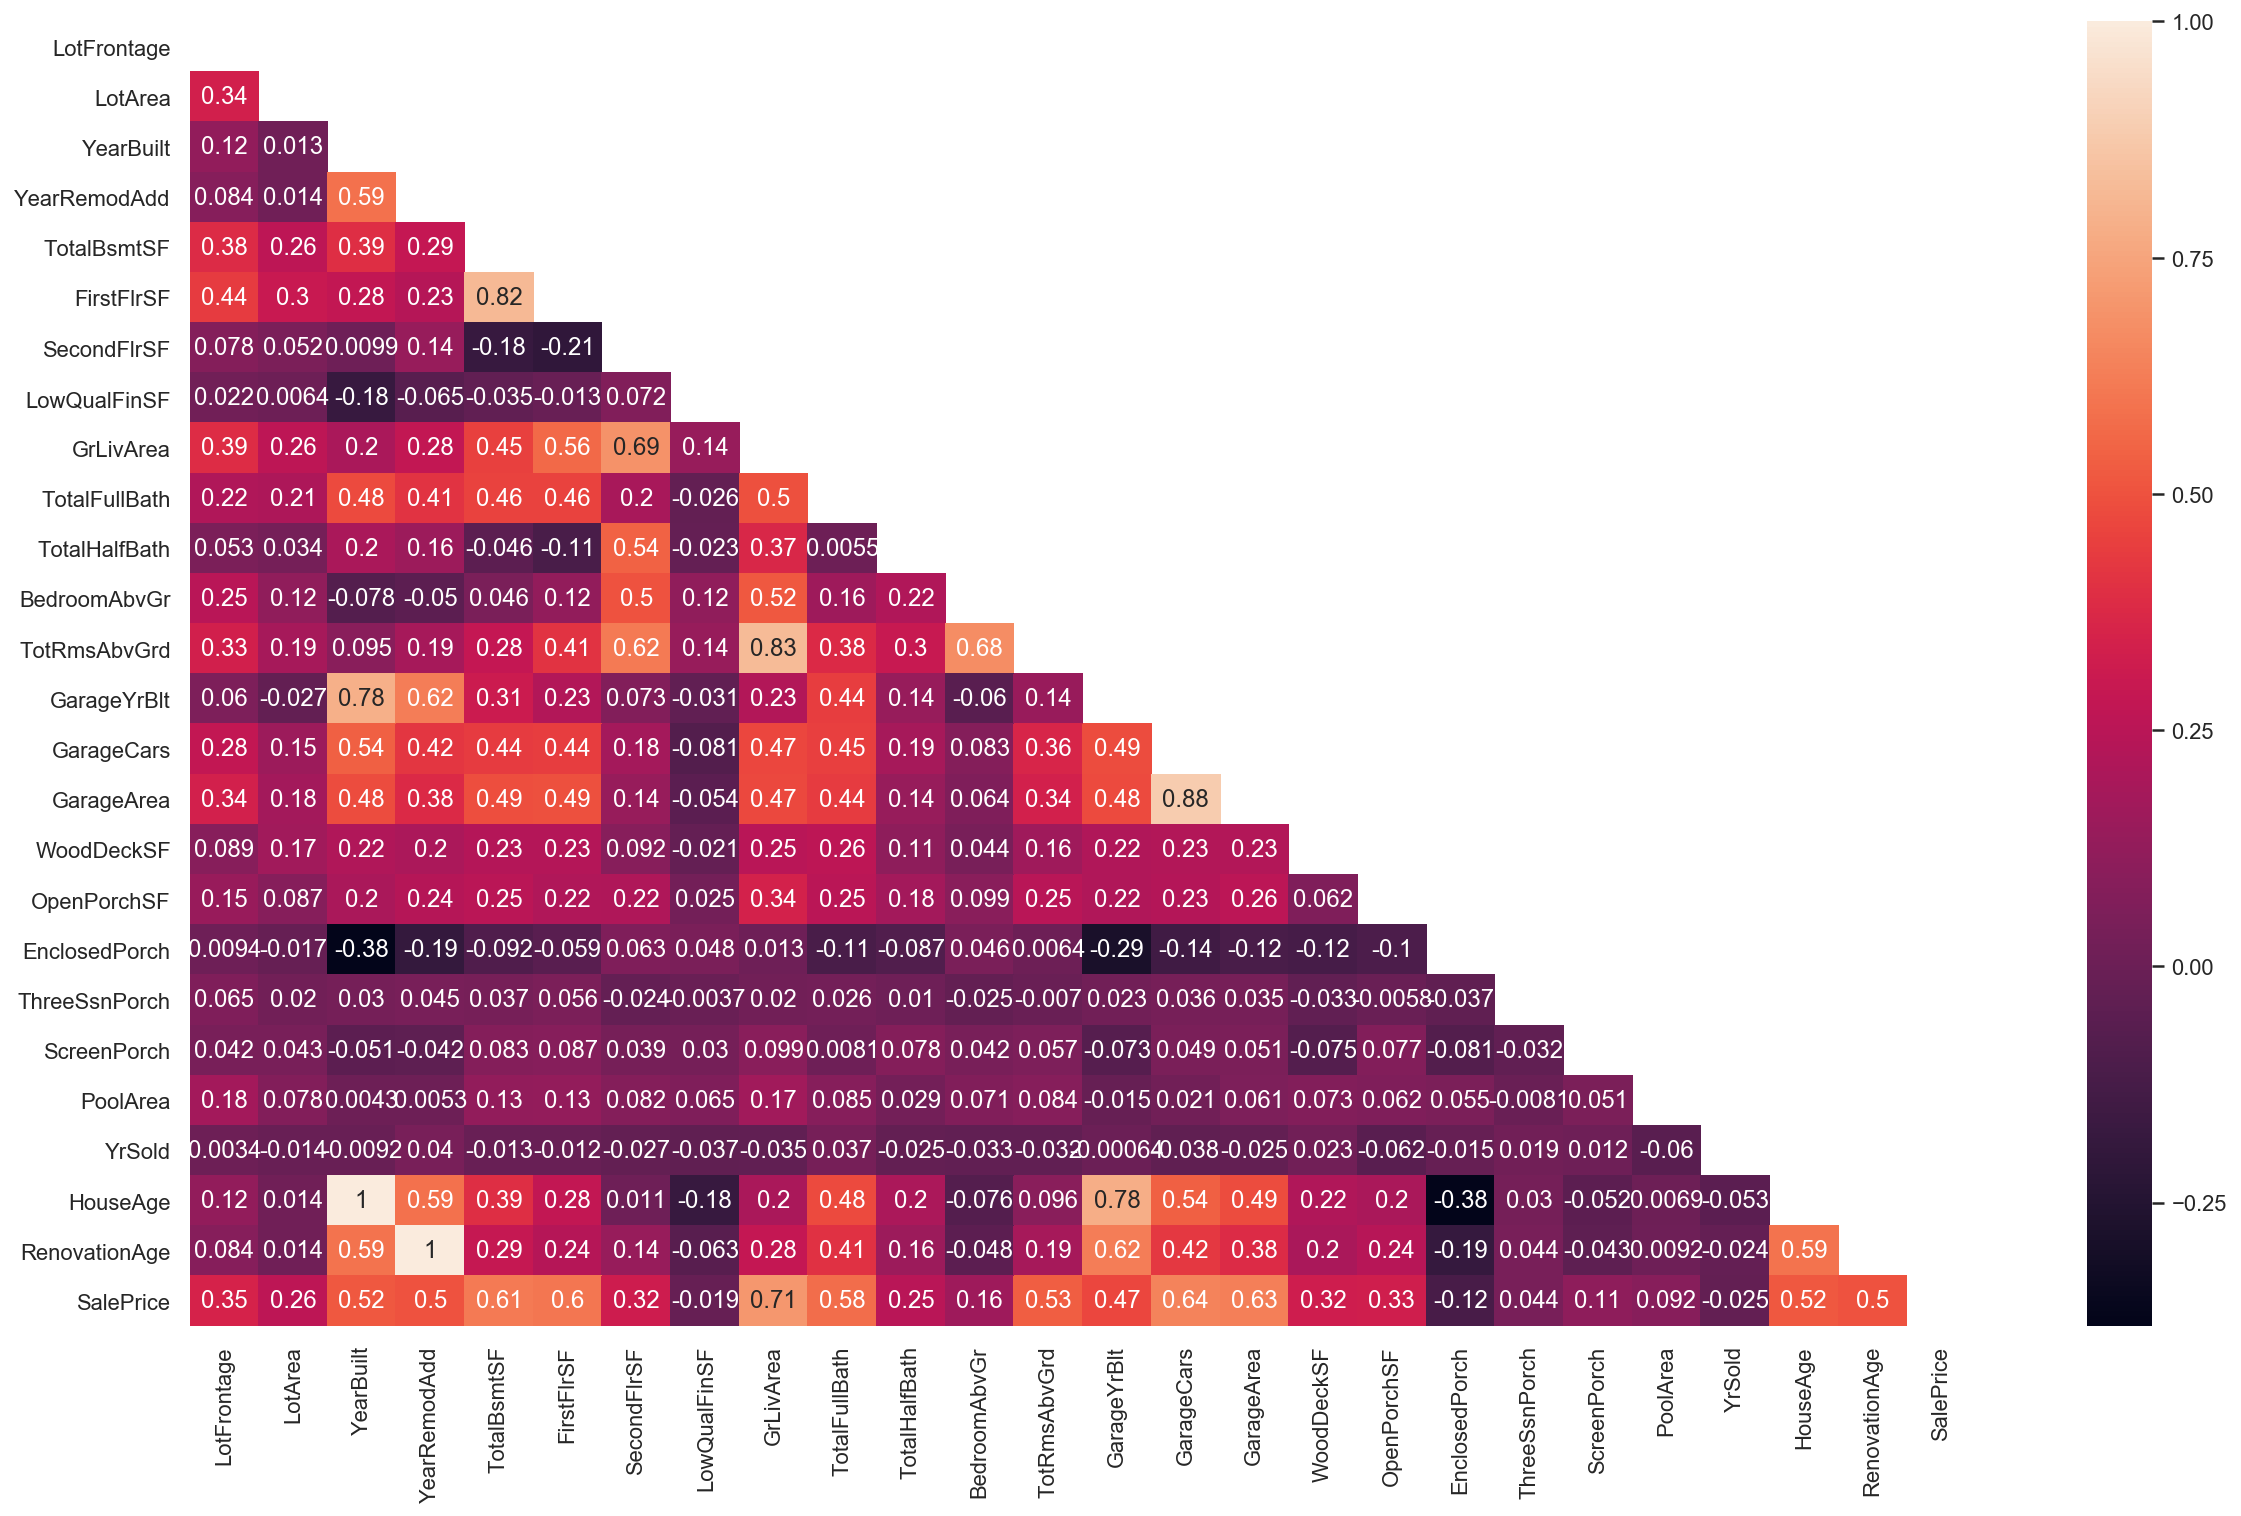

In [1492]:
X = Residential_house[['MSSubClass','MSZoning','LotFrontage','LotArea','Street','Alley'
                       ,'LotShape','LandContour','LotConfig','LandSlope','Neighborhood'
                       ,'Condition1','Condition2','BldgType','YearBuilt','YearRemodAdd'
                       ,'Foundation','TotalBsmtSF','FirstFlrSF','SecondFlrSF','LowQualFinSF'
                       ,'GrLivArea','TotalFullBath','TotalHalfBath','BedroomAbvGr','TotRmsAbvGrd'
                       ,'Functional','GarageYrBlt','GarageCars','GarageArea','WoodDeckSF'
                       ,'OpenPorchSF','EnclosedPorch','ThreeSsnPorch','ScreenPorch','PoolArea','MiscFeature'
                       ,'YrSold','HouseAge','RenovationAge','SaleType','SaleCondition','SalePrice']]

plt.figure(figsize=(20,12))
# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like( X.corr(), dtype = np.bool )
mask[np.triu_indices_from(mask)] = True
# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
sns.heatmap( X.corr( ), mask=mask, annot=True )


#### Removing Outliers of SalePrice

In [1493]:
# Computing IQR to handle outliers - still under progress
#temp = Residential_house.copy()
#temp['SalePrice'] = (temp['SalePrice']-np.mean(temp['SalePrice']))/np.std(temp['SalePrice'])
#temp['LotArea'] = (temp['LotArea']-np.mean(temp['LotArea']))/np.std(temp['LotArea'])
Q1 = Residential_house['SalePrice'].quantile(0.25)
Q3 = Residential_house['SalePrice'].quantile(0.75)
IQR = Q3 - Q1

Residential_house = Residential_house.query('(@Q1 - 1.5 * @IQR) <= SalePrice <= (@Q3 + 1.5 * @IQR)')
print("Before removing outliers : {}".format(house.shape))
print("After removing outliers : {}".format(Residential_house.shape))

Before removing outliers : (1460, 81)
After removing outliers : (1388, 78)


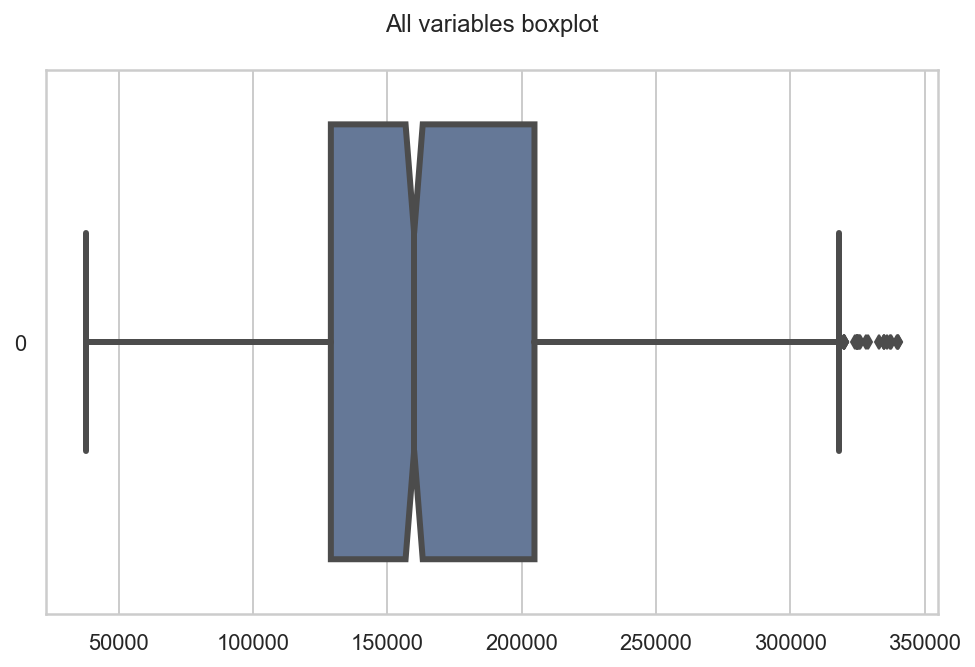

In [1494]:
# Checking outliers for Saleprice
fig = plt.figure(figsize=(8,5))
ax = fig.gca()
ax = sns.boxplot(data=Residential_house['SalePrice'], orient='h', fliersize=5, linewidth=3, notch=True, saturation=0.5, ax=ax)
ax.set_title('All variables boxplot\n')
plt.show()

### Assigning non-renovateable and renovateable features

In [1495]:
X_nonrenovateable = Residential_house[['MSSubClass','MSZoning','LotFrontage','LotArea','Street','Alley'
                                       ,'LotShape','LandContour','LotConfig','LandSlope','Neighborhood'
                                       ,'Condition1','Condition2','BldgType','HouseStyle','YearBuilt'
                                       ,'YearRemodAdd','RoofStyle','Foundation','BsmtExposure','TotalBsmtSF'
                                       ,'Heating','FirstFlrSF','SecondFlrSF','LowQualFinSF','GrLivArea'
                                       ,'TotalFullBath','TotalHalfBath','BedroomAbvGr','TotRmsAbvGrd'
                                       ,'Functional','GarageType','GarageAge','GarageCars','GarageArea'
                                       ,'WoodDeckSF','OpenPorchSF','EnclosedPorch','ThreeSsnPorch'
                                       ,'ScreenPorch','PoolArea','MiscFeature','YrSold','HouseAge'
                                       ,'RenovationAge','SaleType','SaleCondition']]

X_renovatable = Residential_house[Residential_house.columns.difference(X_nonrenovateable.columns)]

In [1496]:
# X = pd.get_dummies(X_nonrenovateable,columns=['MSSubClass','MSZoning','Street','Alley','LotShape',
#                                           'LandContour','LotConfig','LandSlope','Neighborhood',
#                                           'Condition1','Condition2','BldgType','HouseStyle','RoofStyle',
#                                           'Foundation','Heating','Functional','GarageType','MiscFeature',
#                                           'SaleType','SaleCondition'])
# y = Residential_house['SalePrice']

In [1497]:
# list(X.columns)

In [1498]:
Residential_house.MSZoning.value_counts()

RL    1092
RM     216
FV      64
RH      16
Name: MSZoning, dtype: int64

In [1499]:
# dummy_columns = ['MSSubClass','MSZoning','Street','Alley','LotShape',
#                 'LandContour','LotConfig','LandSlope','Neighborhood',
#                 'Condition1','Condition2','BldgType','HouseStyle','RoofStyle',
#                 'Foundation','Heating','Functional','GarageType','MiscFeature',
#                 'SaleType','SaleCondition']
# for dummy_column in dummy_columns:
#     for x_column in X.columns:
#         if dummy_column in x_column:
#             print('X_column name : ',x_column)
#             print(Residential_house[dummy_column].value_counts(ascending=True))#.index[0])
#             break
# #             X.drop(drop_col_name, axis=1, inplace=True)
# #             #print(column,":")
# #             print(Residential_house[temp].value_counts(ascending=True))
# #             print("Drop column : {}".format(drop_col_name))
            
# # for column in dummy_columns:
# #     if column in X.columns:
        
# #         df = df[df['A'].str.contains('AV', regex=False, case=False, na=False)]

In [1500]:
# X includes non-renovateable features.

formula = 'SalePrice ~ ' + " + ".join(X_nonrenovateable.columns) + ' - 1'

print(formula)

# Patsy will drop the dummy column in alphabetically 
y, X = patsy.dmatrices(formula, data=Residential_house, return_type='dataframe')

SalePrice ~ MSSubClass + MSZoning + LotFrontage + LotArea + Street + Alley + LotShape + LandContour + LotConfig + LandSlope + Neighborhood + Condition1 + Condition2 + BldgType + HouseStyle + YearBuilt + YearRemodAdd + RoofStyle + Foundation + BsmtExposure + TotalBsmtSF + Heating + FirstFlrSF + SecondFlrSF + LowQualFinSF + GrLivArea + TotalFullBath + TotalHalfBath + BedroomAbvGr + TotRmsAbvGrd + Functional + GarageType + GarageAge + GarageCars + GarageArea + WoodDeckSF + OpenPorchSF + EnclosedPorch + ThreeSsnPorch + ScreenPorch + PoolArea + MiscFeature + YrSold + HouseAge + RenovationAge + SaleType + SaleCondition - 1


In [1501]:
X.columns

Index(['MSSubClass[1-1/2 STORY - UNFINISHED ALL AGES]',
       'MSSubClass[1-1/2 STORY FINISHED ALL AGES]',
       'MSSubClass[1-STORY 1945 & OLDER]',
       'MSSubClass[1-STORY 1946 & NEWER ALL STYLES]',
       'MSSubClass[1-STORY PUD (Planned Unit Development) - 1946 & NEWER]',
       'MSSubClass[1-STORY W/FINISHED ATTIC ALL AGES]',
       'MSSubClass[2 FAMILY CONVERSION - ALL STYLES AND AGES]',
       'MSSubClass[2-1/2 STORY ALL AGES]', 'MSSubClass[2-STORY 1945 & OLDER]',
       'MSSubClass[2-STORY 1946 & NEWER]',
       ...
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
       'ThreeSsnPorch', 'ScreenPorch', 'PoolArea', 'YrSold', 'HouseAge',
       'RenovationAge'],
      dtype='object', length=156)

In [1502]:
len(X.columns)

156

### <b>Splitting Data and Standardizing X_train dataset</b>

In [1503]:
X['YrSold'].dtypes

dtype('float64')

In [1504]:
train_dataset = X[X['YrSold']!=2010]
print(train_dataset.shape)

(1222, 156)


In [1505]:
test_dataset = X[X['YrSold']==2010]
test_dataset.shape

(166, 156)

In [1506]:
X_y = pd.concat([X,y],axis=1)
X_y.head()

MSSubClass[1-1/2 STORY - UNFINISHED ALL AGES]  \
0                                            0.0   
1                                            0.0   
2                                            0.0   
3                                            0.0   
4                                            0.0   

   MSSubClass[1-1/2 STORY FINISHED ALL AGES]  \
0                                        0.0   
1                                        0.0   
2                                        0.0   
3                                        0.0   
4                                        0.0   

   MSSubClass[1-STORY 1945 & OLDER]  \
0                               0.0   
1                               0.0   
2                               0.0   
3                               0.0   
4                               0.0   

   MSSubClass[1-STORY 1946 & NEWER ALL STYLES]  \
0                                          0.0   
1                                          1.0   
2                                          0.0   
3                                          0.0   
4                                          0.0   

   MSSubClass[1-STORY PUD (Planned Unit Development) - 1946 & NEWER]  \
0                                                0.0                   
1                                                0.0                   
2                                                0.0                   
3                                                0.0                   
4                                                0.0                   

   MSSubClass[1-STORY W/FINISHED ATTIC ALL AGES]  \
0                                            0.0   
1                                            0.0   
2                                            0.0   
3                                            0.0   
4                                            0.0   

   MSSubClass[2 FAMILY CONVERSION - ALL STYLES AND AGES]  \
0                                                0.0       
1                                                0.0       
2                                                0.0       
3                                                0.0       
4                                                0.0       

   MSSubClass[2-1/2 STORY ALL AGES]  MSSubClass[2-STORY 1945 & OLDER]  \
0                               0.0                               0.0   
1                               0.0                               0.0   
2                               0.0                               0.0   
3                               0.0                               1.0   
4                               0.0                               0.0   

   MSSubClass[2-STORY 1946 & NEWER]    ...      WoodDeckSF  OpenPorchSF  \
0                               1.0    ...             0.0         61.0   
1                               0.0    ...           298.0          0.0   
2                               1.0    ...             0.0         42.0   
3                               0.0    ...             0.0         35.0   
4                               1.0    ...           192.0         84.0   

   EnclosedPorch  ThreeSsnPorch  ScreenPorch  PoolArea  YrSold  HouseAge  \
0            0.0            0.0          0.0       0.0  2008.0      -5.0   
1            0.0            0.0          0.0       0.0  2007.0     -31.0   
2            0.0            0.0          0.0       0.0  2008.0      -7.0   
3          272.0            0.0          0.0       0.0  2006.0     -91.0   
4            0.0            0.0          0.0       0.0  2008.0      -8.0   

   RenovationAge  SalePrice  
0           -5.0   208500.0  
1          -31.0   181500.0  
2           -6.0   223500.0  
3          -36.0   140000.0  
4           -8.0   250000.0  

[5 rows x 157 columns]

In [1507]:
# Splitting the data to train and test
#X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)
X_y = pd.concat([X,y],axis=1)
train_dataset = X_y[X_y['YrSold']!=2010]
test_dataset = X_y[X_y['YrSold']==2010]
X_train = train_dataset[train_dataset.columns.difference(['SalePrice'])].values
y_train = train_dataset['SalePrice'].values
X_test = test_dataset[test_dataset.columns.difference(['SalePrice'])].values
y_test = test_dataset['SalePrice'].values

# Instantiate StandardScaler()
ss = StandardScaler()

# Use the "fit_transform" function to standardize the X design matrix.
Xs_train = ss.fit_transform(X_train)

In [1508]:
## Checking the columns
train_dataset.columns.difference(['SalePrice'])

Index(['Alley[T.NA]', 'Alley[T.Pave]', 'BedroomAbvGr', 'BldgType[T.2fmCon]',
       'BldgType[T.Duplex]', 'BldgType[T.TwnhsE]', 'BldgType[T.Twnhs]',
       'BsmtExposure[T.Gd]', 'BsmtExposure[T.Mn]', 'BsmtExposure[T.NA]',
       ...
       'Street[T.Pave]', 'ThreeSsnPorch', 'TotRmsAbvGrd', 'TotalBsmtSF',
       'TotalFullBath', 'TotalHalfBath', 'WoodDeckSF', 'YearBuilt',
       'YearRemodAdd', 'YrSold'],
      dtype='object', length=156)

In [1509]:
## Checking the data consistency visually after train test split
X_train[4]

array([ 1.000e+00,  0.000e+00,  4.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  1.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        1.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  1.145e+03,  0.000e+00,  1.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  1.000e+00, -8.000e+00,
        8.360e+02,  3.000e+00,  1.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  2.198e+03,  1.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00, -8.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  1.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  1.000e+00,
        0.000e+00,  0.000e+00,  1.426e+04,  0.000e+00,  1.000e+00,
        0.000e+00,  0.000e+00,  8.400e+01,  0.000e+00,  0.000e

In [1510]:
## Checking the data consistency visually after train test split
train_dataset[train_dataset.columns.difference(['SalePrice'])].head()

Alley[T.NA]  Alley[T.Pave]  BedroomAbvGr  BldgType[T.2fmCon]  \
0          1.0            0.0           3.0                 0.0   
1          1.0            0.0           3.0                 0.0   
2          1.0            0.0           3.0                 0.0   
3          1.0            0.0           3.0                 0.0   
4          1.0            0.0           4.0                 0.0   

   BldgType[T.Duplex]  BldgType[T.TwnhsE]  BldgType[T.Twnhs]  \
0                 0.0                 0.0                0.0   
1                 0.0                 0.0                0.0   
2                 0.0                 0.0                0.0   
3                 0.0                 0.0                0.0   
4                 0.0                 0.0                0.0   

   BsmtExposure[T.Gd]  BsmtExposure[T.Mn]  BsmtExposure[T.NA]   ...    \
0                 0.0                 0.0                 0.0   ...     
1                 1.0                 0.0                 0.0   ...     
2                 0.0                 1.0                 0.0   ...     
3                 0.0                 0.0                 0.0   ...     
4                 0.0                 0.0                 0.0   ...     

   Street[T.Pave]  ThreeSsnPorch  TotRmsAbvGrd  TotalBsmtSF  TotalFullBath  \
0             1.0            0.0           8.0        856.0            3.0   
1             1.0            0.0           6.0       1262.0            2.0   
2             1.0            0.0           6.0        920.0            3.0   
3             1.0            0.0           7.0        756.0            2.0   
4             1.0            0.0           9.0       1145.0            3.0   

   TotalHalfBath  WoodDeckSF  YearBuilt  YearRemodAdd  YrSold  
0            1.0         0.0     2003.0        2003.0  2008.0  
1            1.0       298.0     1976.0        1976.0  2007.0  
2            1.0         0.0     2001.0        2002.0  2008.0  
3            0.0         0.0     1915.0        1970.0  2006.0  
4            1.0       192.0     2000.0        2000.0  2008.0  

[5 rows x 156 columns]

### <b>Using Multi-Linear Regression for model</b>

In [1511]:
# Instantiate Linear Regression Model
linreg = LinearRegression()

# Fit the model on the train dataset of X and Y.
linreg.fit(Xs_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [1512]:
# Getting coefficients of the model
linreg.coef_

array([ 5.96915043e+02, -1.95604821e+02, -1.96995470e+03,  4.40765184e+02,
       -6.03365742e+15, -1.79313463e+03, -2.07346489e+03,  2.77810196e+03,
       -1.34488077e+03, -3.18493750e+03, -3.20401562e+03, -4.13906250e+02,
        3.91831250e+03,  5.04671875e+02,  2.32633594e+03, -5.93968750e+02,
        1.34381250e+03, -1.02687500e+02,  1.77009375e+03, -4.71250000e+01,
        2.33881250e+03,  3.86876562e+03, -6.47421875e+03, -5.99881853e+15,
        5.97500000e+02,  9.50710938e+02,  1.13012500e+03, -6.89933140e+15,
        2.14312500e+02,  1.58793750e+03, -1.11533594e+03, -5.55875000e+02,
       -8.66687500e+02, -1.32403125e+03, -2.96312500e+02, -4.24937500e+02,
       -3.61812500e+02, -2.33091406e+03,  3.84887500e+03, -3.29000000e+03,
        1.75937500e+03,  9.08050000e+03,  1.70800000e+04,  3.57195312e+03,
        7.86775000e+03,  1.73221875e+03,  1.36453750e+04,  1.04471250e+04,
        9.30106423e+15,  2.20612500e+03,  1.42937500e+03,  1.25625000e+01,
       -2.99250000e+02,  

In [1513]:
# Getting intercept of the model
linreg.intercept_

171271.33326310688

In [1514]:
# Use the KFold class to add more options.
kf_shuffle = KFold(n_splits=10,shuffle=True, random_state=42) 

#The function cross_val_score returns the  𝑅2  for each testing set.
mlr_scores = cross_val_score(linreg, Xs_train, y_train, cv=kf_shuffle)

print("R2 scores for 10 folds : {}".format(mlr_scores))
print("R2 mean : {}, R2 std : {}".format(np.mean(mlr_scores), np.std(mlr_scores)))

R2 scores for 10 folds : [-2.72189129e+19 -1.18449311e+02  7.71571802e-01  8.28971251e-01
 -9.34489497e+19 -3.41670645e+25 -1.90358182e+21 -2.03561148e+22
 -4.04111427e+24 -2.69219341e+25]
R2 mean : -6.515249328249166e+24, R2 std : 1.218205696761792e+25


In [1515]:
# With training data set
predictions = linreg.predict(Xs_train)
print("RMSE for whole train dataset:", np.sqrt(metrics.mean_squared_error(y_train, predictions)))

RMSE for whole train dataset: 20740.486359153212


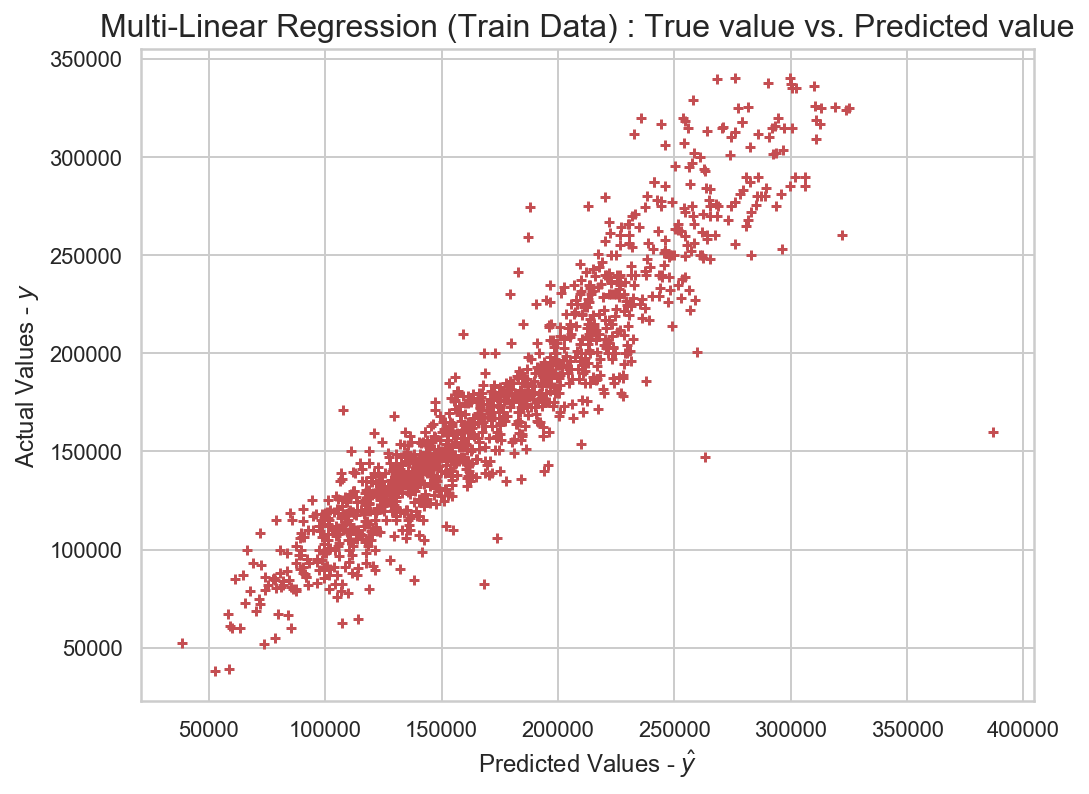

In [1516]:
# Plot the model with training dataset
plt.figure(figsize=(8,6))
plt.title('Multi-Linear Regression (Train Data) : True value vs. Predicted value',fontsize=16)
plt.scatter(predictions, y_train, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicted Values - $\hat{y}$")
plt.ylabel("Actual Values - $y$")
plt.show();

In [1517]:
# With test data set
Xs_test = ss.fit_transform(X_test)
predictions = linreg.predict(Xs_test)
print("RMSE for whole test dataset:", np.sqrt(metrics.mean_squared_error(y_test, predictions)))

RMSE for whole test dataset: 1.012289969494166e+16


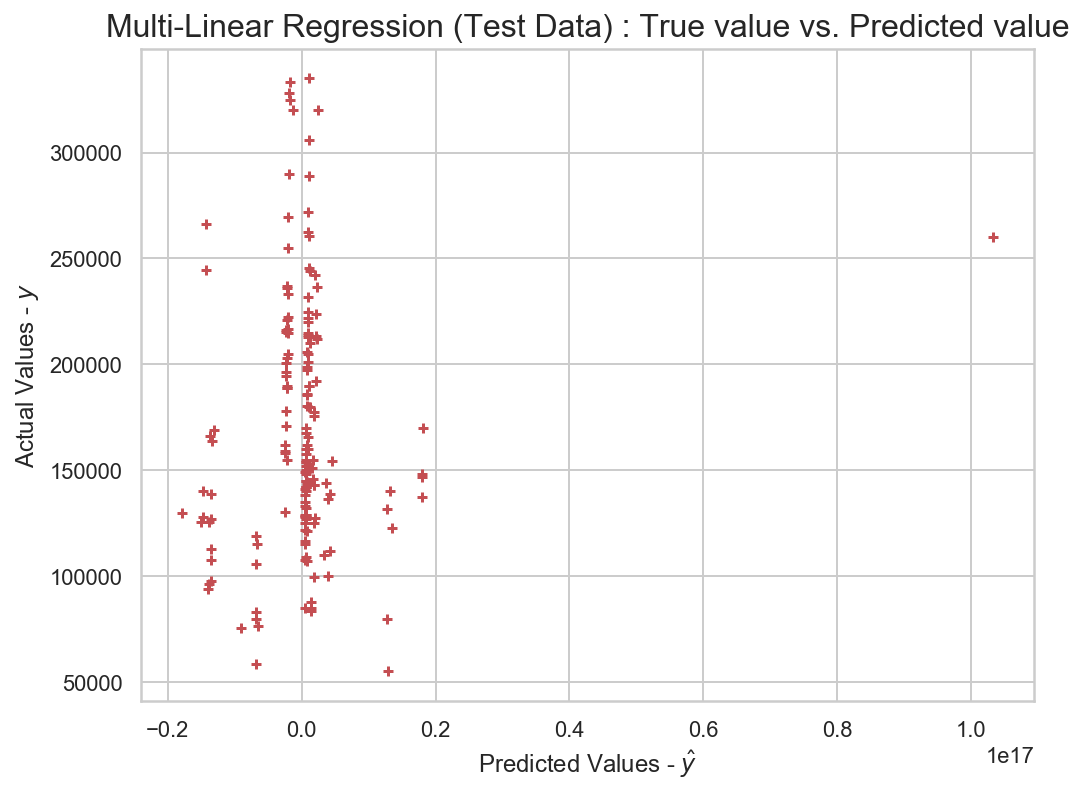

In [1518]:
# Plot the model with test dataset
plt.figure(figsize=(8,6))
plt.title('Multi-Linear Regression (Test Data) : True value vs. Predicted value',fontsize=16)
plt.scatter(predictions, y_test, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicted Values - $\hat{y}$")
plt.ylabel("Actual Values - $y$")
plt.show()

#### <b>Using Ridge for regularization with alpha 0.1</b>

In [1519]:
# try alpha=0.1
ridgereg = Ridge(alpha=0.1, normalize=True)
ridgereg.fit(Xs_train, y_train)
print(ridgereg.coef_)
print('Ridge train score : {}'.format(ridgereg.score(Xs_train,y_train)))

y_pred = ridgereg.predict(X_test)
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

[  760.1882714    347.43524537 -1078.54137296  -539.94382124
 -1811.77158722 -1910.88845374 -2036.50327523  2905.84483704
  -706.40680118 -1952.58208648 -2459.67808285 -1323.86958284
  2372.39307591   448.88147423  1440.28969213  -725.65897753
   374.45821396  -226.98152744  1416.3807973   -626.86774059
  1441.40373964  3153.11864996 -5581.35796163  -108.51371015
   226.34491018   577.01694526   774.43708016  6423.36767643
  -473.33326446  1731.792737    -622.40492439  -270.1909626
  -485.59236293 -1440.50336805  -565.39433778 -1037.238327
  -326.00419339 -1585.11490716  2729.07981611 -1109.14150246
  3114.94202675  6466.31409582  1968.64416905    49.45878503
  1912.54377734  -771.97706942  -841.1202409   1557.01812889
 10600.97853487   515.62756351   548.95647478  -593.51670826
  -424.47100969   252.90384479  4372.72924795  1373.38152417
  -196.84260771  -343.56100205  -250.62406766  -883.03395575
  1287.91677877  -814.69471994   648.91572971   -96.4369432
   884.55700224  1247.747224

In [1520]:
# # Finding alpha in manual way for Ridge
# error = []
# # Use the KFold class to add more options.
# kf_shuffle = KFold(n_splits=5,shuffle=True, random_state=42)
# for number in np.logspace(-5, 10, 500):
#     ridgereg = Ridge(alpha = number, normalize=True)
#     ridgereg.fit(Xs_train, y_train)
#     y_pred = ridgereg.predict(X_test)
 
#     #The function cross_val_score returns the  𝑅2  for each testing set.
#     scores = cross_val_score(ridgereg, Xs_train, y_train, cv=kf_shuffle)
    
#     error.append([number, np.sqrt(metrics.mean_squared_error(y_test, y_pred)),scores,np.mean(scores), np.std(scores)])
# error.sort(key=lambda x: x[1])
# print("Best alpha found in manual way: {}\nBest error : {}".format(error[0][0],error[0][1]))

In [1521]:
# error[0]

### <b>Using RidgeCV for regularization</b>

In [1522]:
# Setting kfold
kf_shuffle = KFold(n_splits=10,shuffle=True, random_state=42)

# create an array of alpha values
alpha_range = np.logspace(-3, 4, num=200)
print('min alpha : {}'.format(min(alpha_range)))
print('max alpha : {}'.format(max(alpha_range)))
print('total alpha : {}'.format(len(alpha_range)))

# select the best alpha with RidgeCV
ridgeregcv = RidgeCV(alphas=alpha_range, normalize=True, scoring='neg_mean_squared_error', cv=kf_shuffle)
ridgeregcv.fit(Xs_train, y_train)
print('Best ridge alpha : {}'.format(ridgeregcv.alpha_))
# Getting intercept of the model
print('RidgeCV intercept : {}'.format(ridgeregcv.intercept_))

# predict method uses the best alpha value
y_pred = ridgeregcv.predict(X_test)
print('Best Error RMSE for test dataset : {}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))
print('RidgeCV train score : {}'.format(ridgeregcv.score(Xs_train,y_train)))

min alpha : 0.001
max alpha : 10000.0
total alpha : 200
Best ridge alpha : 6.826071834272386
RidgeCV intercept : 171162.0441898527
Best Error RMSE for test dataset : 28157387.903221842
RidgeCV train score : 0.6306115609287212


/Users/nandar/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best Error RMSE for test dataset : 35500.15263601433
RidgeCV test score : 0.6362850008622467


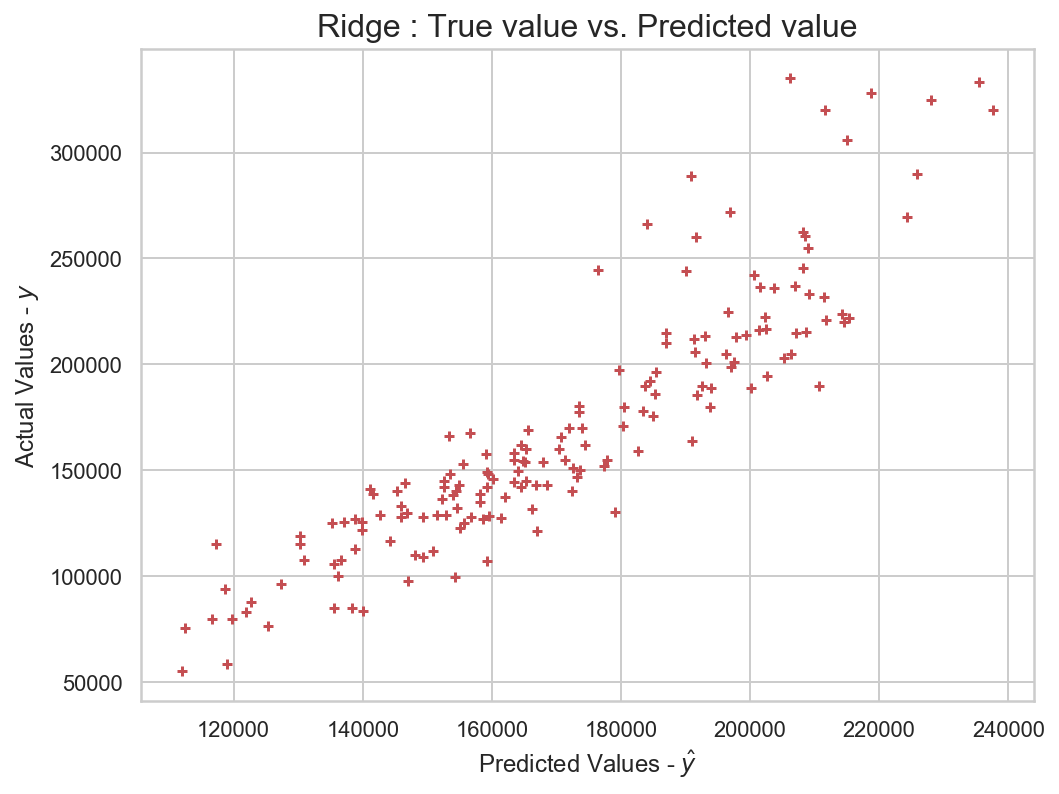

In [1523]:
# Plot the model with test dataset
# With test data set
Xs_test = ss.fit_transform(X_test)
predictions = ridgeregcv.predict(Xs_test)
print("Best Error RMSE for test dataset : {}".format(np.sqrt(metrics.mean_squared_error(y_test, predictions))))
print('RidgeCV test score : {}'.format(ridgeregcv.score(Xs_test,y_test)))
plt.figure(figsize=(8,6))
plt.title('Ridge : True value vs. Predicted value',fontsize=16)
plt.scatter(predictions, y_test, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicted Values - $\hat{y}$")
plt.ylabel("Actual Values - $y$")
plt.show()

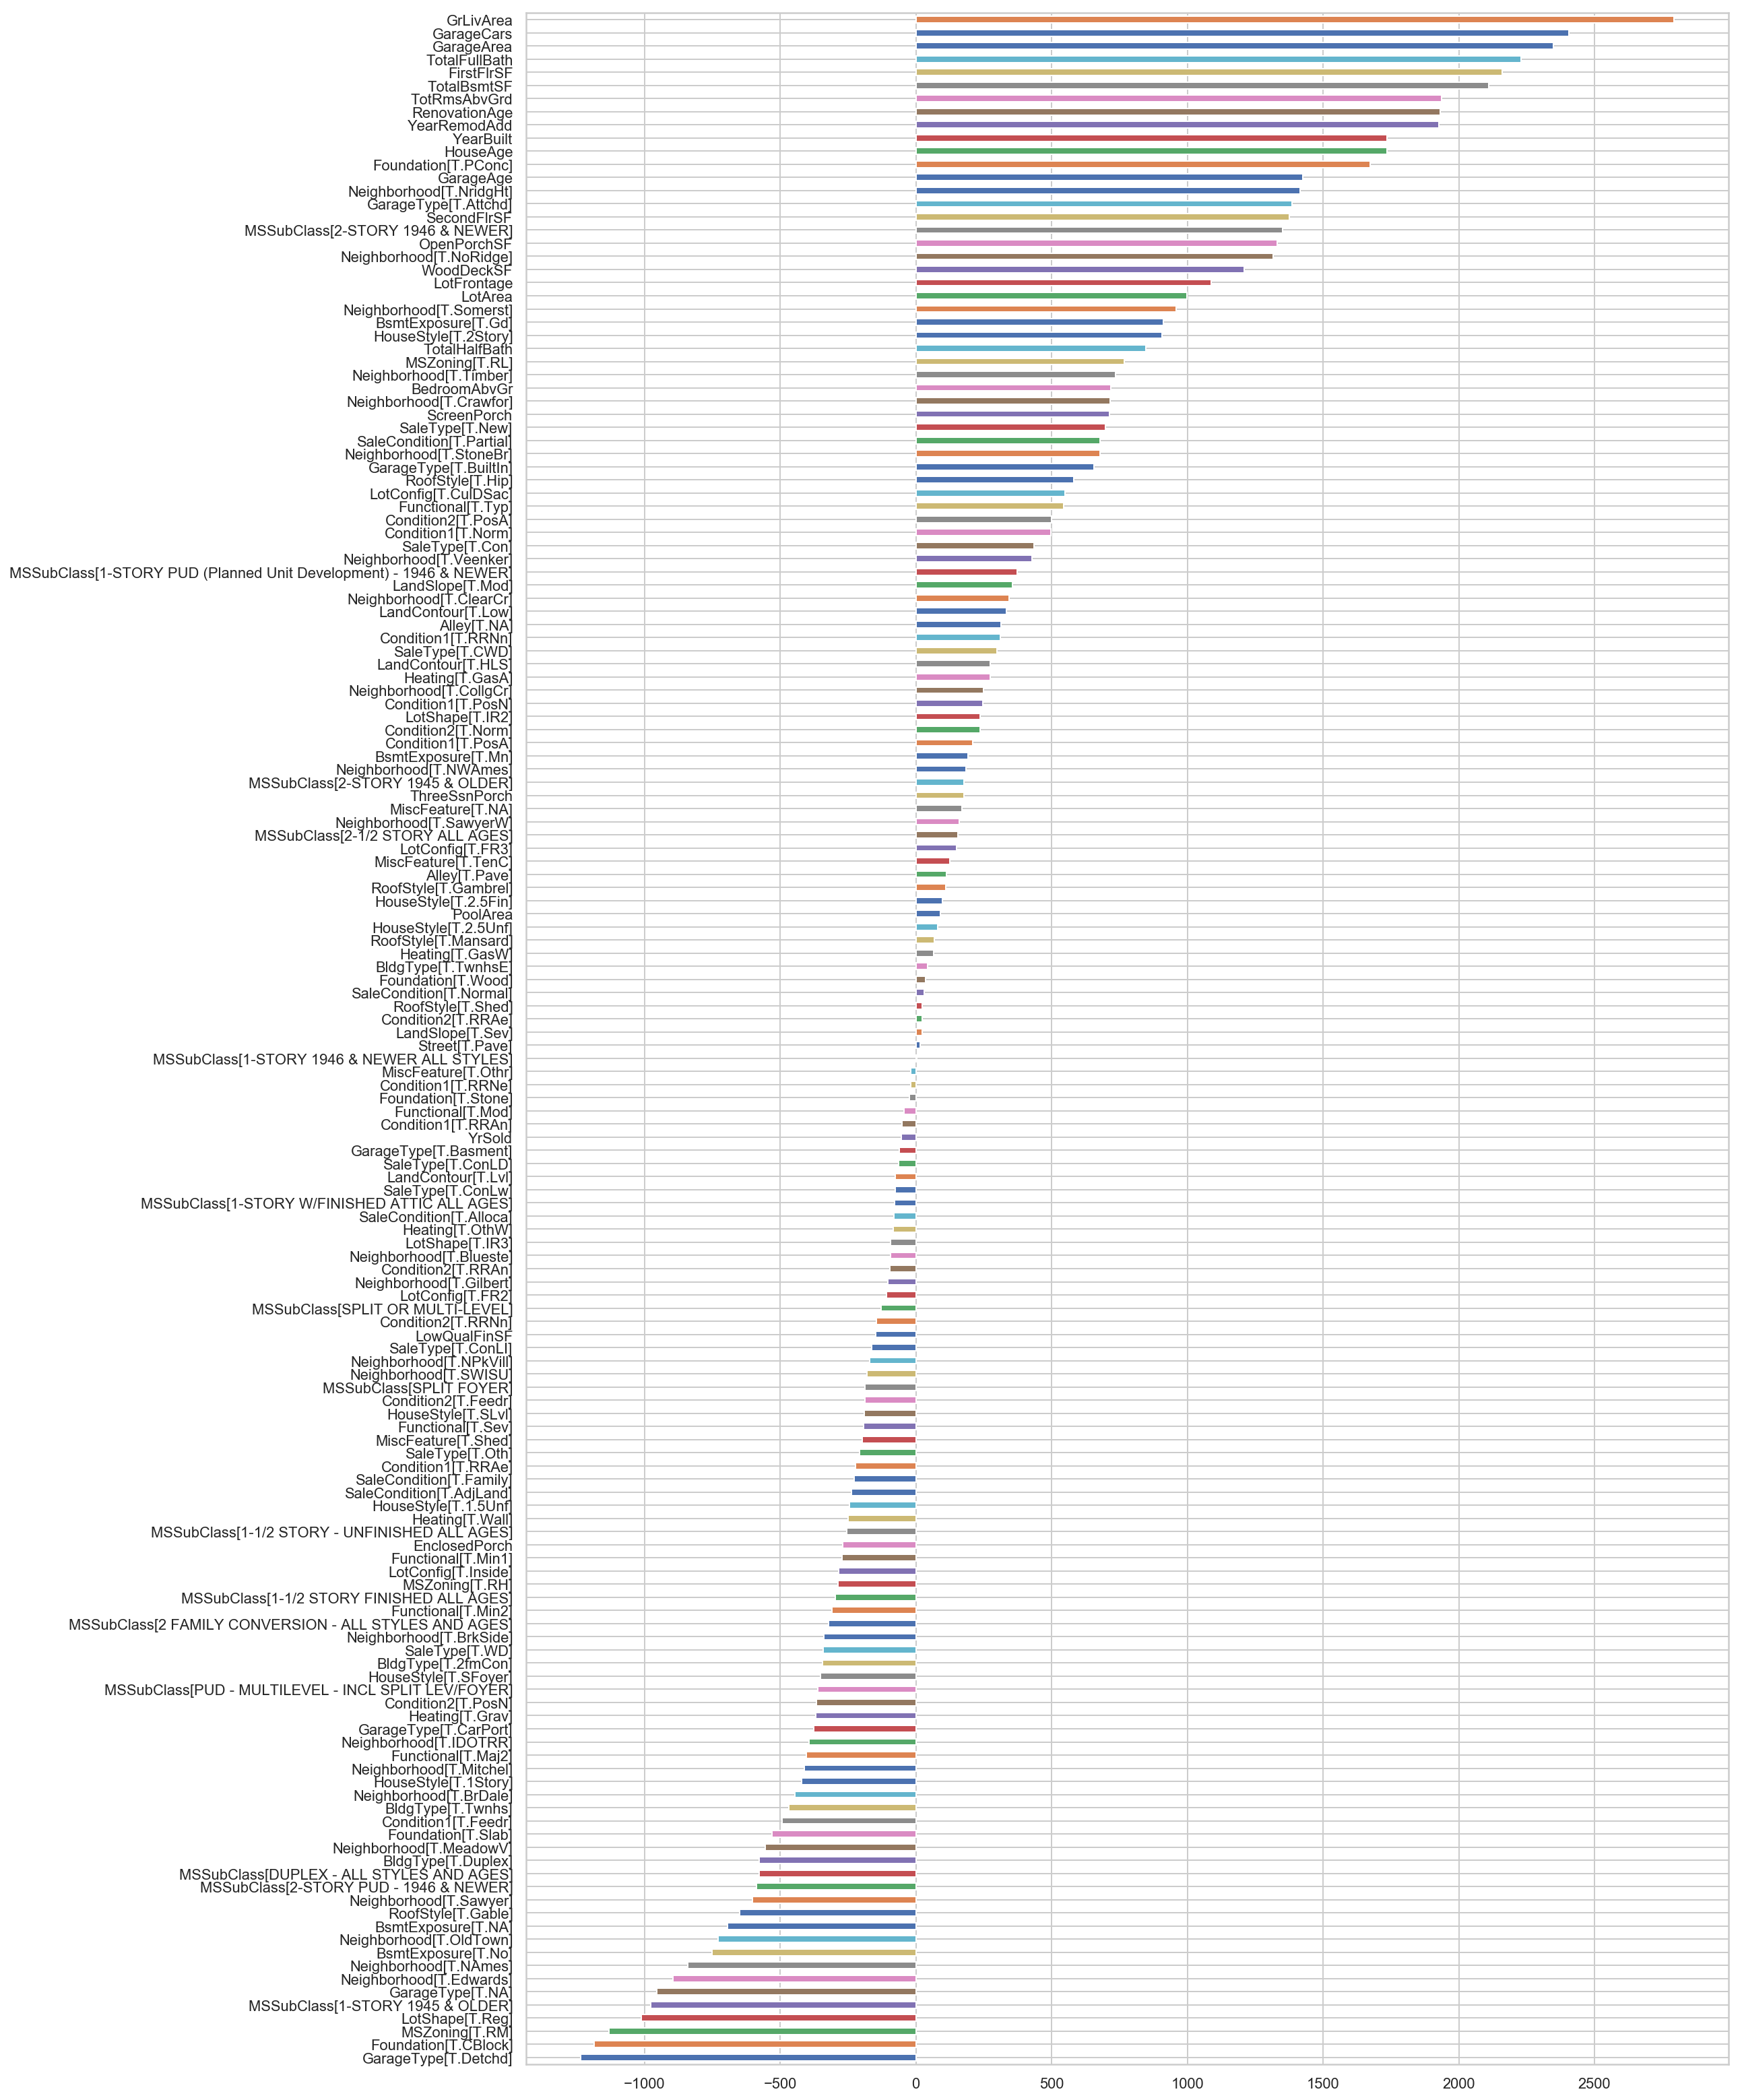

In [1524]:
plt.figure(figsize=(16,28))
fit_importance_lassoreg = pd.Series(ridgeregcv.coef_,index=train_dataset.columns.difference(['SalePrice']))
fit_importance_lassoreg.sort_values(ascending=True).plot(kind='barh')
plt.show();

### <b>Using LassoCV for regularization</b>

In [1525]:
alpha_range = np.logspace(-1, 4, num=800)
lassoregcv = LassoCV(alphas=alpha_range, random_state=42, cv=10)
#yr_train = y_train.values.ravel()
lassoregcv.fit(Xs_train, y_train)
print('Best lasso alpha : {}'.format(lassoregcv.alpha_))

# predict method uses the best alpha value with non-standardized test value
y_pred = lassoregcv.predict(X_test)
print("Best Error RMSE for test dataset (no standardization) : {}".format(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))
print('LassoregCV train score : {}'.format(lassoregcv.score(Xs_train,y_train)))

Best lasso alpha : 666.0846290809161
Best Error RMSE for test dataset (no standardization) : 52560604.002544485
LassoregCV train score : 0.8587381478837796


Best Error RMSE for test dataset : 21392.13577538177
LassoregCV test score : 0.8679285143289991


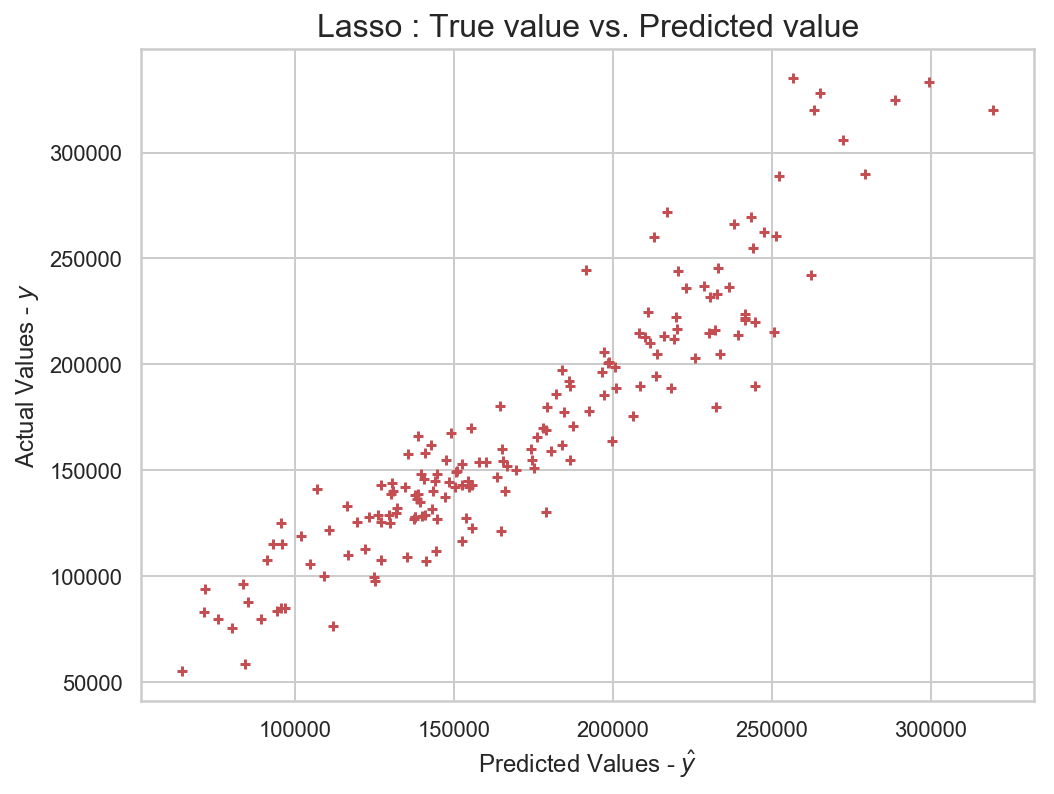

In [1526]:
# Plot the model with test dataset which are standardized during LassoCV
# Predict with standardized dataset
predictions = lassoregcv.predict(Xs_test)

print("Best Error RMSE for test dataset : {}".format(np.sqrt(metrics.mean_squared_error(y_test, predictions))))
print('LassoregCV test score : {}'.format(lassoregcv.score(Xs_test,y_test)))
plt.figure(figsize=(8,6))
plt.title('Lasso : True value vs. Predicted value',fontsize=16)
plt.scatter(predictions, y_test, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicted Values - $\hat{y}$")
plt.ylabel("Actual Values - $y$")
plt.show();

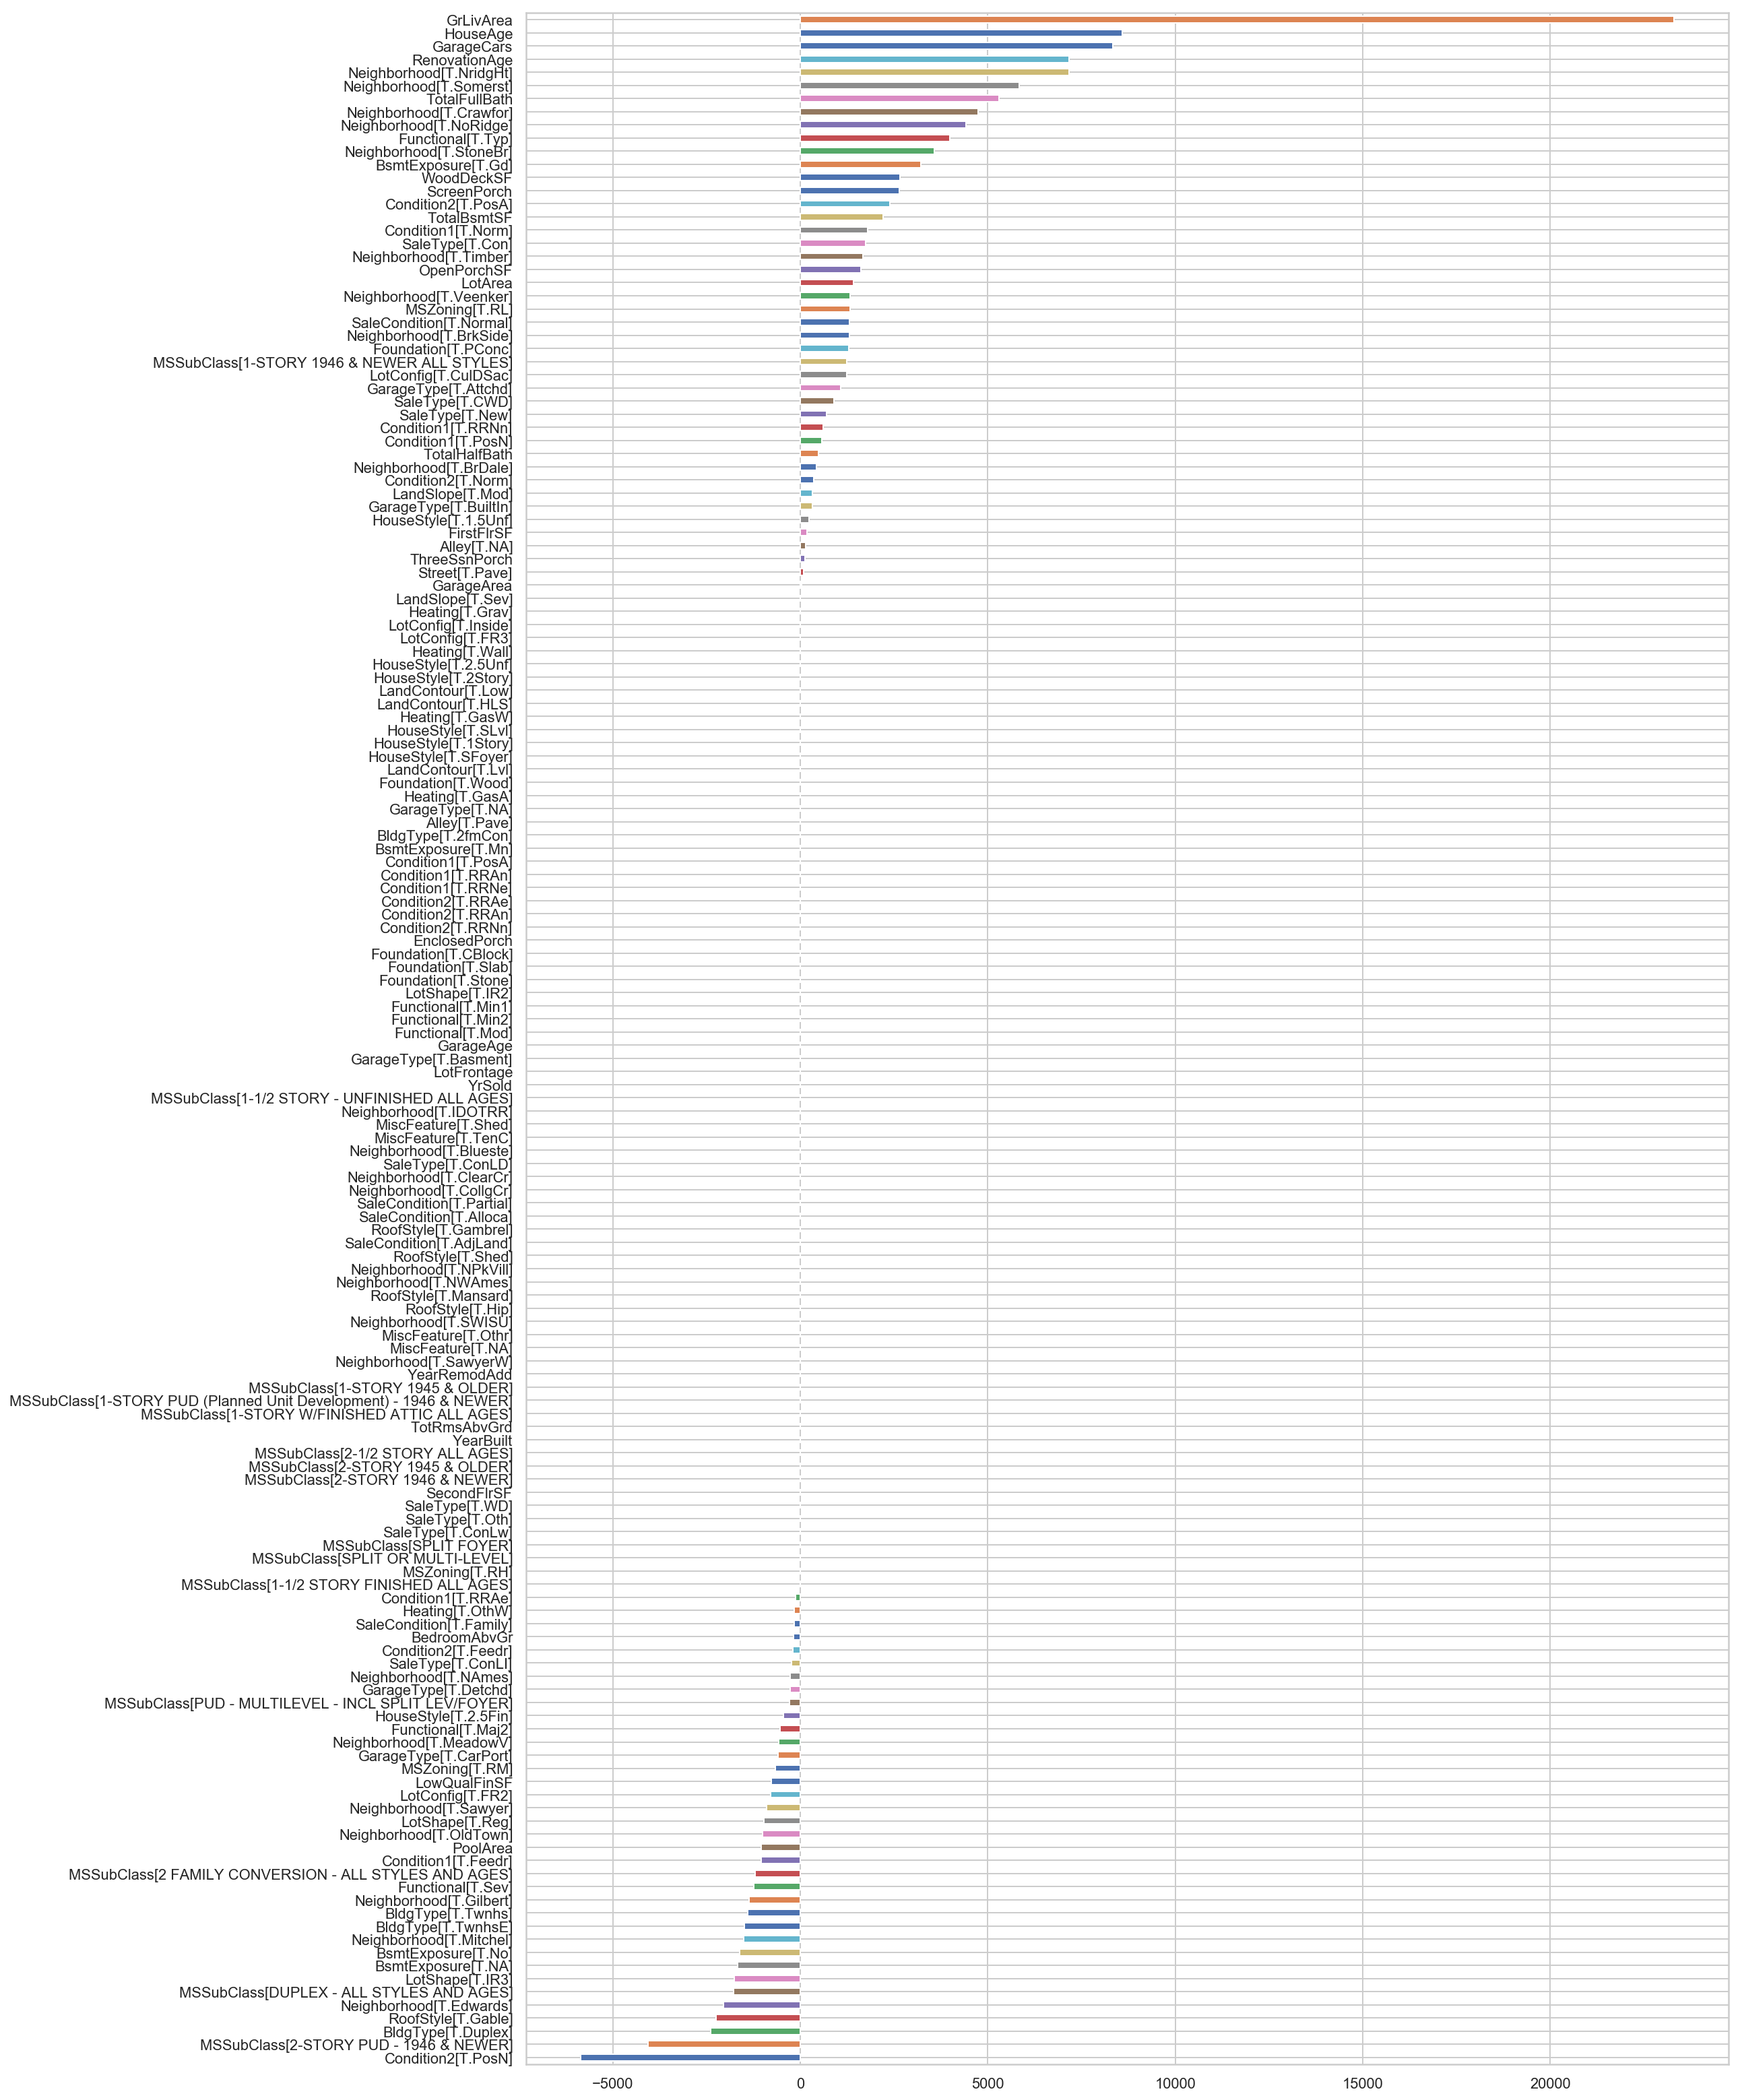

In [1527]:
plt.figure(figsize=(16,28))
fit_importance_lassoreg = pd.Series(lassoregcv.coef_,index=train_dataset.columns.difference(['SalePrice']))
fit_importance_lassoreg.sort_values(ascending=True).plot(kind='barh')
plt.show();

In [1528]:
fit_importance_lassoreg

Alley[T.NA]                  144.103097
Alley[T.Pave]                 -0.000000
BedroomAbvGr                -185.403695
BldgType[T.2fmCon]            -0.000000
BldgType[T.Duplex]         -2387.636226
BldgType[T.TwnhsE]         -1489.134710
BldgType[T.Twnhs]          -1399.346855
BsmtExposure[T.Gd]          3222.560959
BsmtExposure[T.Mn]            -0.000000
BsmtExposure[T.NA]         -1675.477205
BsmtExposure[T.No]         -1619.482404
Condition1[T.Feedr]        -1042.255472
Condition1[T.Norm]          1787.149018
Condition1[T.PosA]             0.000000
Condition1[T.PosN]           580.799105
Condition1[T.RRAe]          -133.826054
Condition1[T.RRAn]            -0.000000
Condition1[T.RRNe]            -0.000000
Condition1[T.RRNn]           616.847367
Condition2[T.Feedr]         -200.736485
Condition2[T.Norm]           354.925495
Condition2[T.PosA]          2384.554431
Condition2[T.PosN]         -5863.136988
Condition2[T.RRAe]            -0.000000
Condition2[T.RRAn]            -0.000000


In [1529]:
# examine the coefficients
#print("Coefficients : \n{}".format(list(zip(X_train.columns,lassoregcv.coef_))))
train_dataset[train_dataset.columns.difference(['SalePrice'])]
print("After applying Lasso for regularization, the following features are minimized to zero.\n{}" \
      .format([ x[0] for x in list(zip(train_dataset[train_dataset.columns.difference(['SalePrice'])].columns,lassoregcv.coef_)) if x[1]==0]))

After applying Lasso for regularization, the following features are minimized to zero.
['Alley[T.Pave]', 'BldgType[T.2fmCon]', 'BsmtExposure[T.Mn]', 'Condition1[T.PosA]', 'Condition1[T.RRAn]', 'Condition1[T.RRNe]', 'Condition2[T.RRAe]', 'Condition2[T.RRAn]', 'Condition2[T.RRNn]', 'EnclosedPorch', 'Foundation[T.CBlock]', 'Foundation[T.Slab]', 'Foundation[T.Stone]', 'Foundation[T.Wood]', 'Functional[T.Min1]', 'Functional[T.Min2]', 'Functional[T.Mod]', 'GarageAge', 'GarageType[T.Basment]', 'GarageType[T.NA]', 'Heating[T.GasA]', 'Heating[T.GasW]', 'Heating[T.Grav]', 'Heating[T.Wall]', 'HouseStyle[T.1Story]', 'HouseStyle[T.2.5Unf]', 'HouseStyle[T.2Story]', 'HouseStyle[T.SFoyer]', 'HouseStyle[T.SLvl]', 'LandContour[T.HLS]', 'LandContour[T.Low]', 'LandContour[T.Lvl]', 'LandSlope[T.Sev]', 'LotConfig[T.FR3]', 'LotConfig[T.Inside]', 'LotFrontage', 'LotShape[T.IR2]', 'MSSubClass[1-1/2 STORY - UNFINISHED ALL AGES]', 'MSSubClass[1-1/2 STORY FINISHED ALL AGES]', 'MSSubClass[1-STORY 1945 & OLDER]', '

In [1530]:
print("After applying Lasso for regularization, the following features are left to use for model.\n{}" \
      .format([ x[0] for x in list(zip(train_dataset[train_dataset.columns.difference(['SalePrice'])].columns,lassoregcv.coef_)) if x[1]!=0]))

After applying Lasso for regularization, the following features are left to use for model.
['Alley[T.NA]', 'BedroomAbvGr', 'BldgType[T.Duplex]', 'BldgType[T.TwnhsE]', 'BldgType[T.Twnhs]', 'BsmtExposure[T.Gd]', 'BsmtExposure[T.NA]', 'BsmtExposure[T.No]', 'Condition1[T.Feedr]', 'Condition1[T.Norm]', 'Condition1[T.PosN]', 'Condition1[T.RRAe]', 'Condition1[T.RRNn]', 'Condition2[T.Feedr]', 'Condition2[T.Norm]', 'Condition2[T.PosA]', 'Condition2[T.PosN]', 'FirstFlrSF', 'Foundation[T.PConc]', 'Functional[T.Maj2]', 'Functional[T.Sev]', 'Functional[T.Typ]', 'GarageArea', 'GarageCars', 'GarageType[T.Attchd]', 'GarageType[T.BuiltIn]', 'GarageType[T.CarPort]', 'GarageType[T.Detchd]', 'GrLivArea', 'Heating[T.OthW]', 'HouseAge', 'HouseStyle[T.1.5Unf]', 'HouseStyle[T.2.5Fin]', 'LandSlope[T.Mod]', 'LotArea', 'LotConfig[T.CulDSac]', 'LotConfig[T.FR2]', 'LotShape[T.IR3]', 'LotShape[T.Reg]', 'LowQualFinSF', 'MSSubClass[1-STORY 1946 & NEWER ALL STYLES]', 'MSSubClass[2 FAMILY CONVERSION - ALL STYLES AND AG

In [1531]:
len([ x[0] for x in list(zip(train_dataset[train_dataset.columns.difference(['SalePrice'])].columns,lassoregcv.coef_)) if x[1]!=0])

80

### <b>Using ElasticNetCV for regularization</b>

In [1532]:
# create an array of alpha values
alpha_range = np.logspace(-1, 4, num=200)
l1_ratios = np.arange(0.1,1.1,0.1)
print('min alpha : {}'.format(min(alpha_range)))
print('max alpha : {}'.format(max(alpha_range)))

# select the best alpha with ElasticNetCV
elasticnetcv = ElasticNetCV(alphas=alpha_range, l1_ratio=l1_ratios, cv=kf_shuffle,)
elasticnetcv.fit(Xs_train, y_train)

min alpha : 0.1
max alpha : 10000.0


ElasticNetCV(alphas=array([1.00000e-01, 1.05956e-01, ..., 9.43788e+03, 1.00000e+04]),
       copy_X=True, cv=KFold(n_splits=10, random_state=42, shuffle=True),
       eps=0.001, fit_intercept=True,
       l1_ratio=array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
       max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
       positive=False, precompute='auto', random_state=None,
       selection='cyclic', tol=0.0001, verbose=0)

In [1533]:
print('Best elasticnet alpha: {}'.format(elasticnetcv.alpha_))
print('Best elasticnet l1 ratio: {}'.format(elasticnetcv.l1_ratio_))
print("R2 scores for 10 folds : {}".format(elasticnetcv.score(Xs_train,y_train)))
#print("R2 mean : {}, R2 std : {}".format(np.mean(scores), np.std(scores)))

Best elasticnet alpha: 3.827494478516313
Best elasticnet l1 ratio: 0.9
R2 scores for 10 folds : 0.8531890662595796


Best Error RMSE for test dataset : 22012.074802553816
ElasticNetCV test score : 0.8601627964365316


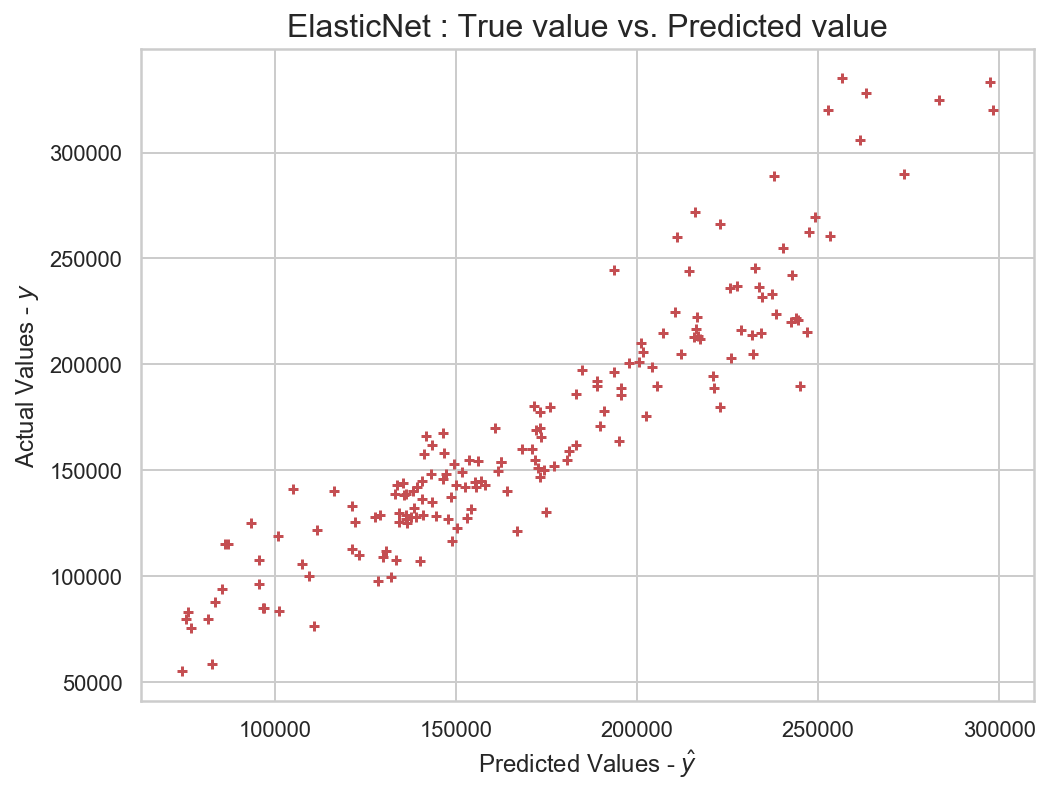

In [1534]:
# Plot the model with test dataset which are standardized during ElasticNetCV
# Predict with standardized dataset
predictions = elasticnetcv.predict(Xs_test)

print("Best Error RMSE for test dataset : {}".format(np.sqrt(metrics.mean_squared_error(y_test, predictions))))
print('ElasticNetCV test score : {}'.format(elasticnetcv.score(Xs_test,y_test)))
plt.figure(figsize=(8,6))
plt.title('ElasticNet : True value vs. Predicted value',fontsize=16)
plt.scatter(predictions, y_test, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicted Values - $\hat{y}$")
plt.ylabel("Actual Values - $y$")
plt.show();

#### Conclusion : After multilinear regression, ridge, lasso and elasticnet, lasso provides the best result/prediction with R2=0.8697 and RMSE=21392.136. Therefore, lasso will be used for final prediction for estimating the value of homes from fixed characteristics.

### <b>Using Recursive Feature Elimination (RFECV) for Feature Selection based on Lasso model</b>

In [1535]:
# Setting kfold
kf_shuffle = KFold(n_splits=10,shuffle=True, random_state=42)

# Instantiate Linear Regression Model
#linreg = LinearRegression()
lassomodel = Lasso(alpha=lassoregcv.alpha_)

# Create recursive feature eliminator that scores features by mean squared errors
rfecv = RFECV(estimator=lassomodel, step=1, cv=kf_shuffle, scoring='neg_mean_squared_error')

In [1536]:
# Fit recursive feature eliminator 
rfecv.fit_transform(Xs_train, y_train)

array([[-0.19553208, -0.29363621, -0.17914964, ...,  1.45810351,
         1.00612756, -0.74011562],
       [-0.19553208, -0.29363621, -0.17914964, ...,  0.07364159,
         1.00612756,  1.74513103],
       [-0.19553208, -0.29363621, -0.17914964, ...,  1.45810351,
         1.00612756, -0.74011562],
       ...,
       [-0.19553208, -0.29363621, -0.17914964, ...,  1.45810351,
        -0.78091877, -0.74011562],
       [-0.19553208, -0.29363621, -0.17914964, ...,  0.07364159,
         1.00612756, -0.74011562],
       [-0.19553208, -0.29363621, -0.17914964, ...,  0.07364159,
         1.00612756,  5.39794323]])

In [1537]:
# Number of best features
rfecv.n_features_

61

In [1538]:
len(train_dataset.columns.difference(['SalePrice']))

156

In [1539]:
len(rfecv.support_)

156

In [1540]:
result = list(zip(train_dataset[train_dataset.columns.difference(['SalePrice'])],rfecv.support_,rfecv.ranking_,lassoregcv.coef_))
result_df = pd.DataFrame(result, columns=['Features','Support','Rank','Coef'])

In [1599]:
print('Best Features found by RFECV :')
result_df[result_df['Support']==True].sort_values(by='Coef',ascending=False)
#.sort_values(by=['Coef'], ascending=False, inplace=False)

Best Features found by RFECV :


Features  Support  Rank  \
48                                           GrLivArea     True     1   
54                                            HouseAge     True     1   
41                                          GarageCars     True     1   
125                                      RenovationAge     True     1   
114                            Neighborhood[T.NridgHt]     True     1   
119                            Neighborhood[T.Somerst]     True     1   
150                                      TotalFullBath     True     1   
104                            Neighborhood[T.Crawfor]     True     1   
113                            Neighborhood[T.NoRidge]     True     1   
38                                   Functional[T.Typ]     True     1   
120                            Neighborhood[T.StoneBr]     True     1   
7                                   BsmtExposure[T.Gd]     True     1   
152                                         WoodDeckSF     True     1   
144                                        ScreenPorch     True     1   
21                                  Condition2[T.PosA]     True     1   
149                                        TotalBsmtSF     True     1   
12                                  Condition1[T.Norm]     True     1   
140                                    SaleType[T.Con]     True     1   
121                             Neighborhood[T.Timber]     True     1   
123                                        OpenPorchSF     True     1   
67                                             LotArea     True     1   
122                            Neighborhood[T.Veenker]     True     1   
93                                      MSZoning[T.RL]     True     1   
134                            SaleCondition[T.Normal]     True     1   
101                            Neighborhood[T.BrkSide]     True     1   
29                                 Foundation[T.PConc]     True     1   
80         MSSubClass[1-STORY 1946 & NEWER ALL STYLES]     True     1   
68                                LotConfig[T.CulDSac]     True     1   
42                                GarageType[T.Attchd]     True     1   
136                                    SaleType[T.CWD]     True     1   
..                                                 ...      ...   ...   
18                                  Condition1[T.RRNn]     True     1   
14                                  Condition1[T.PosN]     True     1   
151                                      TotalHalfBath     True     1   
100                             Neighborhood[T.BrDale]     True     1   
33                                  Functional[T.Maj2]     True     1   
108                            Neighborhood[T.MeadowV]     True     1   
45                               GarageType[T.CarPort]     True     1   
94                                      MSZoning[T.RM]     True     1   
76                                        LowQualFinSF     True     1   
69                                    LotConfig[T.FR2]     True     1   
118                             Neighborhood[T.Sawyer]     True     1   
75                                     LotShape[T.Reg]     True     1   
115                            Neighborhood[T.OldTown]     True     1   
124                                           PoolArea     True     1   
11                                 Condition1[T.Feedr]     True     1   
83   MSSubClass[2 FAMILY CONVERSION - ALL STYLES AN...     True     1   
37                                   Functional[T.Sev]     True     1   
106                            Neighborhood[T.Gilbert]     True     1   
6                                    BldgType[T.Twnhs]     True     1   
5                                   BldgType[T.TwnhsE]     True     1   
109                            Neighborhood[T.Mitchel]     True     1   
10                                  BsmtExposure[T.No]     True     1   
9                                   BsmtExposure[T.NA]     True     1   
74                             

In [1542]:
print("RFECV R2 train score for 10 folds : {}".format(rfecv.score(Xs_train,y_train)))

RFECV R2 train score for 10 folds : 0.857403292655809


Standard Deviation in fixed_predictions : 52972.46044667099
Best Error RMSE for test dataset : 21391.423548746225
RFECV with Lasso test score : 0.8679373085200035


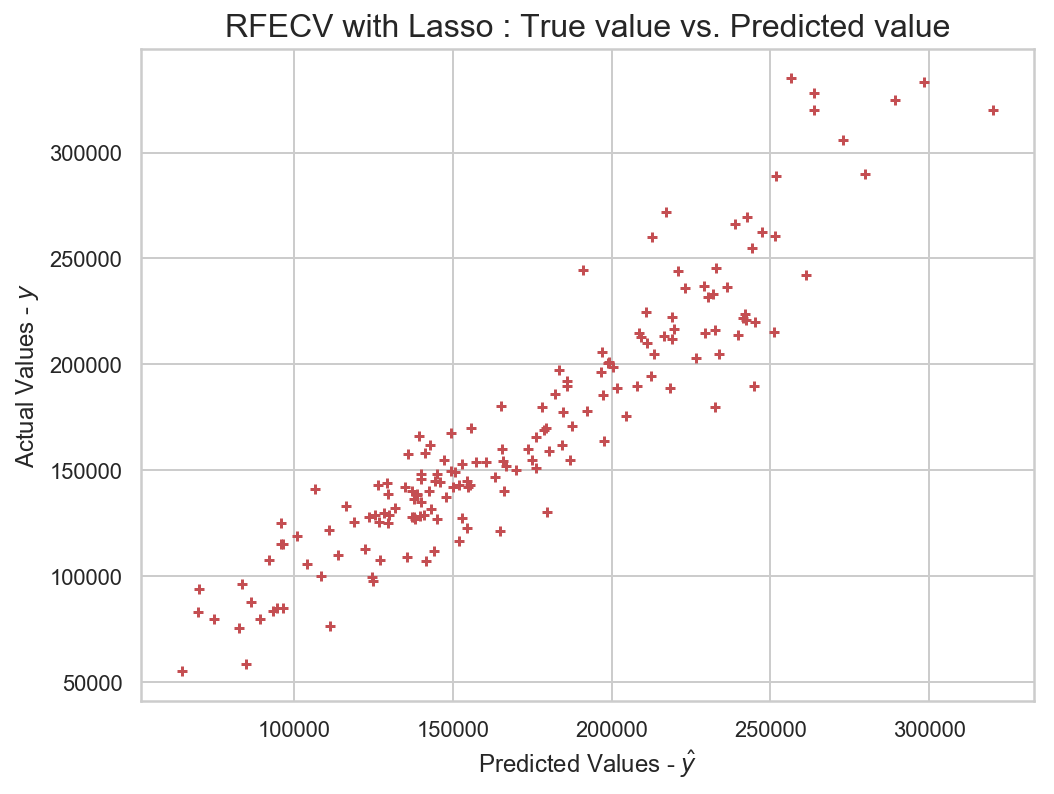

In [1543]:
# Plot the model with test dataset which are standardized during ElasticNetCV
# Predict with standardized dataset
predictions = rfecv.predict(Xs_test)

print("Standard Deviation in fixed_predictions : {}".format(np.std(predictions)))
print("Best Error RMSE for test dataset : {}".format(np.sqrt(metrics.mean_squared_error(y_test, predictions))))
print('RFECV with Lasso test score : {}'.format(rfecv.score(Xs_test,y_test)))
plt.figure(figsize=(8,6))
plt.title('RFECV with Lasso : True value vs. Predicted value',fontsize=16)
plt.scatter(predictions, y_test, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicted Values - $\hat{y}$")
plt.ylabel("Actual Values - $y$")
plt.show()

In [1544]:
fixed_predictions = rfecv.predict(np.concatenate([Xs_train,Xs_test]))
len(fixed_predictions)

1388

In [1545]:
Residential_house.shape

(1388, 78)

In [1546]:
Residential_house['Fixed_Pred'] = fixed_predictions

In [1547]:
Residential_house['Fixed_Pred'].isnull().value_counts()

False    1388
Name: Fixed_Pred, dtype: int64

In [1548]:
y.shape

(1388, 1)

In [1549]:
Residential_house['Residuals'] = Residential_house['SalePrice'] - Residential_house['Fixed_Pred']

In [1550]:
Residential_house['Residuals'].isnull().value_counts()

False    1388
Name: Residuals, dtype: int64

In [1551]:
Residential_house.shape

(1388, 80)

#### Conclusion : After using RFECV with Lasso model, the features was reduced to 61 and R2 score and RMSE are slightly improved to 0.867 and 21391.
#### However, total columns 61 are including the dummy columns, hence, actual columns which effects the price prediction are less than 61 and Top 10 Features are as following:
##### 1. GrLivArea: Above grade (ground) living area square feet
##### 2. HouseAge (aka YearBuilt) : Total Years/Age of House since the house is built
##### 3. GarageCars : Size of garage in car capacity
##### 4. RenovationAge (aka YearRemodAdd) : Total Years/Age of House Renovation (Remodel date)
##### 5. Neighborhood : Physical locations within Ames city limits
##### 6. TotalFullBath : Combination of BsmtFullBath and FullBath
##### 7. Functional : Home functionality (Assume typical unless deductions are warranted)
##### 8. TotalBsmtSF : Total square feet of basement area
##### 9. Condition1 : Proximity to various conditions
##### 10. Condition2 : roximity to various conditions (if more than one is present)

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [1552]:
# 
X_renovatable.columns

Index(['BsmtCond', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'CentralAir',
       'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd',
       'Fence', 'FireplaceQu', 'Fireplaces', 'GarageCond', 'GarageFinish',
       'GarageQual', 'GarageYrBlt', 'HeatingQC', 'KitchenAbvGr', 'KitchenQual',
       'MasVnrArea', 'MasVnrType', 'MiscVal', 'MoSold', 'OverallCond',
       'OverallQual', 'PavedDrive', 'PoolQC', 'RoofMatl', 'SalePrice',
       'Utilities'],
      dtype='object')

In [1553]:
X_renovatable.drop(['SalePrice','MoSold'],axis=1,inplace=True)

In [1554]:
formula = 'Residuals ~ '+ " + ".join(X_renovatable.columns) + ' - 1'

print(formula)

y, X = patsy.dmatrices(formula, data=Residential_house, return_type='dataframe')

Residuals ~ BsmtCond + BsmtFinType1 + BsmtFinType2 + BsmtQual + CentralAir + Electrical + ExterCond + ExterQual + Exterior1st + Exterior2nd + Fence + FireplaceQu + Fireplaces + GarageCond + GarageFinish + GarageQual + GarageYrBlt + HeatingQC + KitchenAbvGr + KitchenQual + MasVnrArea + MasVnrType + MiscVal + OverallCond + OverallQual + PavedDrive + PoolQC + RoofMatl + Utilities - 1


In [1555]:
#list(X.columns)

In [1556]:
X_ytemp = pd.concat([X,y,Residential_house['YrSold']],axis=1)

In [1557]:
X_ytemp.shape

(1388, 73)

In [1558]:
X_ytemp.head()

CentralAir[N]  CentralAir[Y]  Electrical[T.FuseF]  Electrical[T.FuseP]  \
0            0.0            1.0                  0.0                  0.0   
1            0.0            1.0                  0.0                  0.0   
2            0.0            1.0                  0.0                  0.0   
3            0.0            1.0                  0.0                  0.0   
4            0.0            1.0                  0.0                  0.0   

   Electrical[T.Mix]  Electrical[T.SBrkr]  Exterior1st[T.AsphShn]  \
0                0.0                  1.0                     0.0   
1                0.0                  1.0                     0.0   
2                0.0                  1.0                     0.0   
3                0.0                  1.0                     0.0   
4                0.0                  1.0                     0.0   

   Exterior1st[T.BrkComm]  Exterior1st[T.BrkFace]  Exterior1st[T.CBlock]  \
0                     0.0                     0.0                    0.0   
1                     0.0                     0.0                    0.0   
2                     0.0                     0.0                    0.0   
3                     0.0                     0.0                    0.0   
4                     0.0                     0.0                    0.0   

    ...    HeatingQC  KitchenAbvGr  KitchenQual  MasVnrArea  MiscVal  \
0   ...          5.0           1.0          4.0       196.0      0.0   
1   ...          5.0           1.0          3.0         0.0      0.0   
2   ...          5.0           1.0          4.0       162.0      0.0   
3   ...          4.0           1.0          4.0         0.0      0.0   
4   ...          5.0           1.0          4.0       350.0      0.0   

   OverallCond  OverallQual  PoolQC     Residuals  YrSold  
0          5.0          7.0     0.0   2178.068829    2008  
1          8.0          6.0     0.0  -2968.486857    2007  
2          5.0          7.0     0.0   8672.197114    2008  
3          5.0          7.0     0.0 -51511.149818    2006  
4          5.0          8.0     0.0 -29644.711194    2008  

[5 rows x 73 columns]

In [1559]:
# Splitting the data to train and test
#X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)
train_dataset = X_ytemp[X_ytemp['YrSold']!=2010]
test_dataset = X_ytemp[X_ytemp['YrSold']==2010]
Xr_train = train_dataset[train_dataset.columns.difference(['Residuals','YrSold'])].values
yr_train = train_dataset['Residuals'].values
Xr_test = test_dataset[test_dataset.columns.difference(['Residuals','YrSold'])].values
yr_test = test_dataset['Residuals'].values

In [1560]:
train_dataset[train_dataset.columns.difference(['Residuals','YrSold'])].shape

(1222, 71)

In [1561]:
train_dataset[train_dataset.columns.difference(['Residuals','YrSold'])].head()

BsmtCond  BsmtFinType1  BsmtFinType2  BsmtQual  CentralAir[N]  \
0       3.0           6.0           1.0       4.0            0.0   
1       3.0           5.0           1.0       4.0            0.0   
2       3.0           6.0           1.0       4.0            0.0   
3       4.0           5.0           1.0       3.0            0.0   
4       3.0           6.0           1.0       4.0            0.0   

   CentralAir[Y]  Electrical[T.FuseF]  Electrical[T.FuseP]  Electrical[T.Mix]  \
0            1.0                  0.0                  0.0                0.0   
1            1.0                  0.0                  0.0                0.0   
2            1.0                  0.0                  0.0                0.0   
3            1.0                  0.0                  0.0                0.0   
4            1.0                  0.0                  0.0                0.0   

   Electrical[T.SBrkr]         ...           PavedDrive[T.Y]  PoolQC  \
0                  1.0         ...                       1.0     0.0   
1                  1.0         ...                       1.0     0.0   
2                  1.0         ...                       1.0     0.0   
3                  1.0         ...                       1.0     0.0   
4                  1.0         ...                       1.0     0.0   

   RoofMatl[T.CompShg]  RoofMatl[T.Membran]  RoofMatl[T.Metal]  \
0                  1.0                  0.0                0.0   
1                  1.0                  0.0                0.0   
2                  1.0                  0.0                0.0   
3                  1.0                  0.0                0.0   
4                  1.0                  0.0                0.0   

   RoofMatl[T.Roll]  RoofMatl[T.Tar&Grv]  RoofMatl[T.WdShake]  \
0               0.0                  0.0                  0.0   
1               0.0                  0.0                  0.0   
2               0.0                  0.0                  0.0   
3               0.0                  0.0                  0.0   
4               0.0                  0.0                  0.0   

   RoofMatl[T.WdShngl]  Utilities[T.NoSeWa]  
0                  0.0                  0.0  
1                  0.0                  0.0  
2                  0.0                  0.0  
3                  0.0                  0.0  
4                  0.0                  0.0  

[5 rows x 71 columns]

In [1562]:
len(list(Xr_train))

1222

In [1563]:
len(list(Xr_train)[0])

71

In [1564]:
list(Xr_train)[0]

array([3.000e+00, 6.000e+00, 1.000e+00, 4.000e+00, 0.000e+00, 1.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 3.000e+00, 4.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 3.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
       3.000e+00, 2.003e+03, 5.000e+00, 1.000e+00, 4.000e+00, 1.960e+02,
       1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 5.000e+00, 7.000e+00,
       0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00])

In [1565]:
len(list(yr_train))

1222

### Multi-Linear Regression

In [1566]:
# Instantiate Linear Regression Model
linreg = LinearRegression()

In [1567]:
# Fit the model on the train dataset of X and Y.
linreg.fit(Xr_train, yr_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [1568]:
# Getting coefficients of the model
linreg.coef_

array([-9.50091867e+03,  2.65088991e+03, -4.20820229e+02,  8.71580185e+03,
       -3.27568640e+03,  3.27568639e+03,  7.25361980e+02, -4.13022625e+04,
        7.47317552e+03, -1.21808349e+04, -1.73184821e+03,  1.23707985e+04,
       -7.23402991e-08,  3.71677933e+04,  3.48425538e+03, -2.06709104e+03,
       -3.54457539e+03, -2.13310608e+04, -3.05099768e+04,  5.90833146e+04,
       -1.12536140e+04,  8.56755410e+03, -1.05530935e+04, -3.18775647e+04,
        1.67839683e+04,  5.62917388e+03, -4.09038553e+04, -4.09456100e+04,
       -2.05217656e+04, -2.06709104e+03, -1.32775624e+04, -7.82413497e+03,
       -3.37460479e+04, -9.20773320e+04,  1.05912107e+05, -1.64365171e+04,
        1.51645786e+04, -1.74501457e+04,  4.43831842e+03, -5.05230116e+04,
       -4.69898939e+04, -1.20898341e+03,  6.10493850e+02,  1.41627686e+04,
        6.49508942e+03, -3.48430335e+03, -6.29417350e+03, -2.00278313e+04,
        2.70513253e+03,  6.61568432e+01,  1.14721873e+03,  1.18828958e+04,
        9.46149591e+03,  

In [1569]:
# Getting intercept of the model
linreg.intercept_

-717927.1572065114

In [1570]:
# Use the KFold class to add more options.
kf_shuffle = KFold(n_splits=10,shuffle=True, random_state=42) 

#The function cross_val_score returns the  𝑅2  for each testing set.
mlr_scores = cross_val_score(linreg, Xr_train, yr_train, cv=kf_shuffle)

In [1571]:
print("R2 scores for 10 folds : {}".format(mlr_scores))
print("R2 mean : {}, R2 std : {}".format(np.mean(mlr_scores), np.std(mlr_scores)))

R2 scores for 10 folds : [0.05418167 0.48567398 0.35910128 0.45249322 0.19254718 0.10931977
 0.35795173 0.1560247  0.4802538  0.35458857]
R2 mean : 0.3002135903507061, R2 std : 0.1513644138961004


In [1572]:
# With training data set
predictions = linreg.predict(Xr_train)
print("RMSE for whole train dataset:", np.sqrt(metrics.mean_squared_error(yr_train, predictions)))

RMSE for whole train dataset: 59165.40921705843


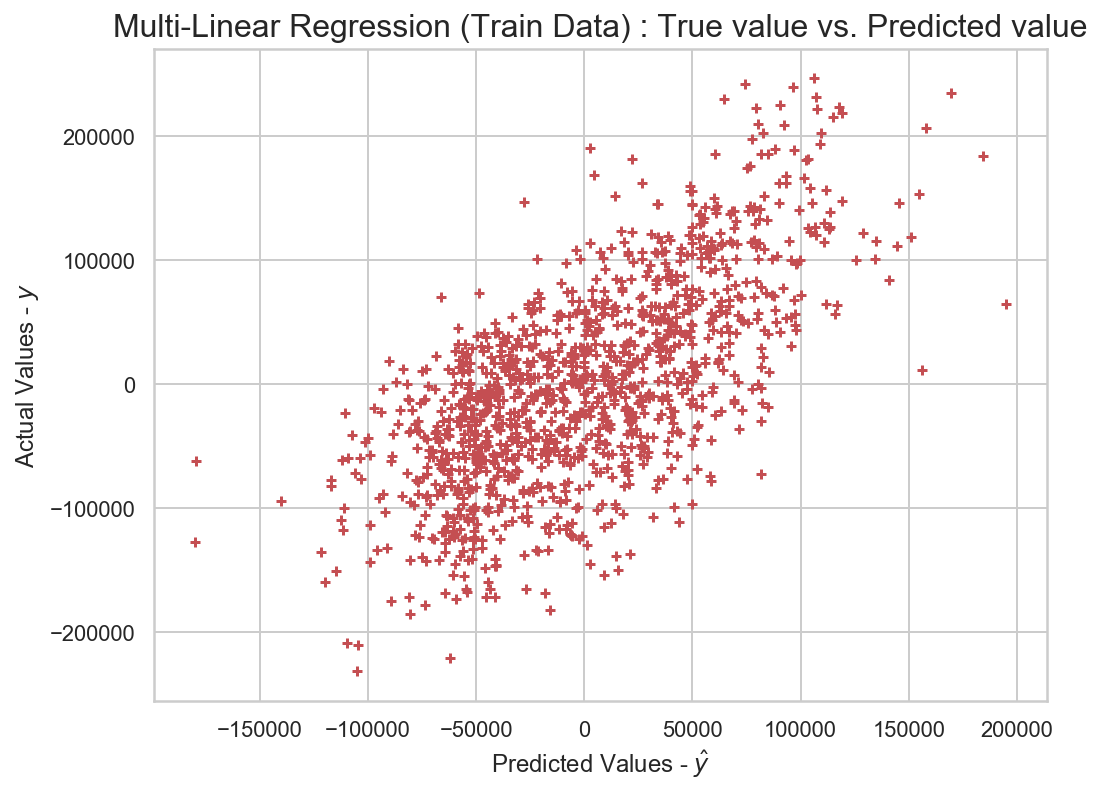

In [1573]:
# Plot the model with training dataset
plt.figure(figsize=(8,6))
plt.title('Multi-Linear Regression (Train Data) : True value vs. Predicted value',fontsize=16)
plt.scatter(predictions, yr_train, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicted Values - $\hat{y}$")
plt.ylabel("Actual Values - $y$")
plt.show();

In [1574]:
# With test data set
renovatable_predictions = linreg.predict(Xr_test)
print("RMSE for whole test dataset:", np.sqrt(metrics.mean_squared_error(yr_test, renovatable_predictions)))

RMSE for whole test dataset: 63246.24115883192


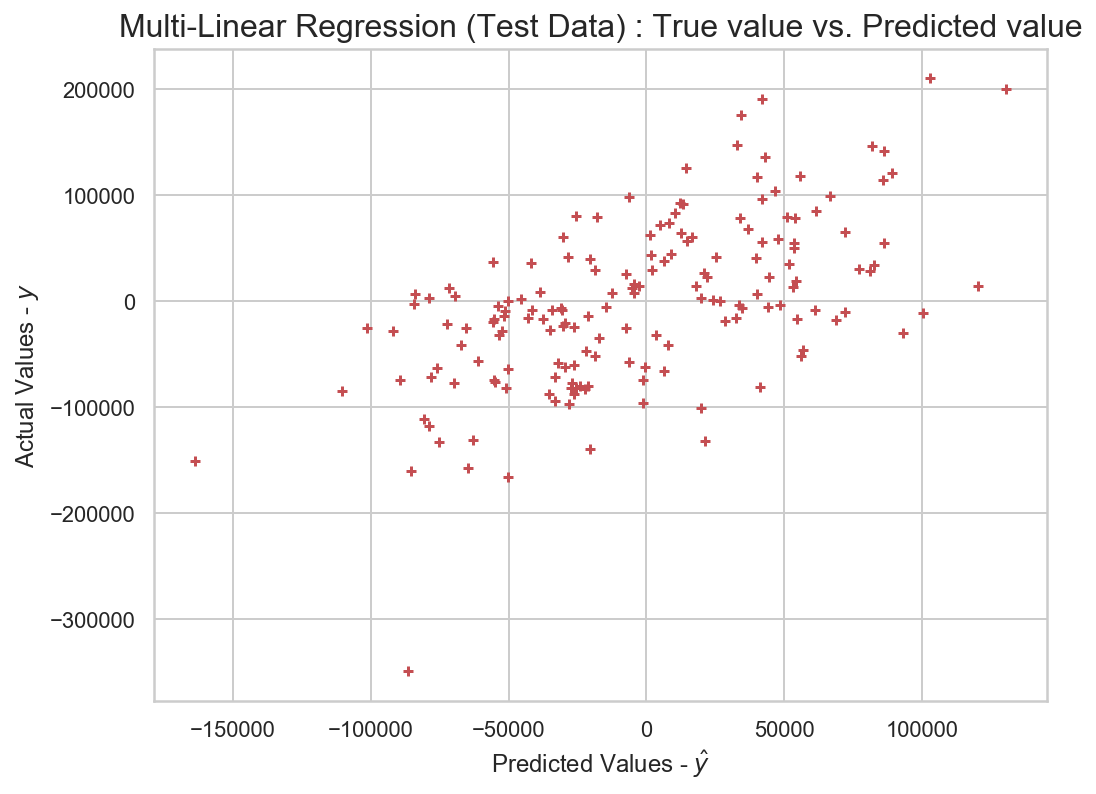

In [1575]:
# Plot the model with test dataset
plt.figure(figsize=(8,6))
plt.title('Multi-Linear Regression (Test Data) : True value vs. Predicted value',fontsize=16)
plt.scatter(renovatable_predictions, yr_test, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicted Values - $\hat{y}$")
plt.ylabel("Actual Values - $y$")
plt.show()

### RidgeCV

In [1576]:
# Setting kfold
kf_shuffle = KFold(n_splits=10,shuffle=True, random_state=42)

# create an array of alpha values
alpha_range = np.logspace(-3, 4, num=200)
print('min alpha : {}'.format(min(alpha_range)))
print('max alpha : {}'.format(max(alpha_range)))
print('total alpha : {}'.format(len(alpha_range)))

# select the best alpha with RidgeCV
ridgeregcv = RidgeCV(alphas=alpha_range, normalize=True, scoring='neg_mean_squared_error', cv=kf_shuffle)
ridgeregcv.fit(Xr_train, yr_train)
print('Best ridge alpha : {}'.format(ridgeregcv.alpha_))
# Getting intercept of the model
print('RidgeCV intercept : {}'.format(ridgeregcv.intercept_))

# predict method uses the best alpha value
yr_pred = ridgeregcv.predict(Xr_test)
print('Best Error RMSE for test dataset : {}'.format(np.sqrt(metrics.mean_squared_error(yr_test, yr_pred))))
print('RidgeCV train score : {}'.format(ridgeregcv.score(Xr_train,yr_train)))

min alpha : 0.001
max alpha : 10000.0
total alpha : 200
Best ridge alpha : 0.26738416158399464
RidgeCV intercept : -442309.71297865093
Best Error RMSE for test dataset : 61483.86901737319
RidgeCV train score : 0.42957470894269256


Best Error RMSE for test dataset : 61483.86901737319
RidgeCV test score : 0.3827481243216833


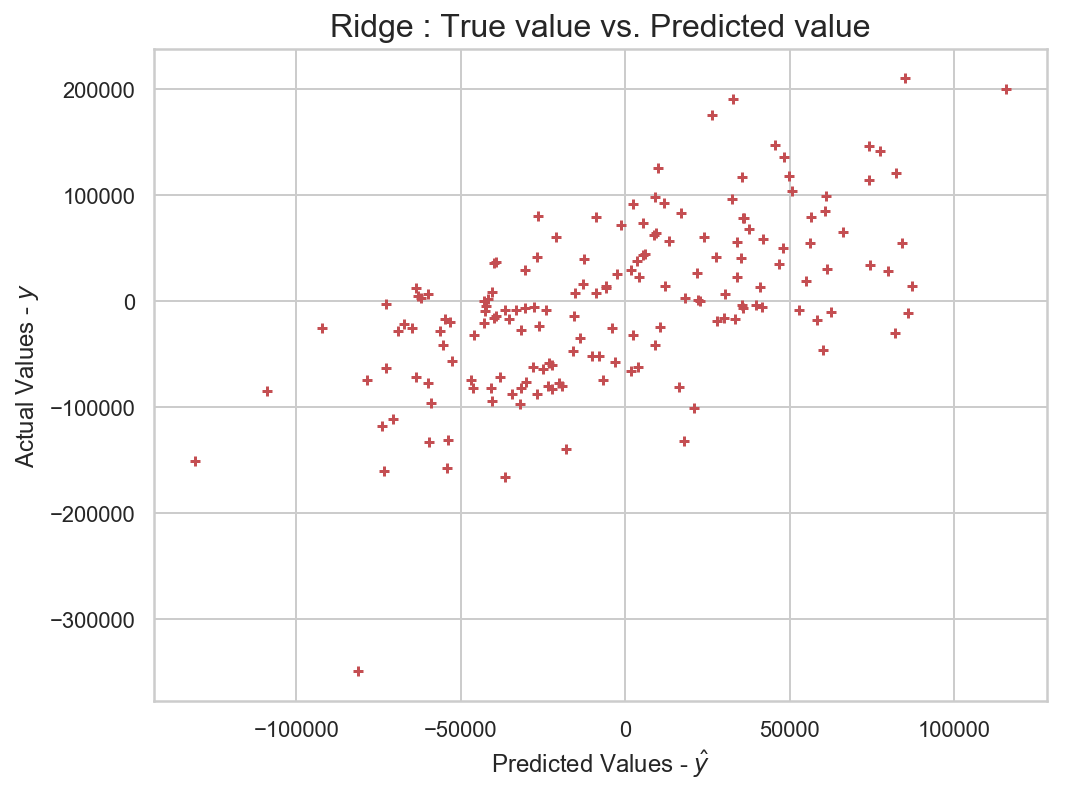

In [1577]:
# Plot the model with test dataset
# With test data set
predictions = ridgeregcv.predict(Xr_test)
print("Best Error RMSE for test dataset : {}".format(np.sqrt(metrics.mean_squared_error(yr_test, predictions))))
print('RidgeCV test score : {}'.format(ridgeregcv.score(Xr_test,yr_test)))
plt.figure(figsize=(8,6))
plt.title('Ridge : True value vs. Predicted value',fontsize=16)
plt.scatter(predictions, yr_test, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicted Values - $\hat{y}$")
plt.ylabel("Actual Values - $y$")
plt.show()

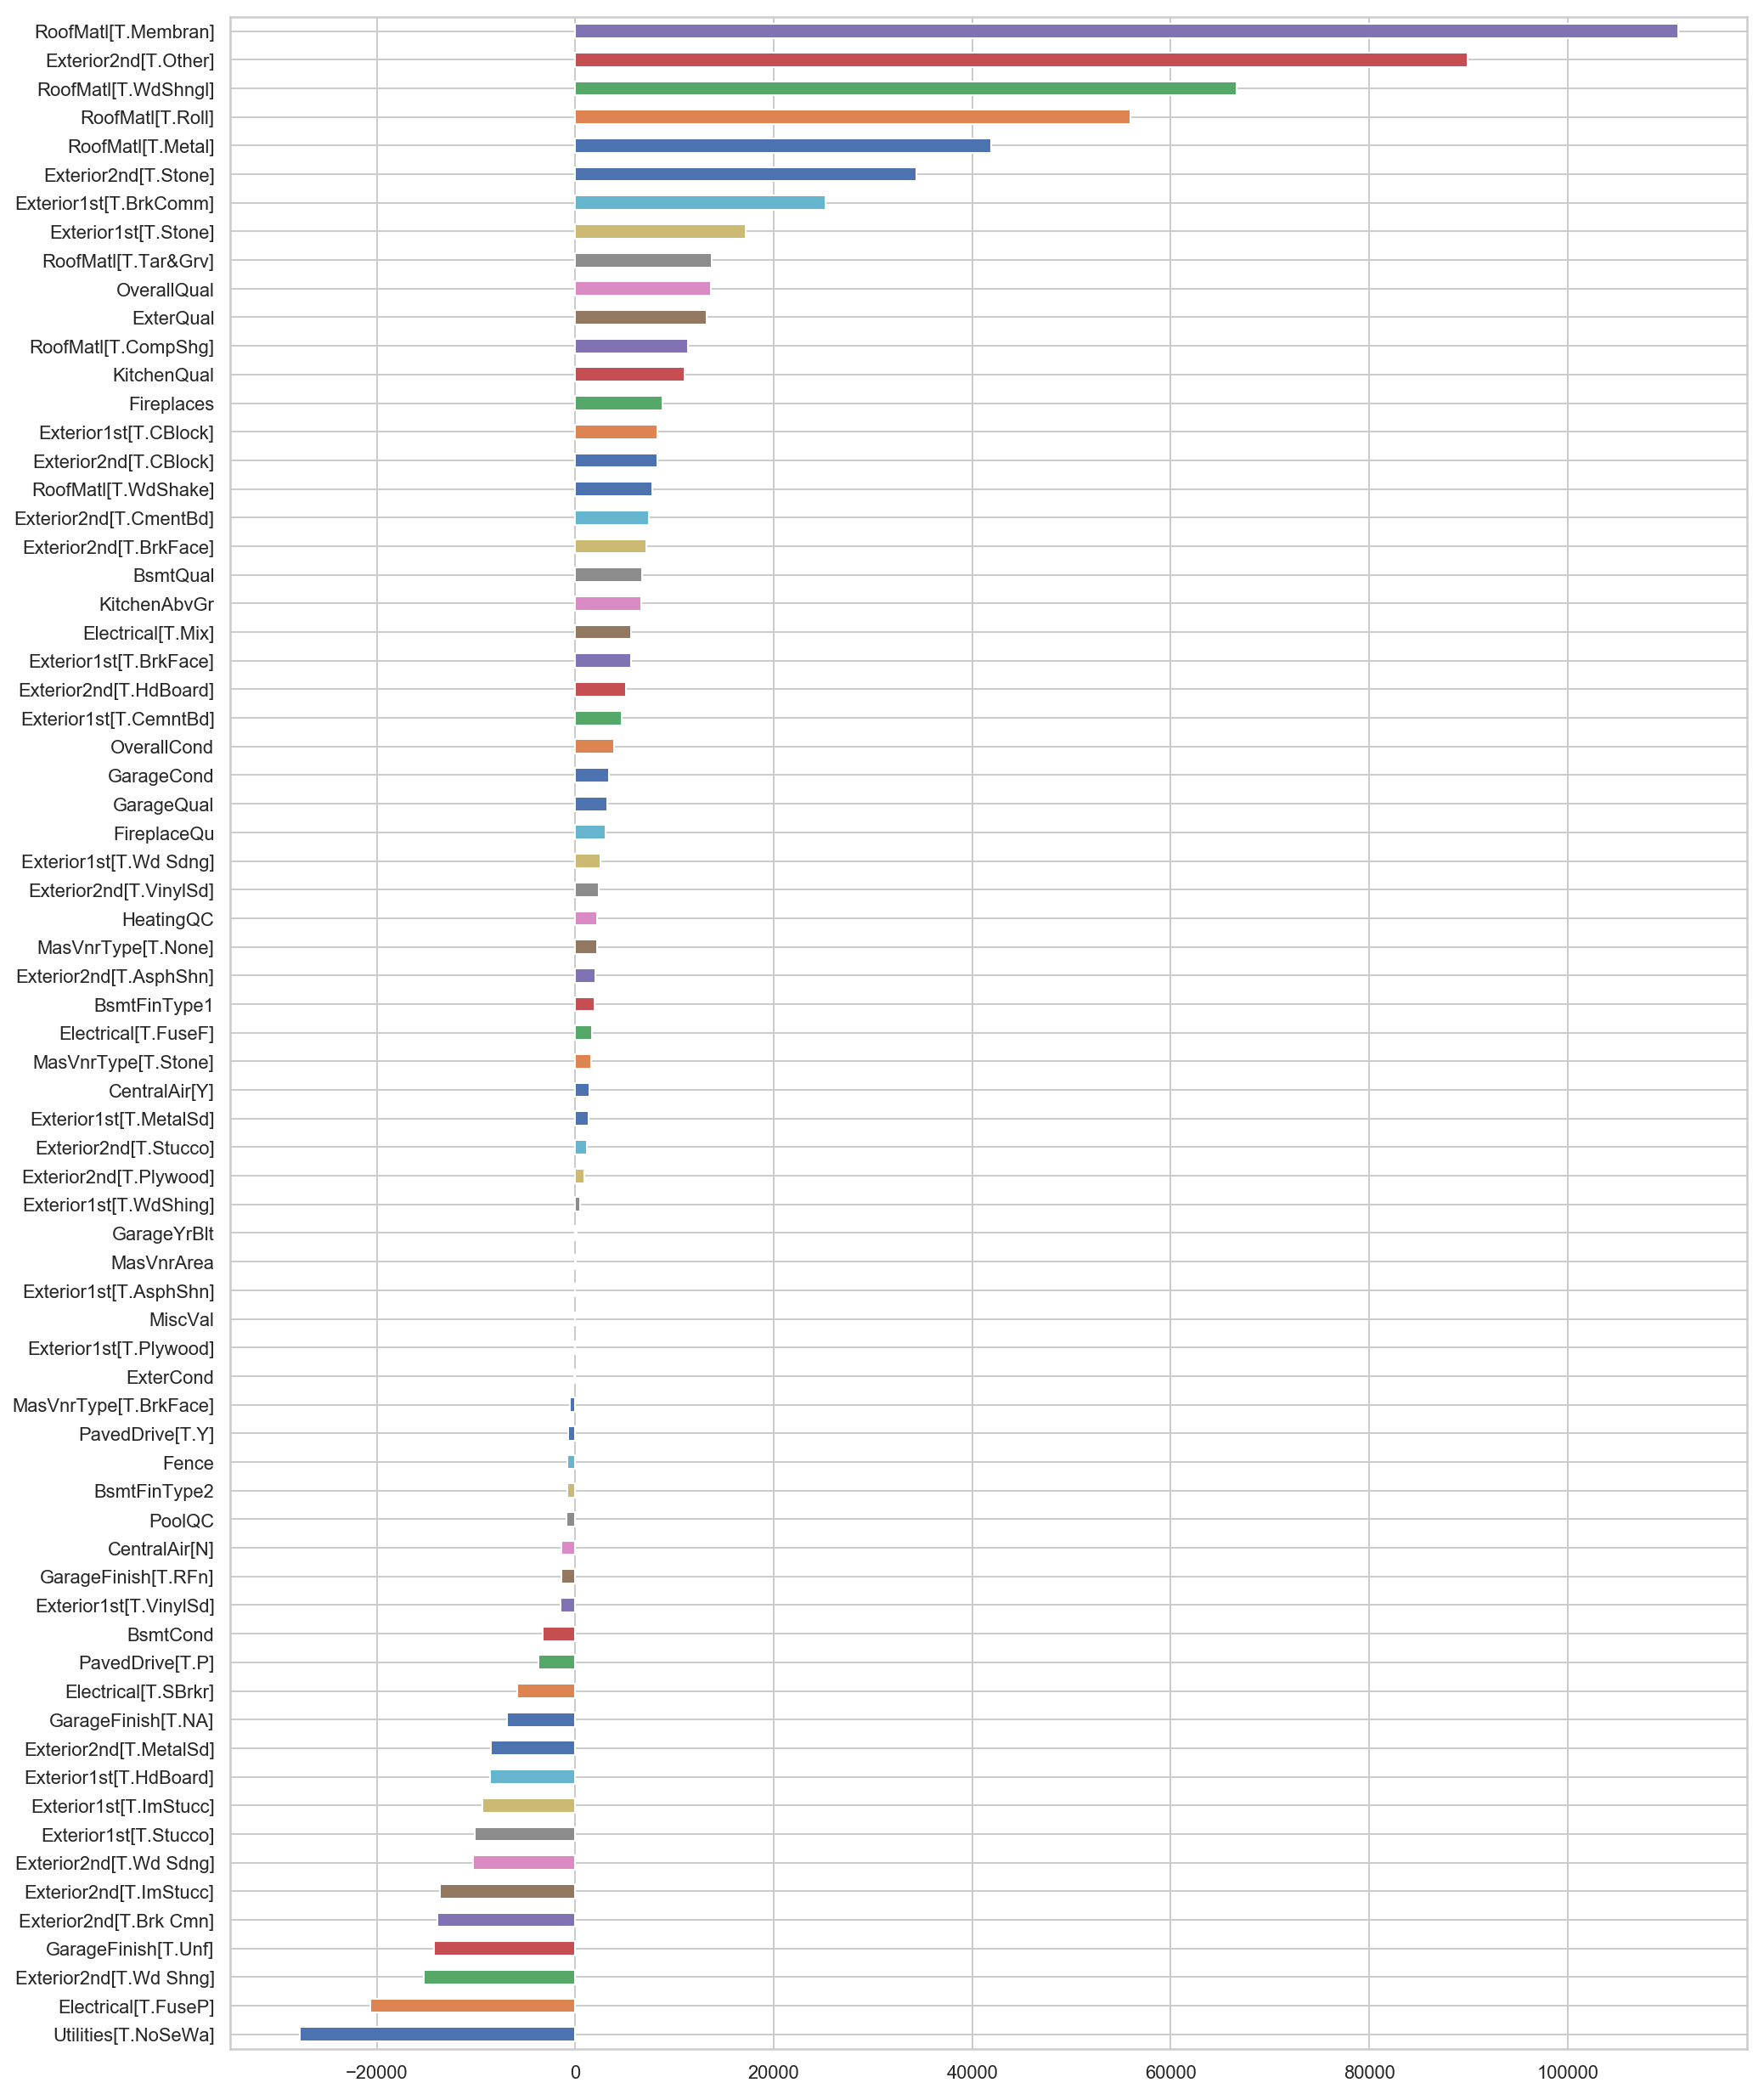

In [1578]:
plt.figure(figsize=(16,22))
fit_importance_lassoreg = pd.Series(ridgeregcv.coef_,index=train_dataset.columns.difference(['Residuals','YrSold']))
fit_importance_lassoreg.sort_values(ascending=True).plot(kind='barh')
plt.show();

### LassoCV

In [1579]:
alpha_range = np.logspace(-1, 4, num=800)
lassoregcv = LassoCV(alphas=alpha_range, random_state=42, cv=10)
#yr_train = y_train.values.ravel()
lassoregcv.fit(Xr_train, yr_train)
print('Best lasso alpha : {}'.format(lassoregcv.alpha_))

# predict method uses the best alpha value with non-standardized test value
yr_pred = lassoregcv.predict(Xr_test)
print("Best Error RMSE for test dataset (no standardization) : {}".format(np.sqrt(metrics.mean_squared_error(yr_test, yr_pred))))
print('LassoregCV train score : {}'.format(lassoregcv.score(Xr_train,yr_train)))
      

Best lasso alpha : 451.4069177145081
Best Error RMSE for test dataset (no standardization) : 61449.901092108244
LassoregCV train score : 0.4206113758648996


Best Error RMSE for test dataset : 61449.901092108244
LassoregCV test score : 0.3834299608480686


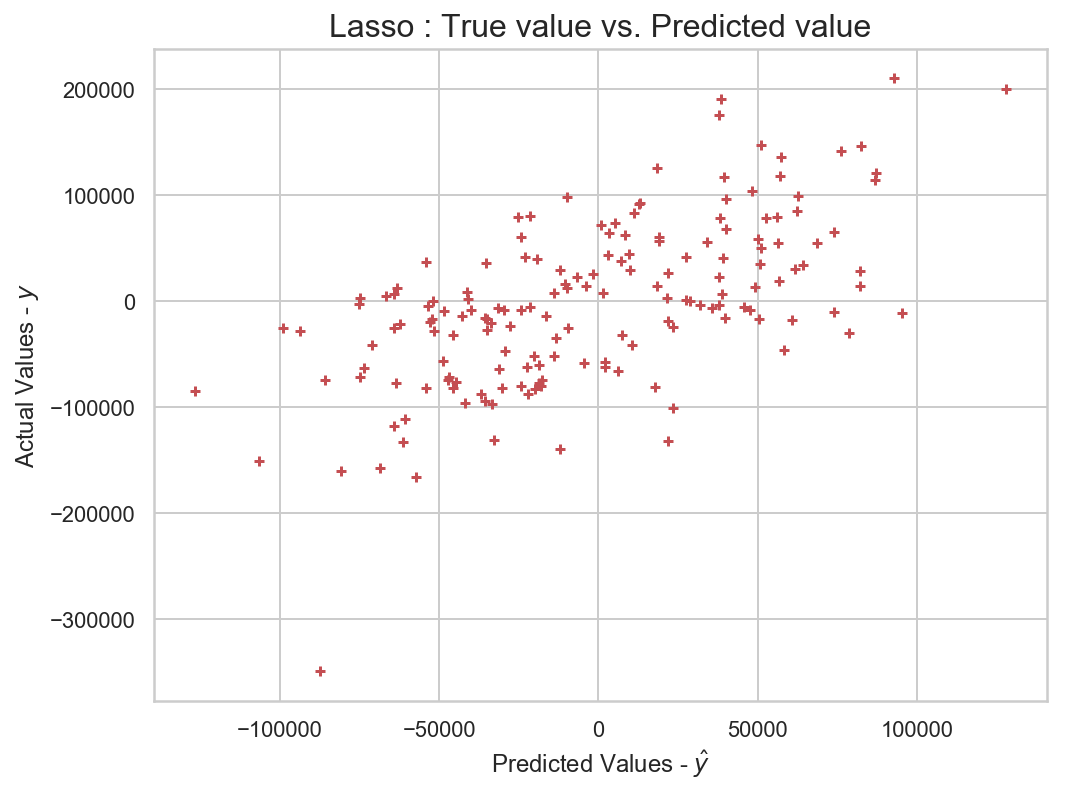

In [1580]:
# Plot the model with test dataset which are standardized during LassoCV
# Predict with standardized dataset
predictions = lassoregcv.predict(Xr_test)

print("Best Error RMSE for test dataset : {}".format(np.sqrt(metrics.mean_squared_error(yr_test, predictions))))
print('LassoregCV test score : {}'.format(lassoregcv.score(Xr_test,yr_test)))
plt.figure(figsize=(8,6))
plt.title('Lasso : True value vs. Predicted value',fontsize=16)
plt.scatter(predictions, yr_test, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicted Values - $\hat{y}$")
plt.ylabel("Actual Values - $y$")
plt.show();


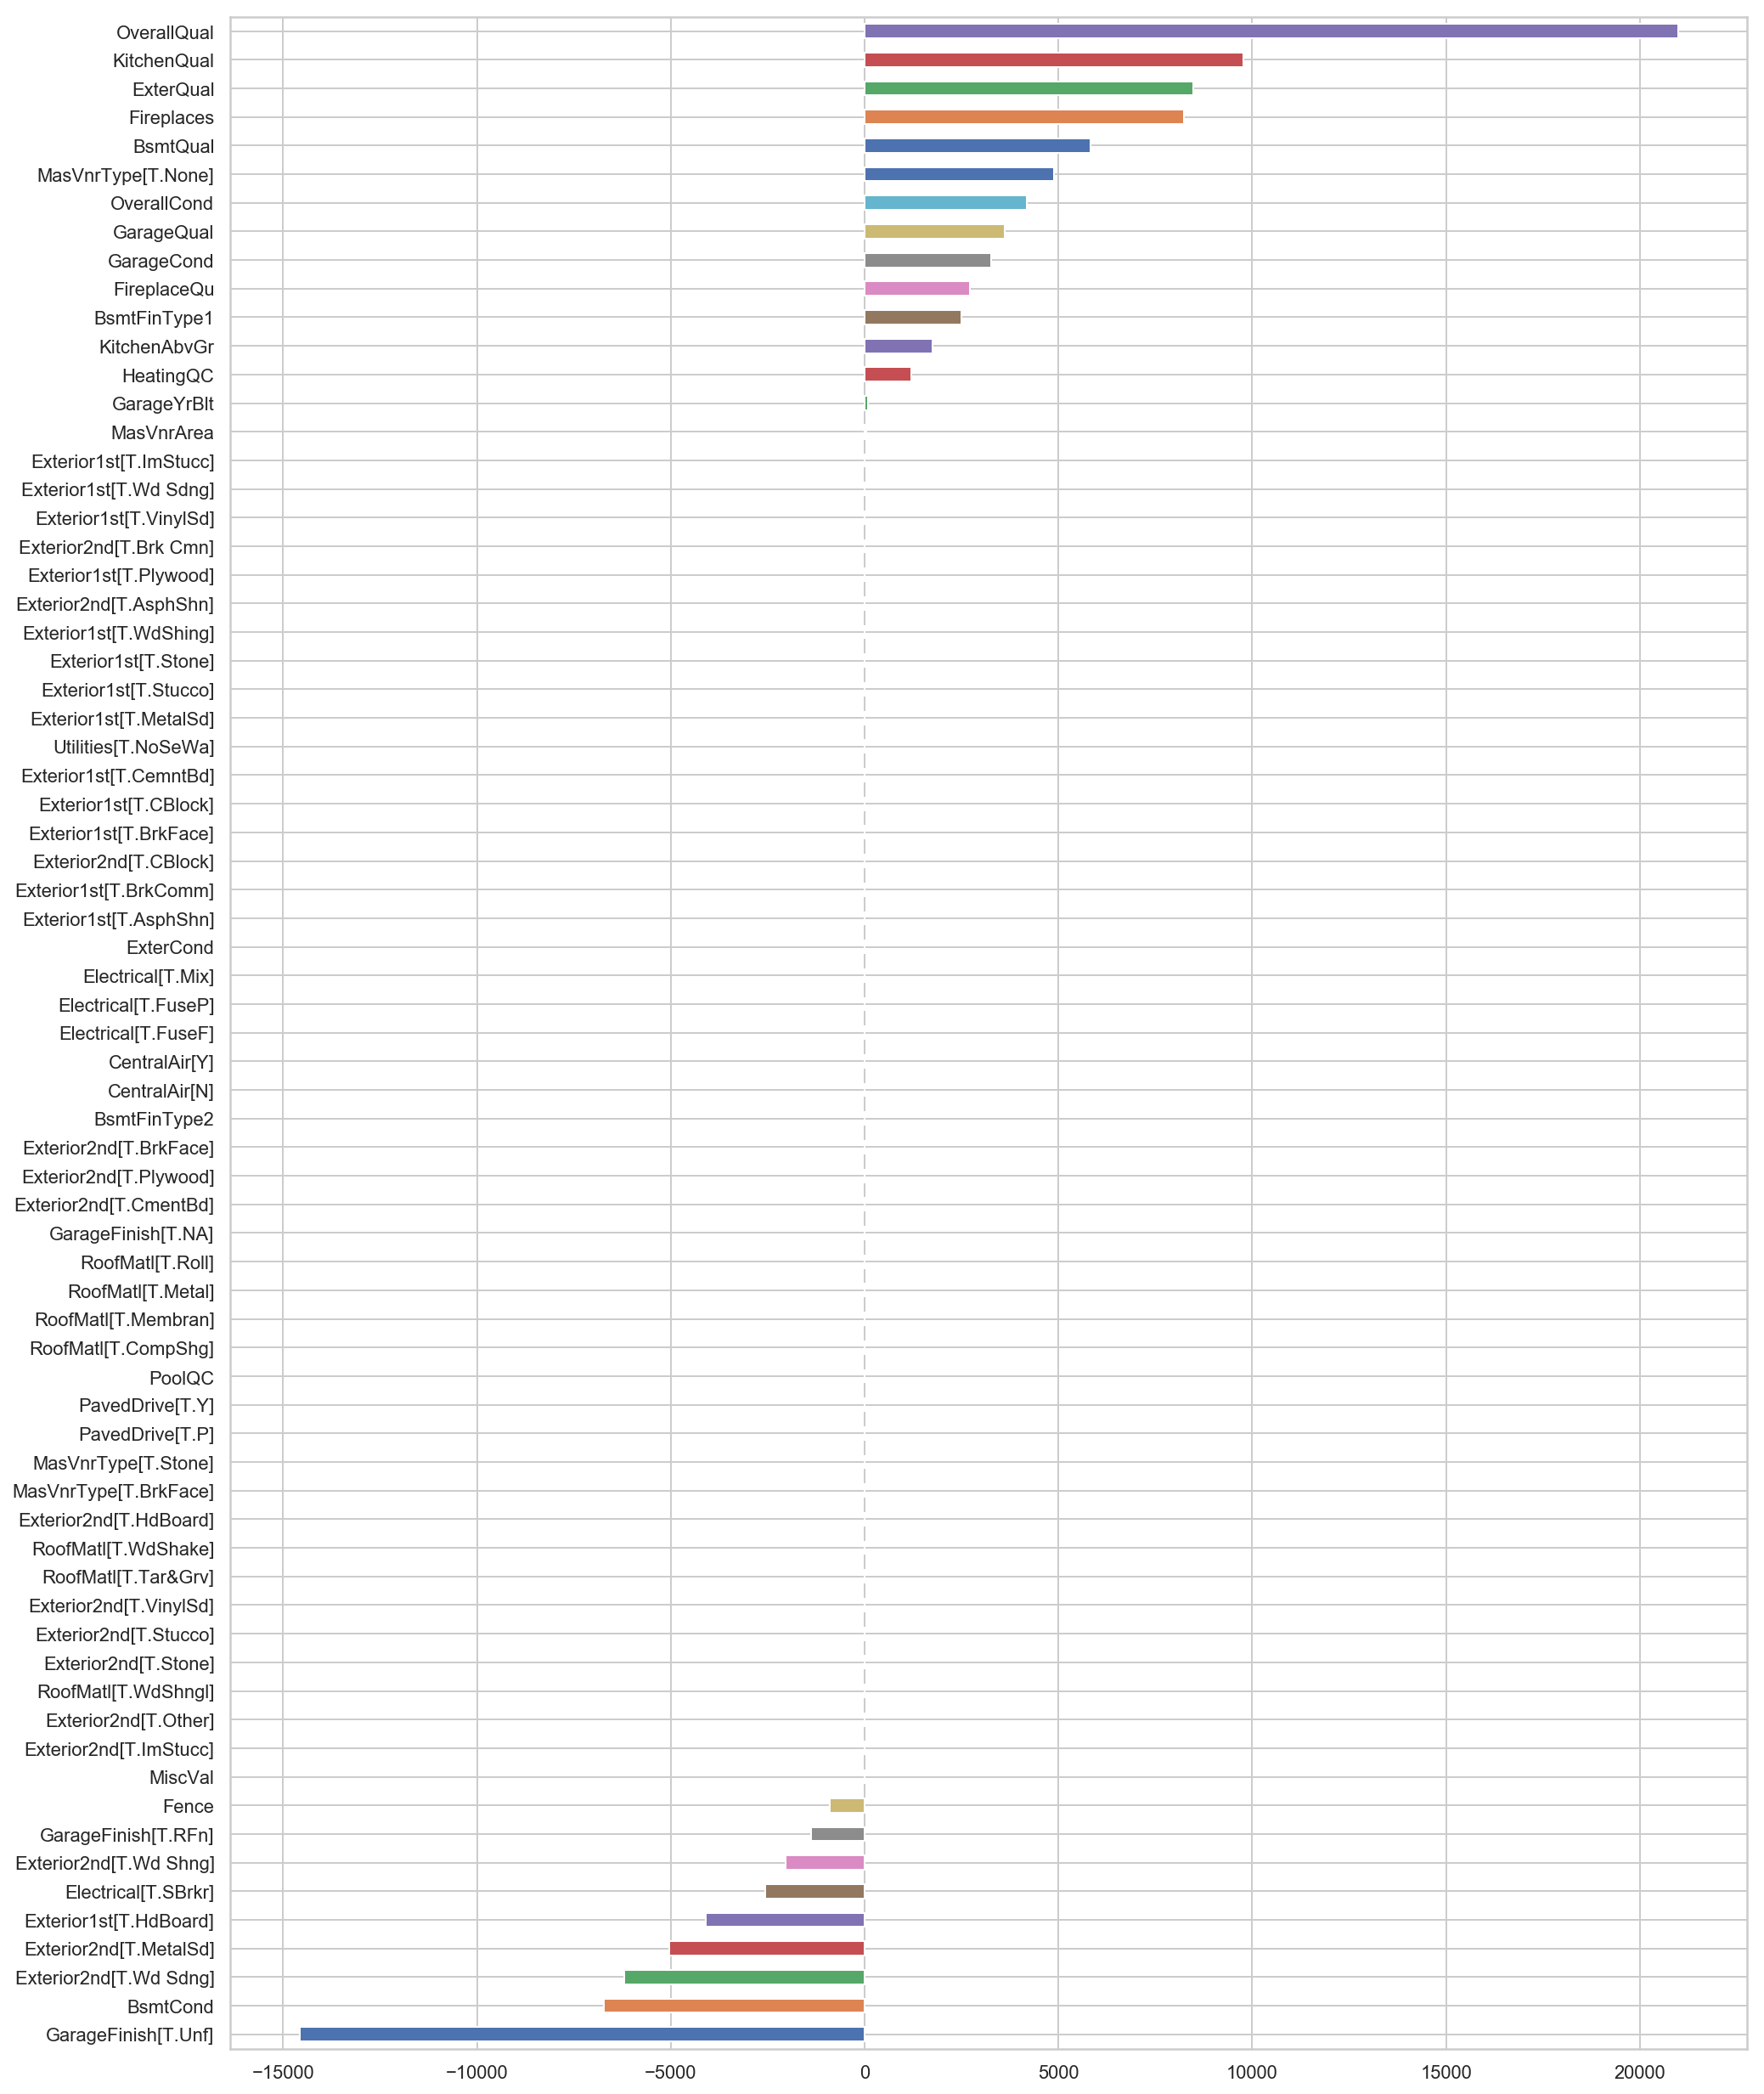

In [1581]:
plt.figure(figsize=(16,22))
fit_importance_lassoreg = pd.Series(lassoregcv.coef_,index=train_dataset.columns.difference(['Residuals','YrSold']))
fit_importance_lassoreg.sort_values(ascending=True).plot(kind='barh')
plt.show();

### ElasticNetCV

In [1582]:
# create an array of alpha values
alpha_range = np.logspace(-1, 4, num=200)
l1_ratios = np.arange(0.1,1.1,0.1)
print('min alpha : {}'.format(min(alpha_range)))
print('max alpha : {}'.format(max(alpha_range)))

# select the best alpha with ElasticNetCV
elasticnetcv = ElasticNetCV(alphas=alpha_range, l1_ratio=l1_ratios, cv=kf_shuffle,)
elasticnetcv.fit(Xr_train, yr_train)

min alpha : 0.1
max alpha : 10000.0


ElasticNetCV(alphas=array([1.00000e-01, 1.05956e-01, ..., 9.43788e+03, 1.00000e+04]),
       copy_X=True, cv=KFold(n_splits=10, random_state=42, shuffle=True),
       eps=0.001, fit_intercept=True,
       l1_ratio=array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
       max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
       positive=False, precompute='auto', random_state=None,
       selection='cyclic', tol=0.0001, verbose=0)

In [1583]:
print('Best elasticnet alpha: {}'.format(elasticnetcv.alpha_))
print('Best elasticnet l1 ratio: {}'.format(elasticnetcv.l1_ratio_))
print("R2 scores for 10 folds : {}".format(elasticnetcv.score(Xr_train,yr_train)))
#print("R2 mean : {}, R2 std : {}".format(np.mean(scores), np.std(scores)))

Best elasticnet alpha: 1.4314589375234792
Best elasticnet l1 ratio: 0.9
R2 scores for 10 folds : 0.4180542961261394


In [1584]:
# Plot the model with test dataset which are standardized during ElasticNetCV
# Predict with standardized dataset
predictions = elasticnetcv.predict(Xr_test)

Best Error RMSE for test dataset : 61638.159369604786
ElasticNetCV test score : 0.3796463187400171


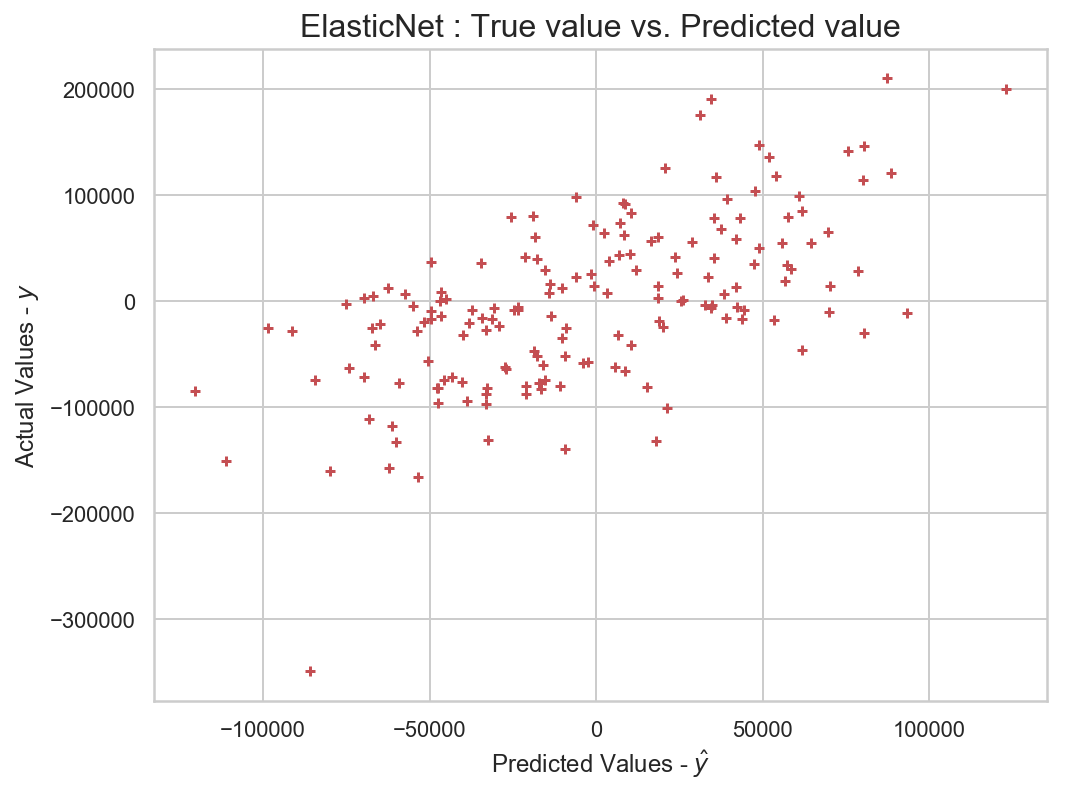

In [1585]:
print("Best Error RMSE for test dataset : {}".format(np.sqrt(metrics.mean_squared_error(yr_test, predictions))))
print('ElasticNetCV test score : {}'.format(elasticnetcv.score(Xr_test,yr_test)))
plt.figure(figsize=(8,6))
plt.title('ElasticNet : True value vs. Predicted value',fontsize=16)
plt.scatter(predictions, yr_test, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicted Values - $\hat{y}$")
plt.ylabel("Actual Values - $y$")
plt.show();

### Lasso is choosen to predict the renovation cost

In [1586]:
renovation_predictions = lassoregcv.predict(np.concatenate([Xr_train,Xr_test]))
len(renovation_predictions)

1388

In [1587]:
Residential_house['Renovation_Pred'] = renovation_predictions

In [1588]:
Residential_house['Renovation_Pred'].isnull().value_counts()

False    1388
Name: Renovation_Pred, dtype: int64

In [1589]:
Residential_house[Residential_house['Renovation_Pred']<0].shape

(716, 81)

In [1590]:
Residential_house.head()

MSSubClass MSZoning  LotFrontage  LotArea Street  \
0             2-STORY 1946 & NEWER       RL         65.0     8450   Pave   
1  1-STORY 1946 & NEWER ALL STYLES       RL         80.0     9600   Pave   
2             2-STORY 1946 & NEWER       RL         68.0    11250   Pave   
3             2-STORY 1945 & OLDER       RL         60.0     9550   Pave   
4             2-STORY 1946 & NEWER       RL         84.0    14260   Pave   

  Alley LotShape LandContour Utilities LotConfig       ...         \
0    NA      Reg         Lvl    AllPub    Inside       ...          
1    NA      Reg         Lvl    AllPub       FR2       ...          
2    NA      IR1         Lvl    AllPub    Inside       ...          
3    NA      IR1         Lvl    AllPub    Corner       ...          
4    NA      IR1         Lvl    AllPub       FR2       ...          

  SaleCondition SalePrice TotalFullBath TotalHalfBath HouseAge RenovationAge  \
0        Normal    208500             3             1       -5            -5   
1        Normal    181500             2             1      -31           -31   
2        Normal    223500             3             1       -7            -6   
3       Abnorml    140000             2             0      -91           -36   
4        Normal    250000             3             1       -8            -8   

   GarageAge     Fixed_Pred     Residuals  Renovation_Pred  
0       -5.0  206321.931171   2178.068829     40874.298038  
1      -31.0  184468.486857  -2968.486857     19556.262424  
2       -7.0  214827.802886   8672.197114     55979.229865  
3       -8.0  191511.149818 -51511.149818     18174.583498  
4       -8.0  279644.711194 -29644.711194     82958.233857  

[5 rows x 81 columns]

In [1591]:
Residential_house['Residuals'] = Residential_house['SalePrice'] - Residential_house['Fixed_Pred']

In [1592]:
Residential_house['Residuals'].isnull().value_counts()

False    1388
Name: Residuals, dtype: int64

In [1593]:
Residential_house.shape

(1388, 81)

In [1594]:
Residential_house['Residuals'] = Residential_house['SalePrice'] - Residential_house['Fixed_Pred']

In [1595]:
r_result = list(zip(train_dataset[train_dataset.columns.difference(['Residuals','YrSold'])],lassoregcv.coef_))
#result_df = pd.DataFrame(result, columns=['Features','Coef'])
# Checking the coefficients and take the features with positive coef. 
print("Renovation features (important) which has positve effects on saleprice :")
[ i for i in r_result if i[1]>0]

Renovation features (important) which has positve effects on saleprice :


[('BsmtFinType1', 2501.852580011691),
 ('BsmtQual', 5825.298160962643),
 ('ExterQual', 8467.323178719227),
 ('FireplaceQu', 2706.0349678584394),
 ('Fireplaces', 8235.693301110596),
 ('GarageCond', 3267.7702856316746),
 ('GarageQual', 3610.238732510393),
 ('GarageYrBlt', 75.75482467566),
 ('HeatingQC', 1202.052339733334),
 ('KitchenAbvGr', 1754.4924703997226),
 ('KitchenQual', 9776.551458387461),
 ('MasVnrArea', 32.27519789940634),
 ('MasVnrType[T.None]', 4894.4763526821525),
 ('OverallCond', 4190.947719417283),
 ('OverallQual', 20987.02161213766)]

In [1596]:
print("Renovation features (not important) which has negative effects on saleprice :")
[ i for i in r_result if i[1]<0]

Renovation features (not important) which has negative effects on saleprice :


[('BsmtCond', -6718.770736083579),
 ('Electrical[T.SBrkr]', -2558.6226219556806),
 ('Exterior1st[T.HdBoard]', -4088.4608720106758),
 ('Exterior2nd[T.MetalSd]', -5035.085445884063),
 ('Exterior2nd[T.Wd Sdng]', -6197.126478086975),
 ('Exterior2nd[T.Wd Shng]', -2041.2809979774759),
 ('Fence', -900.0638073088621),
 ('GarageFinish[T.RFn]', -1387.0786566029824),
 ('GarageFinish[T.Unf]', -14579.811817006386),
 ('MiscVal', -0.9680486078686797)]

In [1597]:
np.std(Residential_house['Renovation_Pred'])

50666.714130650864

#### Conclusion : 
#### Renovatable featurers play its part in getting higher in sale price. The Renovation_Pred column provide the extra price affected by renovatable features such as quality and condition for overall, kitchen, garage, basement, fireplace, heating, exterior and Masonry veneer.
#### By observing the positive coefficients and its features of the second model (renovatable), the company can decide if they should buy the property based on these condition and quality of these features. Besides, the company can renovate these important renovatable features to sell back in profitable price and avoid renovating which are just sunken cost and not necessary or effective in making profit.
#### $50666 in price remaining is explained by these renovatable features.
#### My model can predict and evaluate the property and its price reasonably. However, it still have rooms to improve. It has its limitation since this dataset is only from Iowa. 

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [1598]:
# A: